In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data.csv",parse_dates=["posted","scraped"])



df["age"] = (df.scraped - df.posted).dt.total_seconds()//3600
df["weekday"] = df.posted.dt.day_name()
df["weekday_number"] = df.posted.dt.dayofweek
df["hour"] = df.posted.dt.hour
df["date"] = pd.to_datetime(df.posted.dt.date)
df["year"] = df.posted.dt.year
df["month"] = df.posted.dt.month
df["yrmnth"] = (df.year-2021)*12 + df.month
df["target"] = np.log(df.upvotes+1)

df["fhost"] = df.url.apply(lambda x: "imgur" if "imgur" in x else "reddit")
df["format"] = df.url.apply(lambda x: x.split(".")[-1])

df["timestep"] = (df.posted - df.posted.min()).dt.days

sub = pd.read_csv("subscribers.csv",parse_dates=["timestamp"])

sub["date"] = sub.timestamp.dt.date

sub = sub.pivot(index="date",columns=["subreddit"],values="subscribers")

# Correcting any missing dates
daterange = pd.date_range(start=df.date.min(),end=df.date.max(),freq="D")
sub = sub.reindex(daterange)

# Filling in the new NULL values
sub.interpolate(method="linear",inplace=True)
sub.bfill(inplace=True)


# Adding the date back into the columns so we can melt the updated dataset
sub["date"] = pd.to_datetime(sub.index)
sub = pd.melt(sub,id_vars="date")


# Joining the two dataframes together
df = df.merge(sub.rename(columns={"value":"subscribers"}),how="left",on=["date","subreddit"])





stage1 = df.groupby(["date","subreddit","category","hour"],as_index=False).agg({"upvotes":"count"}).rename(columns={"upvotes":"competition_subreddit"})
stage2 = stage1.groupby(["date","hour","category"],as_index=False).agg({"competition_subreddit":"sum"}).rename(columns={"competition_subreddit":"competition_category"})
stage3 = stage2.groupby(["date","hour"],as_index=False).agg({"competition_category":"sum"}).rename(columns={"competition_category":"competition_total"})



df = df.merge(stage1,how="left",on=["date","hour","subreddit","category"]).merge(stage2,how="left",on=["date","hour","category"]).merge(stage3,how="left",on=["date","hour"])


df["title_length"] = df.title.apply(lambda x: len(x.split(" ")))
df["length"] = df.title_length.astype(str)
for i in range(3):    
    df.loc[(df.title_length>=(5*i+15))&(df.title_length<(5*i+20)),"length"] = f'{5*i+15}-{5*i+19}'
for i in range(4):
    df.loc[(df.title_length>=(10*i+30))&(df.title_length<(10*i+40)),"length"] = f'{10*i+30}-{10*i+39}'

df["exclamation"] = df.title.str.contains("!")


for kw in pd.read_csv("keywords.csv").keywords:
    
    df[f'keyword_{kw}'] = df.title.str.lower().str.contains(kw)


    
df["target"] -= df.target.mean()
df["target"] /= df.target.std()    
    
df.head()



fname                                  url category  \
0  cgptykrzcez71.jpg  https://i.redd.it/cgptykrzcez71.jpg     cats   
1        EGjVMqx.jpg      https://i.imgur.com/EGjVMqx.jpg     cats   
2  y45936kis8z71.jpg  https://i.redd.it/y45936kis8z71.jpg     cats   
3  irl2nzyro8z71.jpg  https://i.redd.it/irl2nzyro8z71.jpg     cats   
4  vlsh4hijg8z71.jpg  https://i.redd.it/vlsh4hijg8z71.jpg     cats   

     subreddit                                              title  \
0  catpictures                              Caturday morning TV 😺   
1  catpictures                                        Round loaf!   
2  catpictures                             Taken over fall wreath   
3  catpictures                                  My kitten, Topaz!   
4  catpictures  My Tom is not impressed having to wait for the...   

   description  upvotes              posted                    scraped  niche  \
0          NaN    247.0 2021-11-13 11:22:11 2021-11-21 09:28:28.376338    0.0   
1          NaN     24.0 2021-11-13 02:23:31 2021-11-21 09:28:28.376338    0.0   
2          NaN    427.0 2021-11-12 16:38:49 2021-11-21 09:28:28.376338    0.0   
3          NaN    196.0 2021-11-12 16:17:45 2021-11-21 09:28:28.376338    0.0   
4          NaN    620.0 2021-11-12 15:31:23 2021-11-21 09:28:28.376338    0.0   

   ...  keyword_sweet  keyword_happy keyword_big  keyword_baby  keyword_say  \
0  ...          False          False       False         False        False   
1  ...          False          False       False         False        False   
2  ...          False          False       False         False        False   
3  ...          False          False       False         False        False   
4  ...          False          False       False         False        False   

  keyword_day  keyword_enjoy  keyword_kitten  keyword_smile  keyword_cute  
0        True          False           False          False         False  
1       False          False           False          False         False  
2       False          False           False          False         False  
3       False          False            True          False         False  
4       False          False           False          False         False  

[5 rows x 92 columns]

In [3]:
subjects = {"holiday":["santa","xmas","christmas","holiday","valentine","halloween","easter","thanksgiving"]
           ,"death/injury":["rash","worried","cancer"," rip","broke her","broke his","hard time bending ","not feeling so good","not feeling well","the labs gone","splenectomy","post op","passed away","miss her","miss him","surgery","seizure","missing","hospital","hit by car","died"]
           ,"sleep":["comfy","exhausted","tuckered","yawn","relax","cozy","cuddly","chill","dreaming","lazy","bed time","bedtime","slumber","lazing","blanket","snooze","sleepy","snug ","sleep","cuddlin","tired","snoozin","loungin","snuggle","cuddle","chillin","sweepy","leisure","nappin","nap ","nap,"]
           ,"new":["new add","rescued","newest","just adopted","welcome to the fam"]
            ,"sun":["sunny","beach","enjoying morning sun","soaking up the sun","enjoying the sun","sunshine","enjoying the shade","in the sun","sunbeam","sun beam"]
           ,"snow":["snow","winter","cold","-3"]
           ,"attributes":["tail","bean","paw","face","eyes","snoot"," ears"]
           ,"playful":["game of tag","zoomies","play","fetch","tug"]
           ,"birthday":["birthday"]
#            ,"naughty":["naughty","bad girl","bad boy"]
#            ,"poses":["pose","photogenic","photoshoot"]
           ,"walk":["walk","stroll","leash","hike"]
            ,"greeting":["good morning","good evening","good night","Good murrrrning"]+[f'happy {wk.lower()}' for wk in df.weekday.unique()]
           ,"cute":["baby","babies","goodest","adorable","beautiful","cutie","cute","handsome"]
           }


def label(x):
    
    for subject,keywords in subjects.items():
        
        for kw in keywords:
            if kw in x.lower():
                return subject
            
    return "other"

df["subject"] = df.title.apply(label)

df.subject.value_counts()

other           41143
sleep            5355
cute             3411
attributes       2027
holiday          1561
snow             1017
death/injury      722
walk              720
sun               668
playful           603
birthday          568
new               346
greeting          271
Name: subject, dtype: int64

In [4]:
languages = ["English","Italiano"]

In [5]:
translator = {"other":"altro"
 ,"greeting":"saluto"
 ,"sun":"sole"
 ,"sleep":"sonno"
 ,"snow":"neve"
 ,"death/injury":"morte/danno"
 ,"attributes":"caratteristiche"
 ,"new":"nuovo"
 ,"birthday":"compleanno"
 ,"walk":"passeggiata"
 ,"cute":"carino"
 ,"playful":"giocoso"
 ,"holiday":"vacanza"
}

In [7]:
df["soggetto"] = df.subject.apply(lambda x:translator[x])
df.soggetto.value_counts()

altro              41143
sonno               5355
carino              3411
caratteristiche     2027
vacanza             1561
neve                1017
morte/danno          722
passeggiata          720
sole                 668
giocoso              603
compleanno           568
nuovo                346
saluto               271
Name: soggetto, dtype: int64

## Title Length Plots

#### Number of posts by length

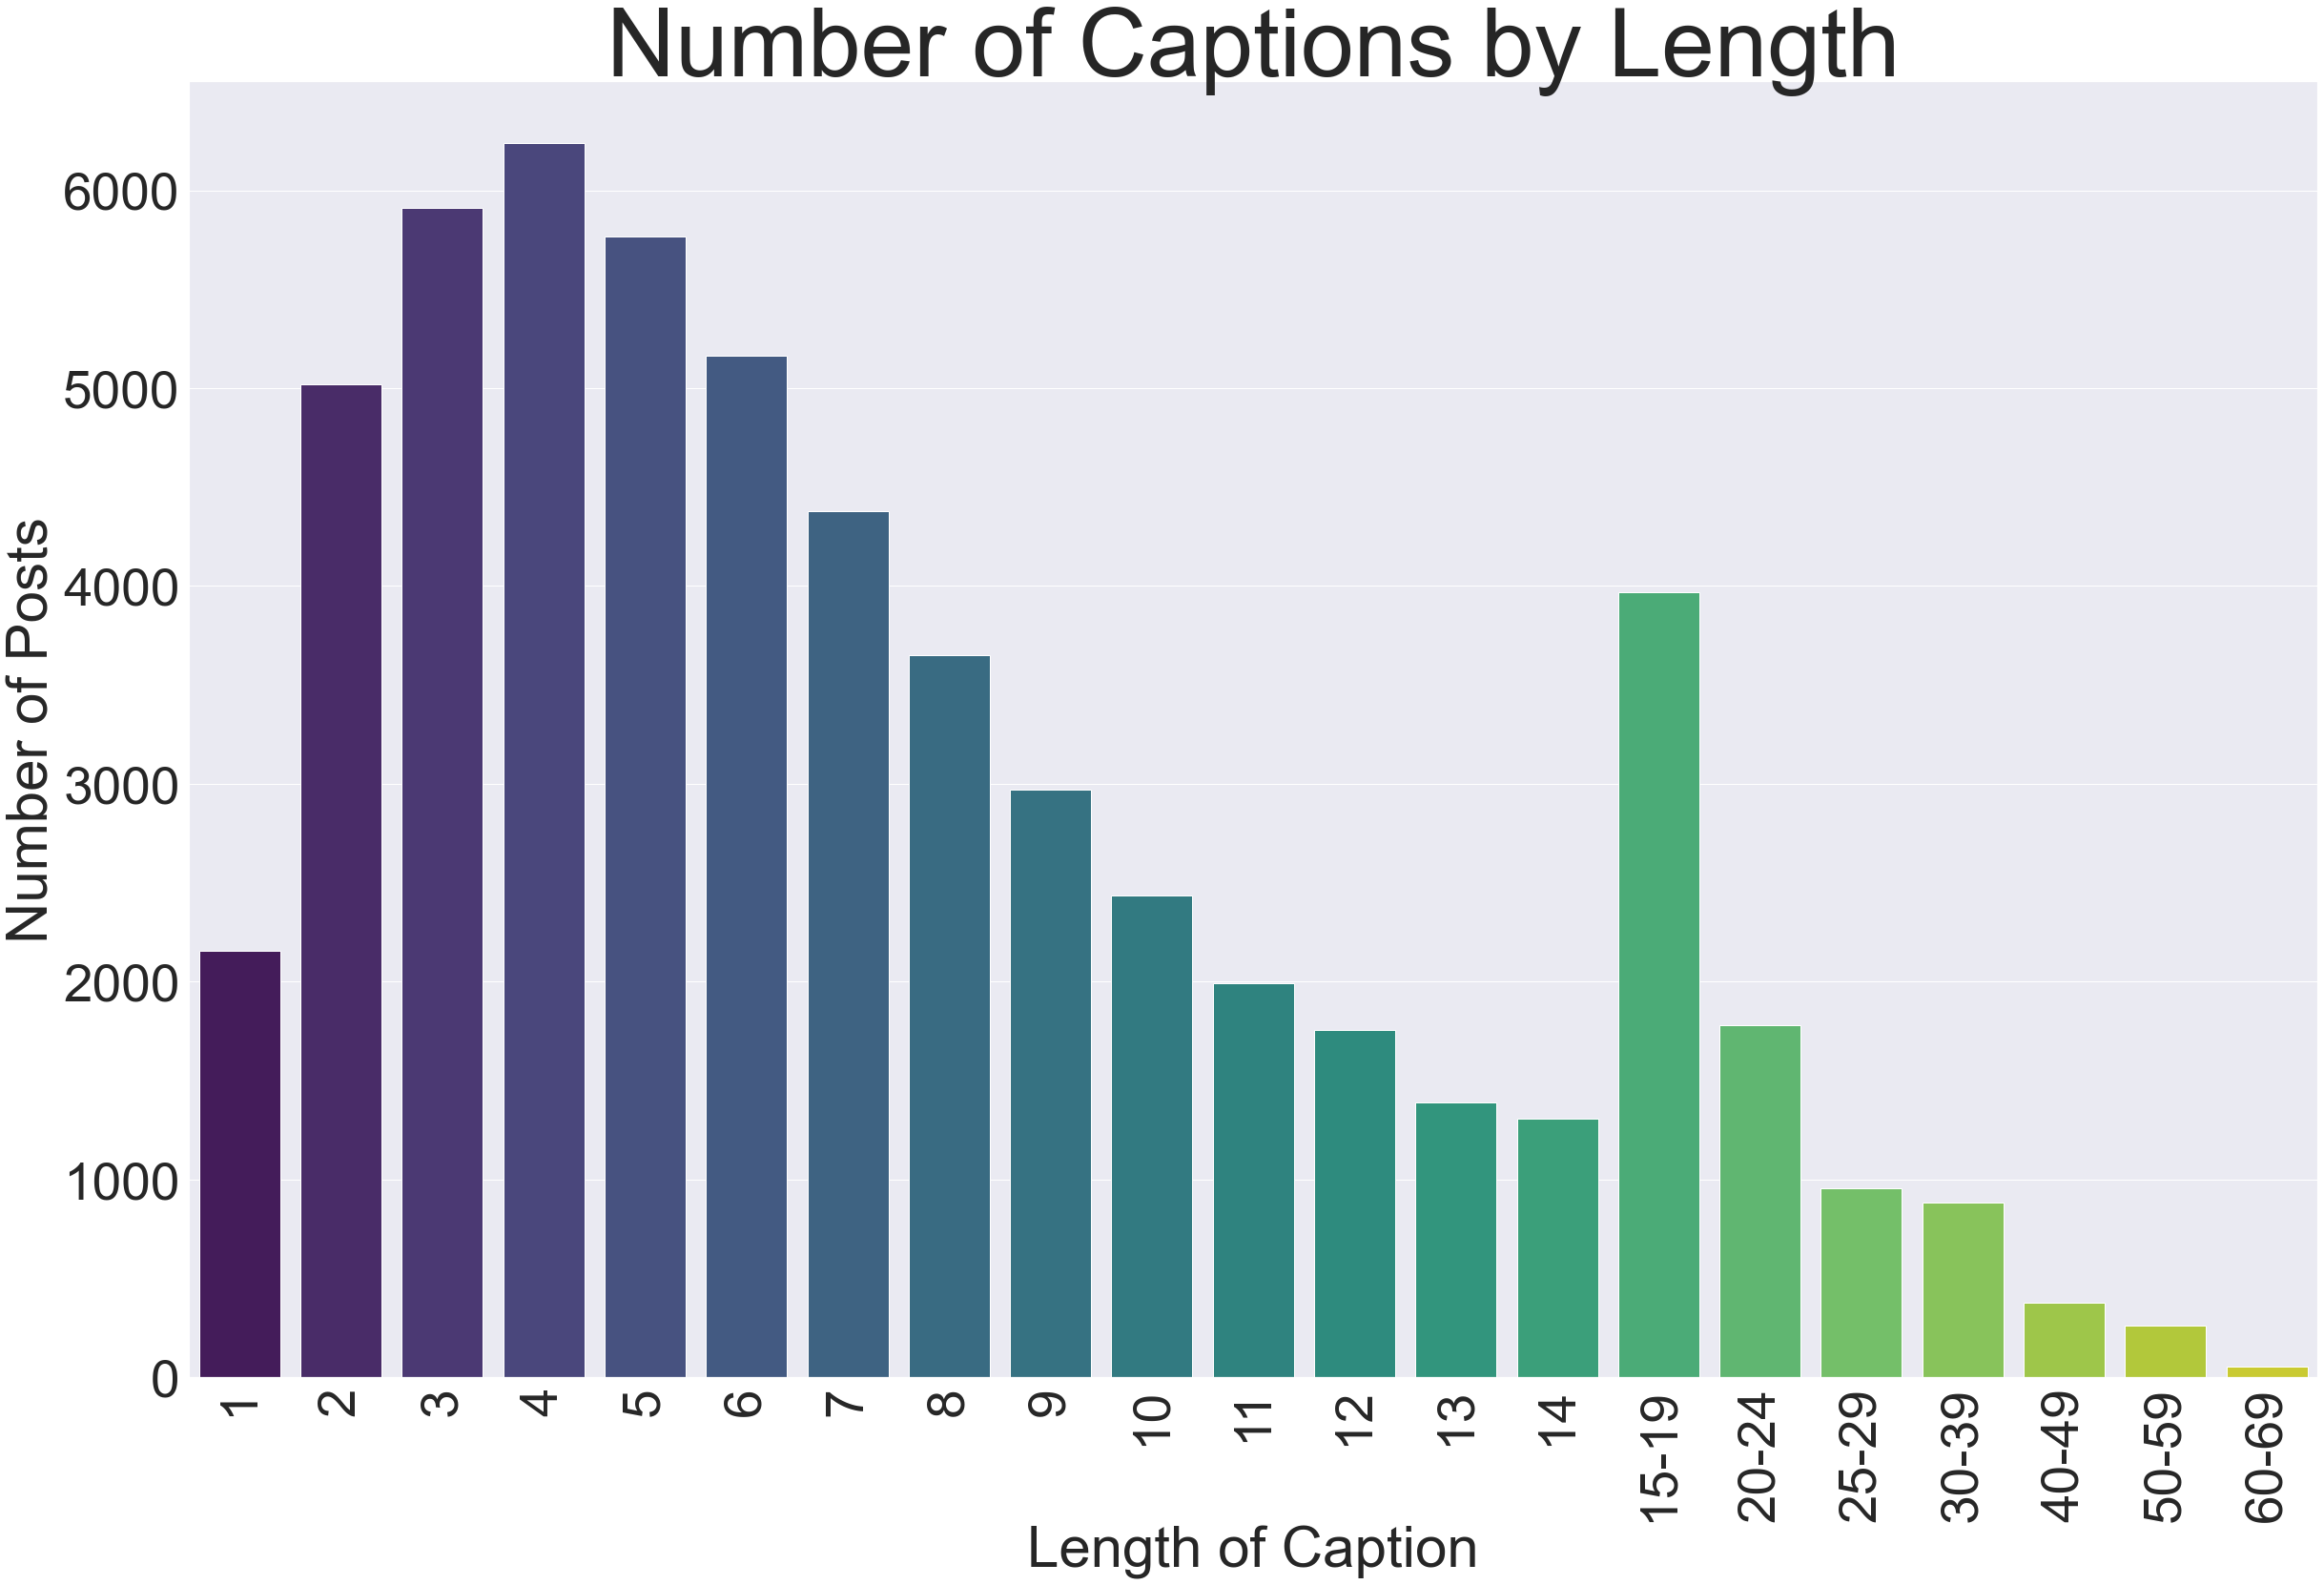

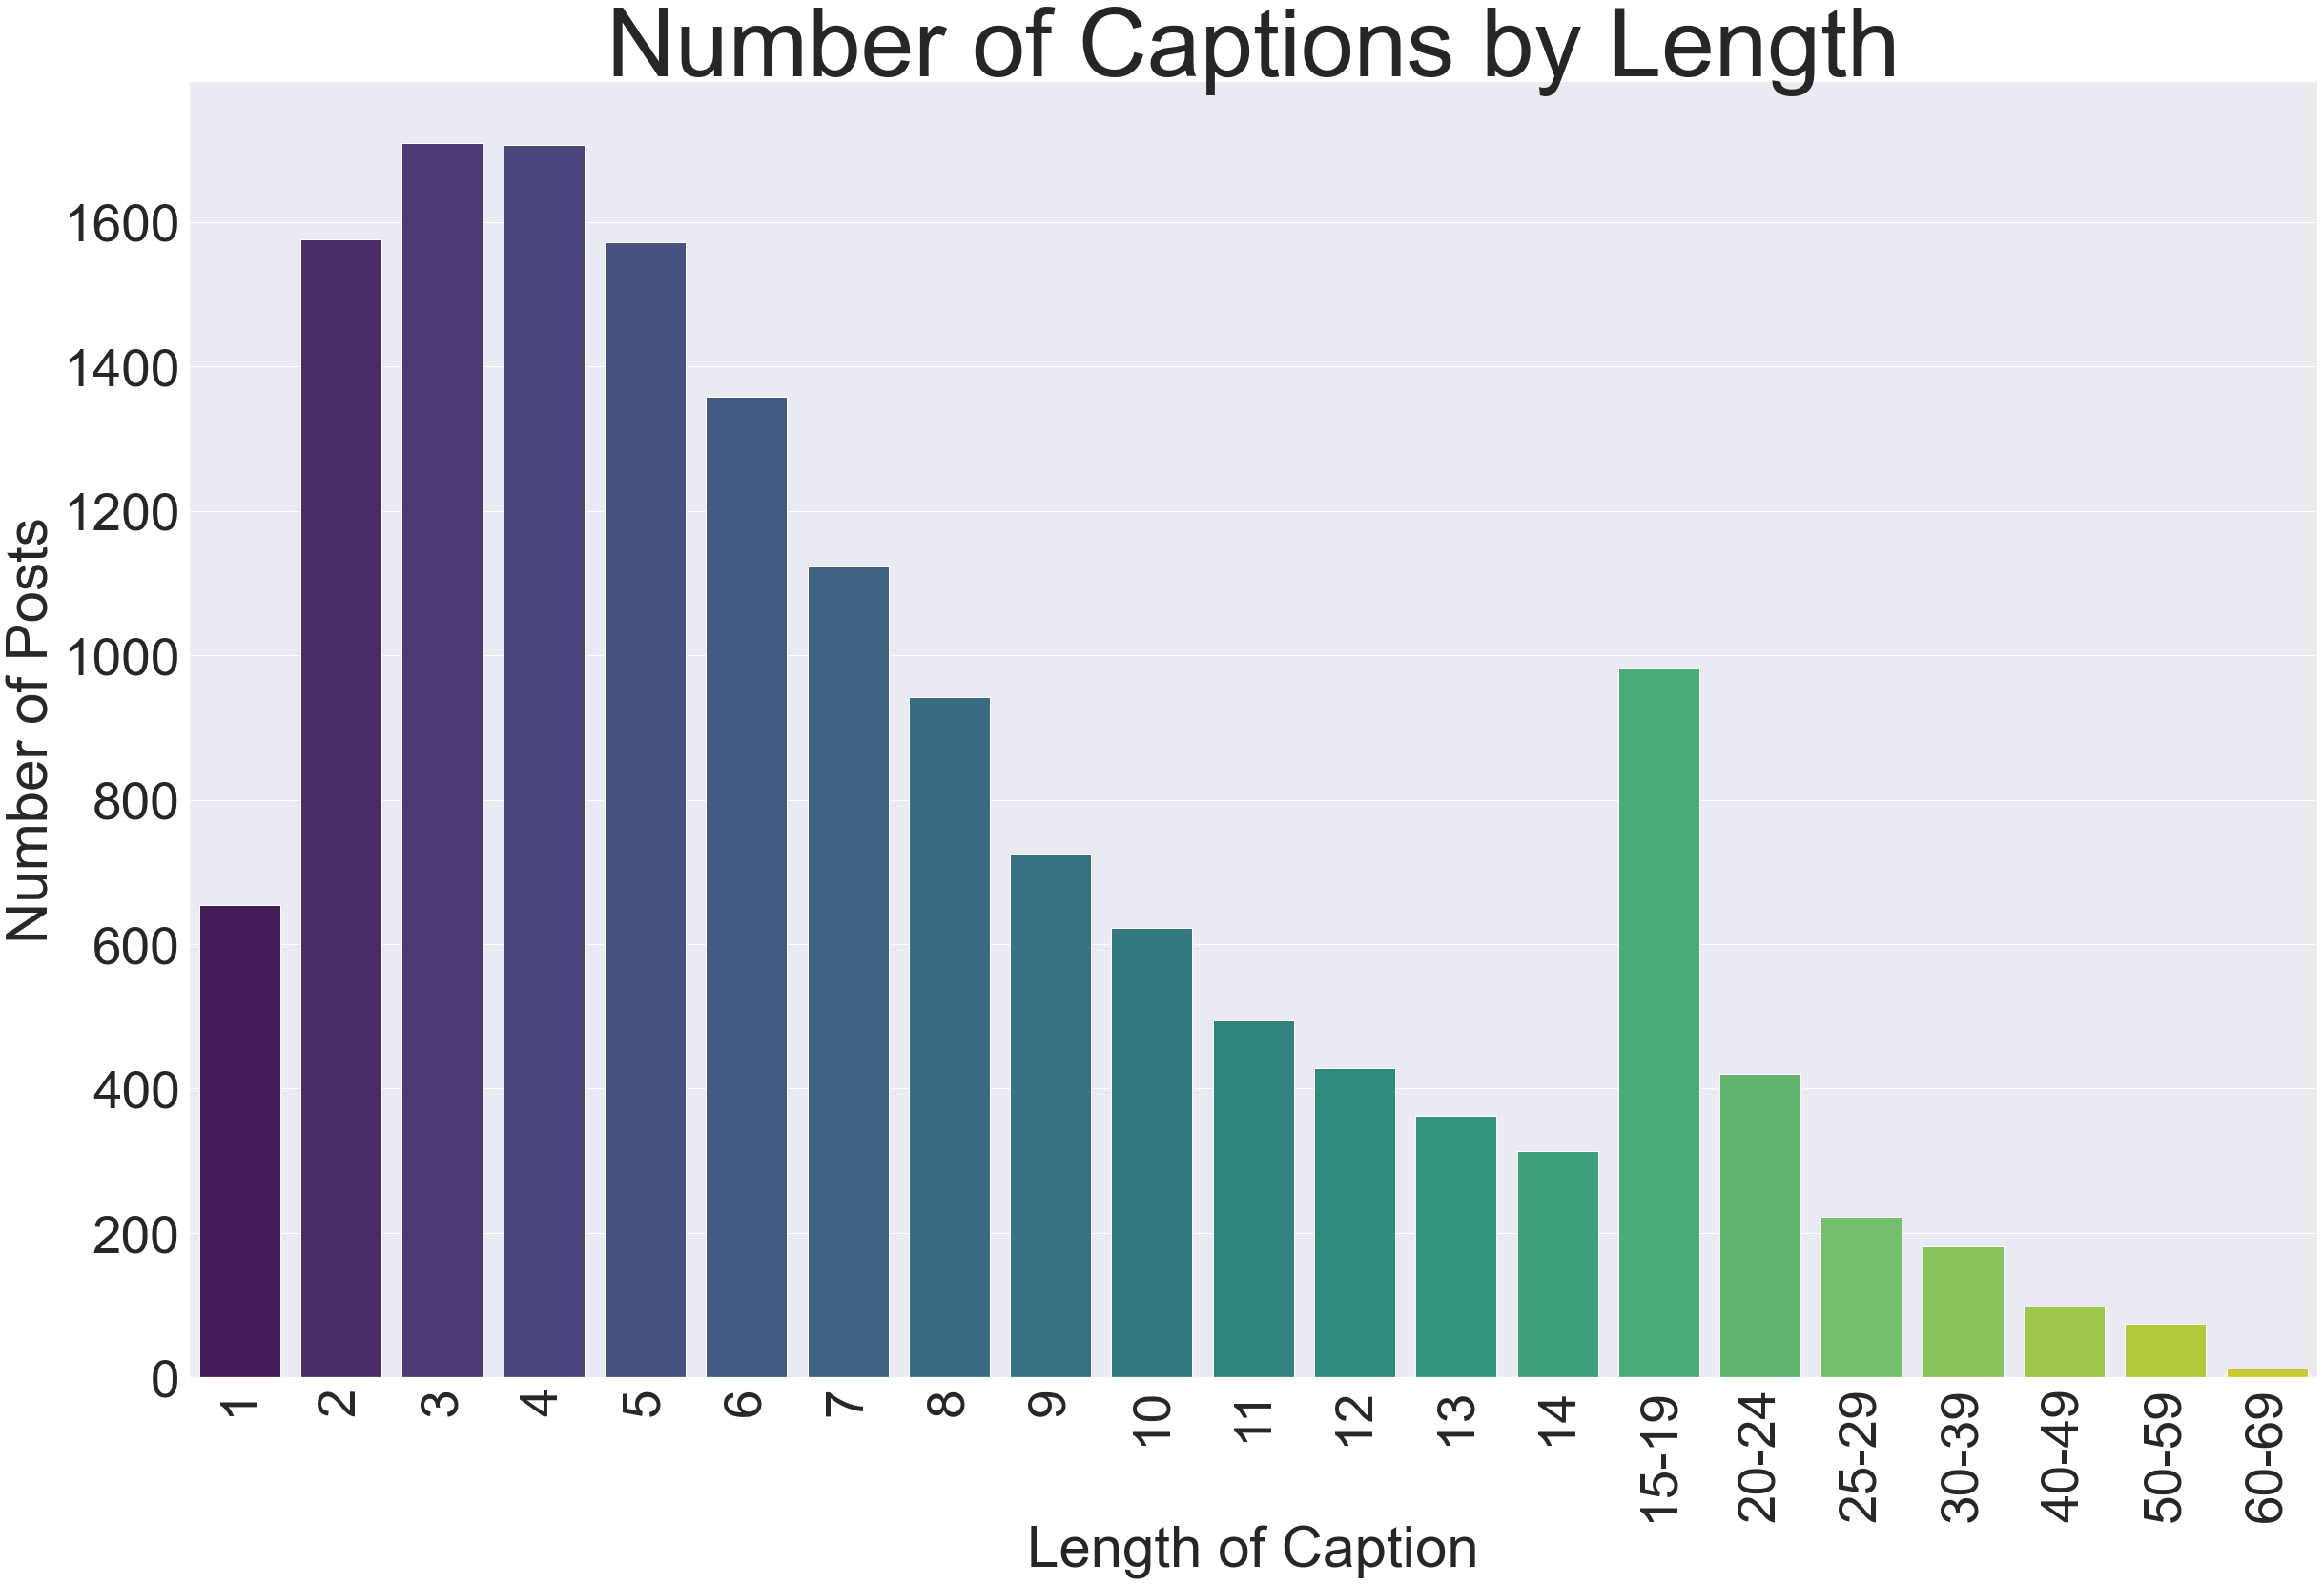

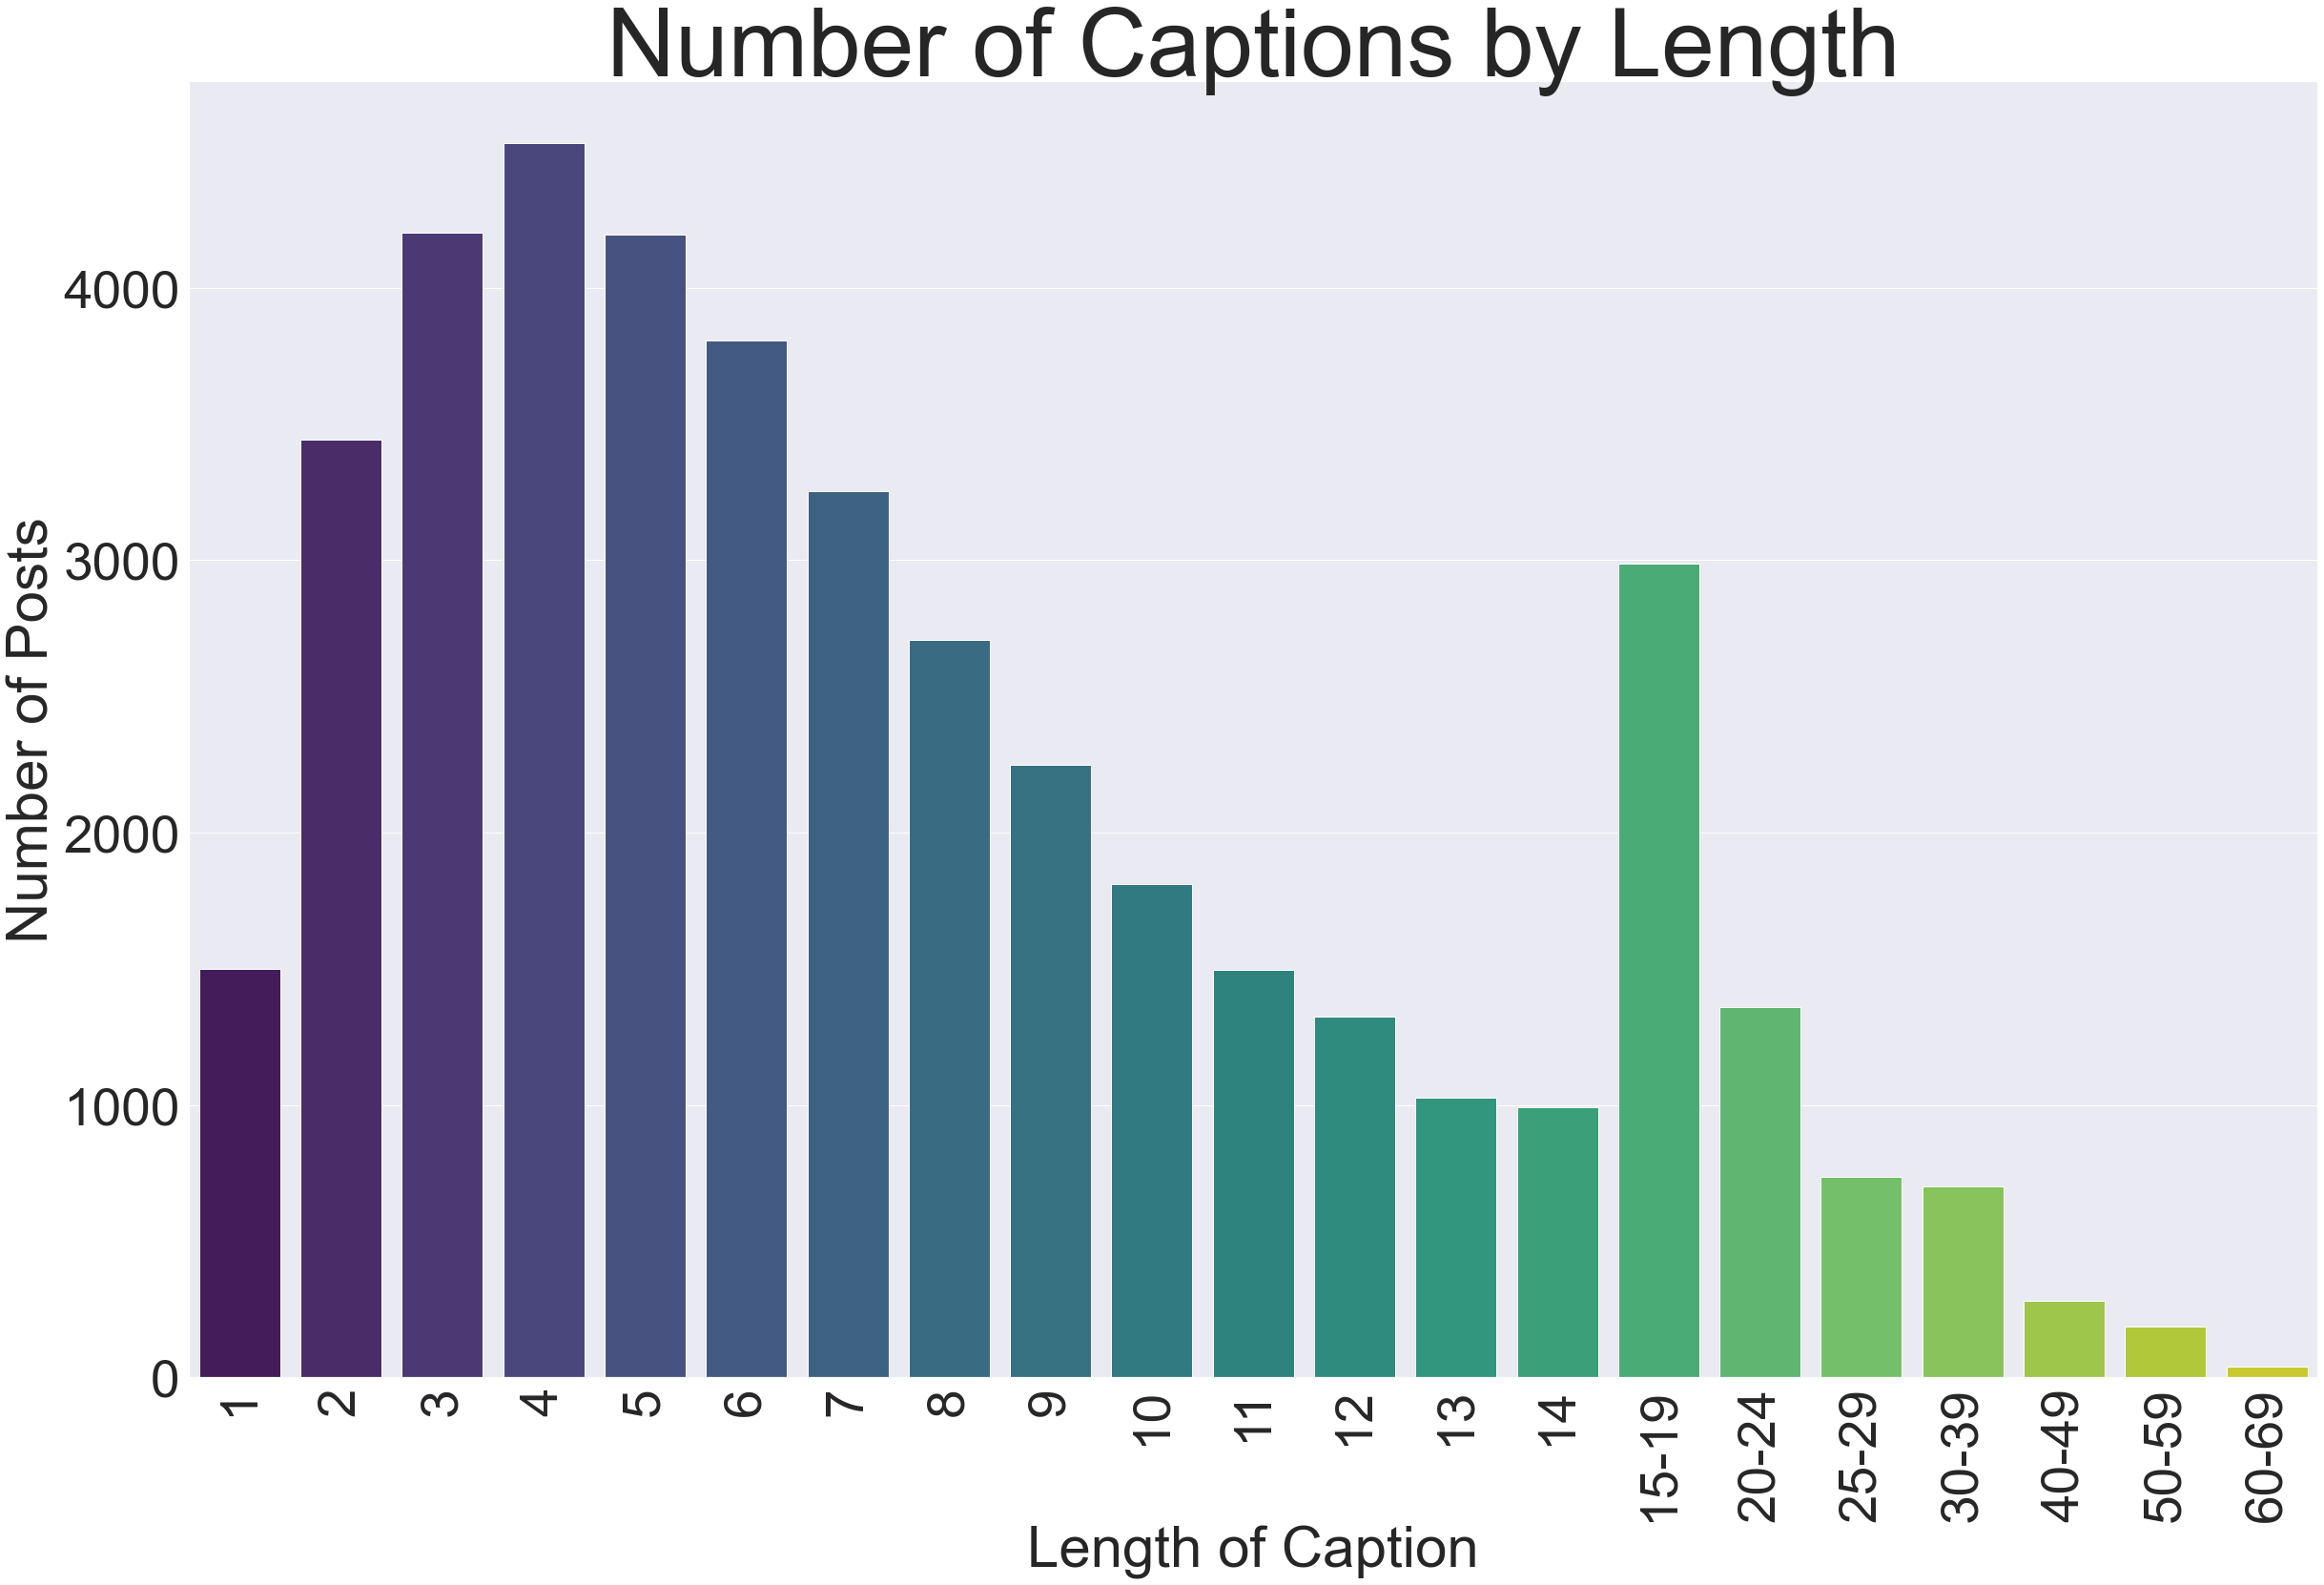

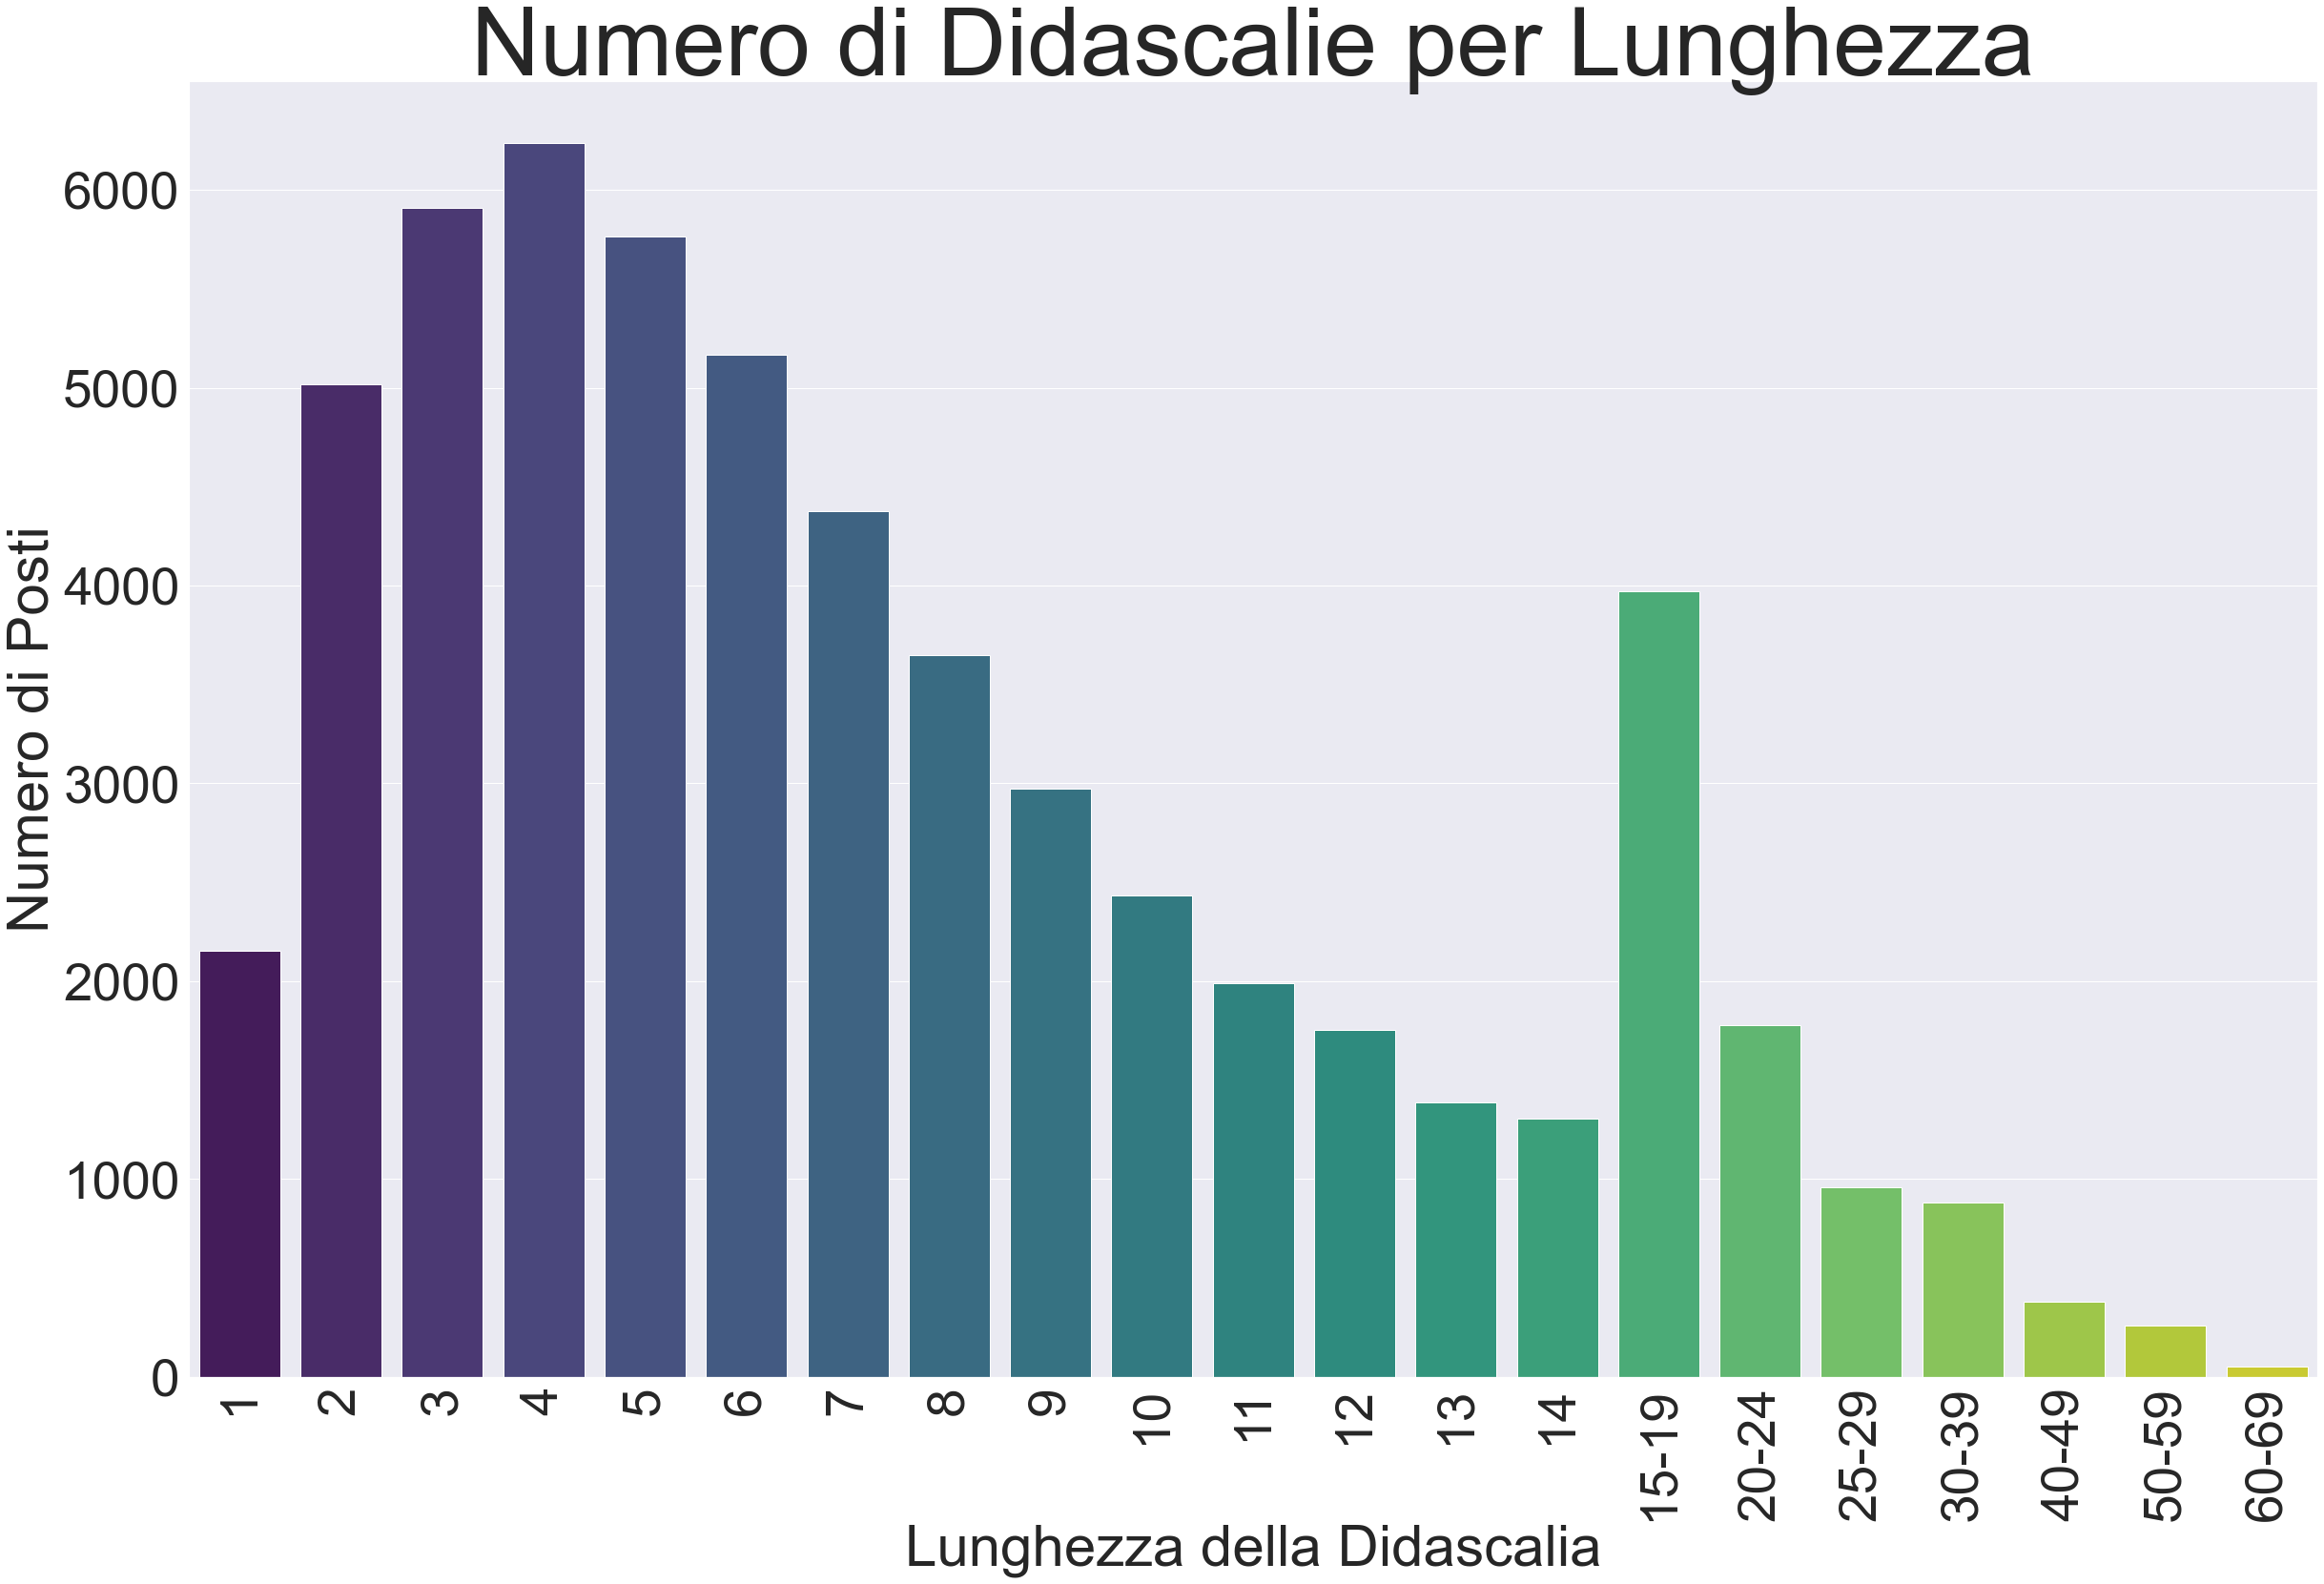

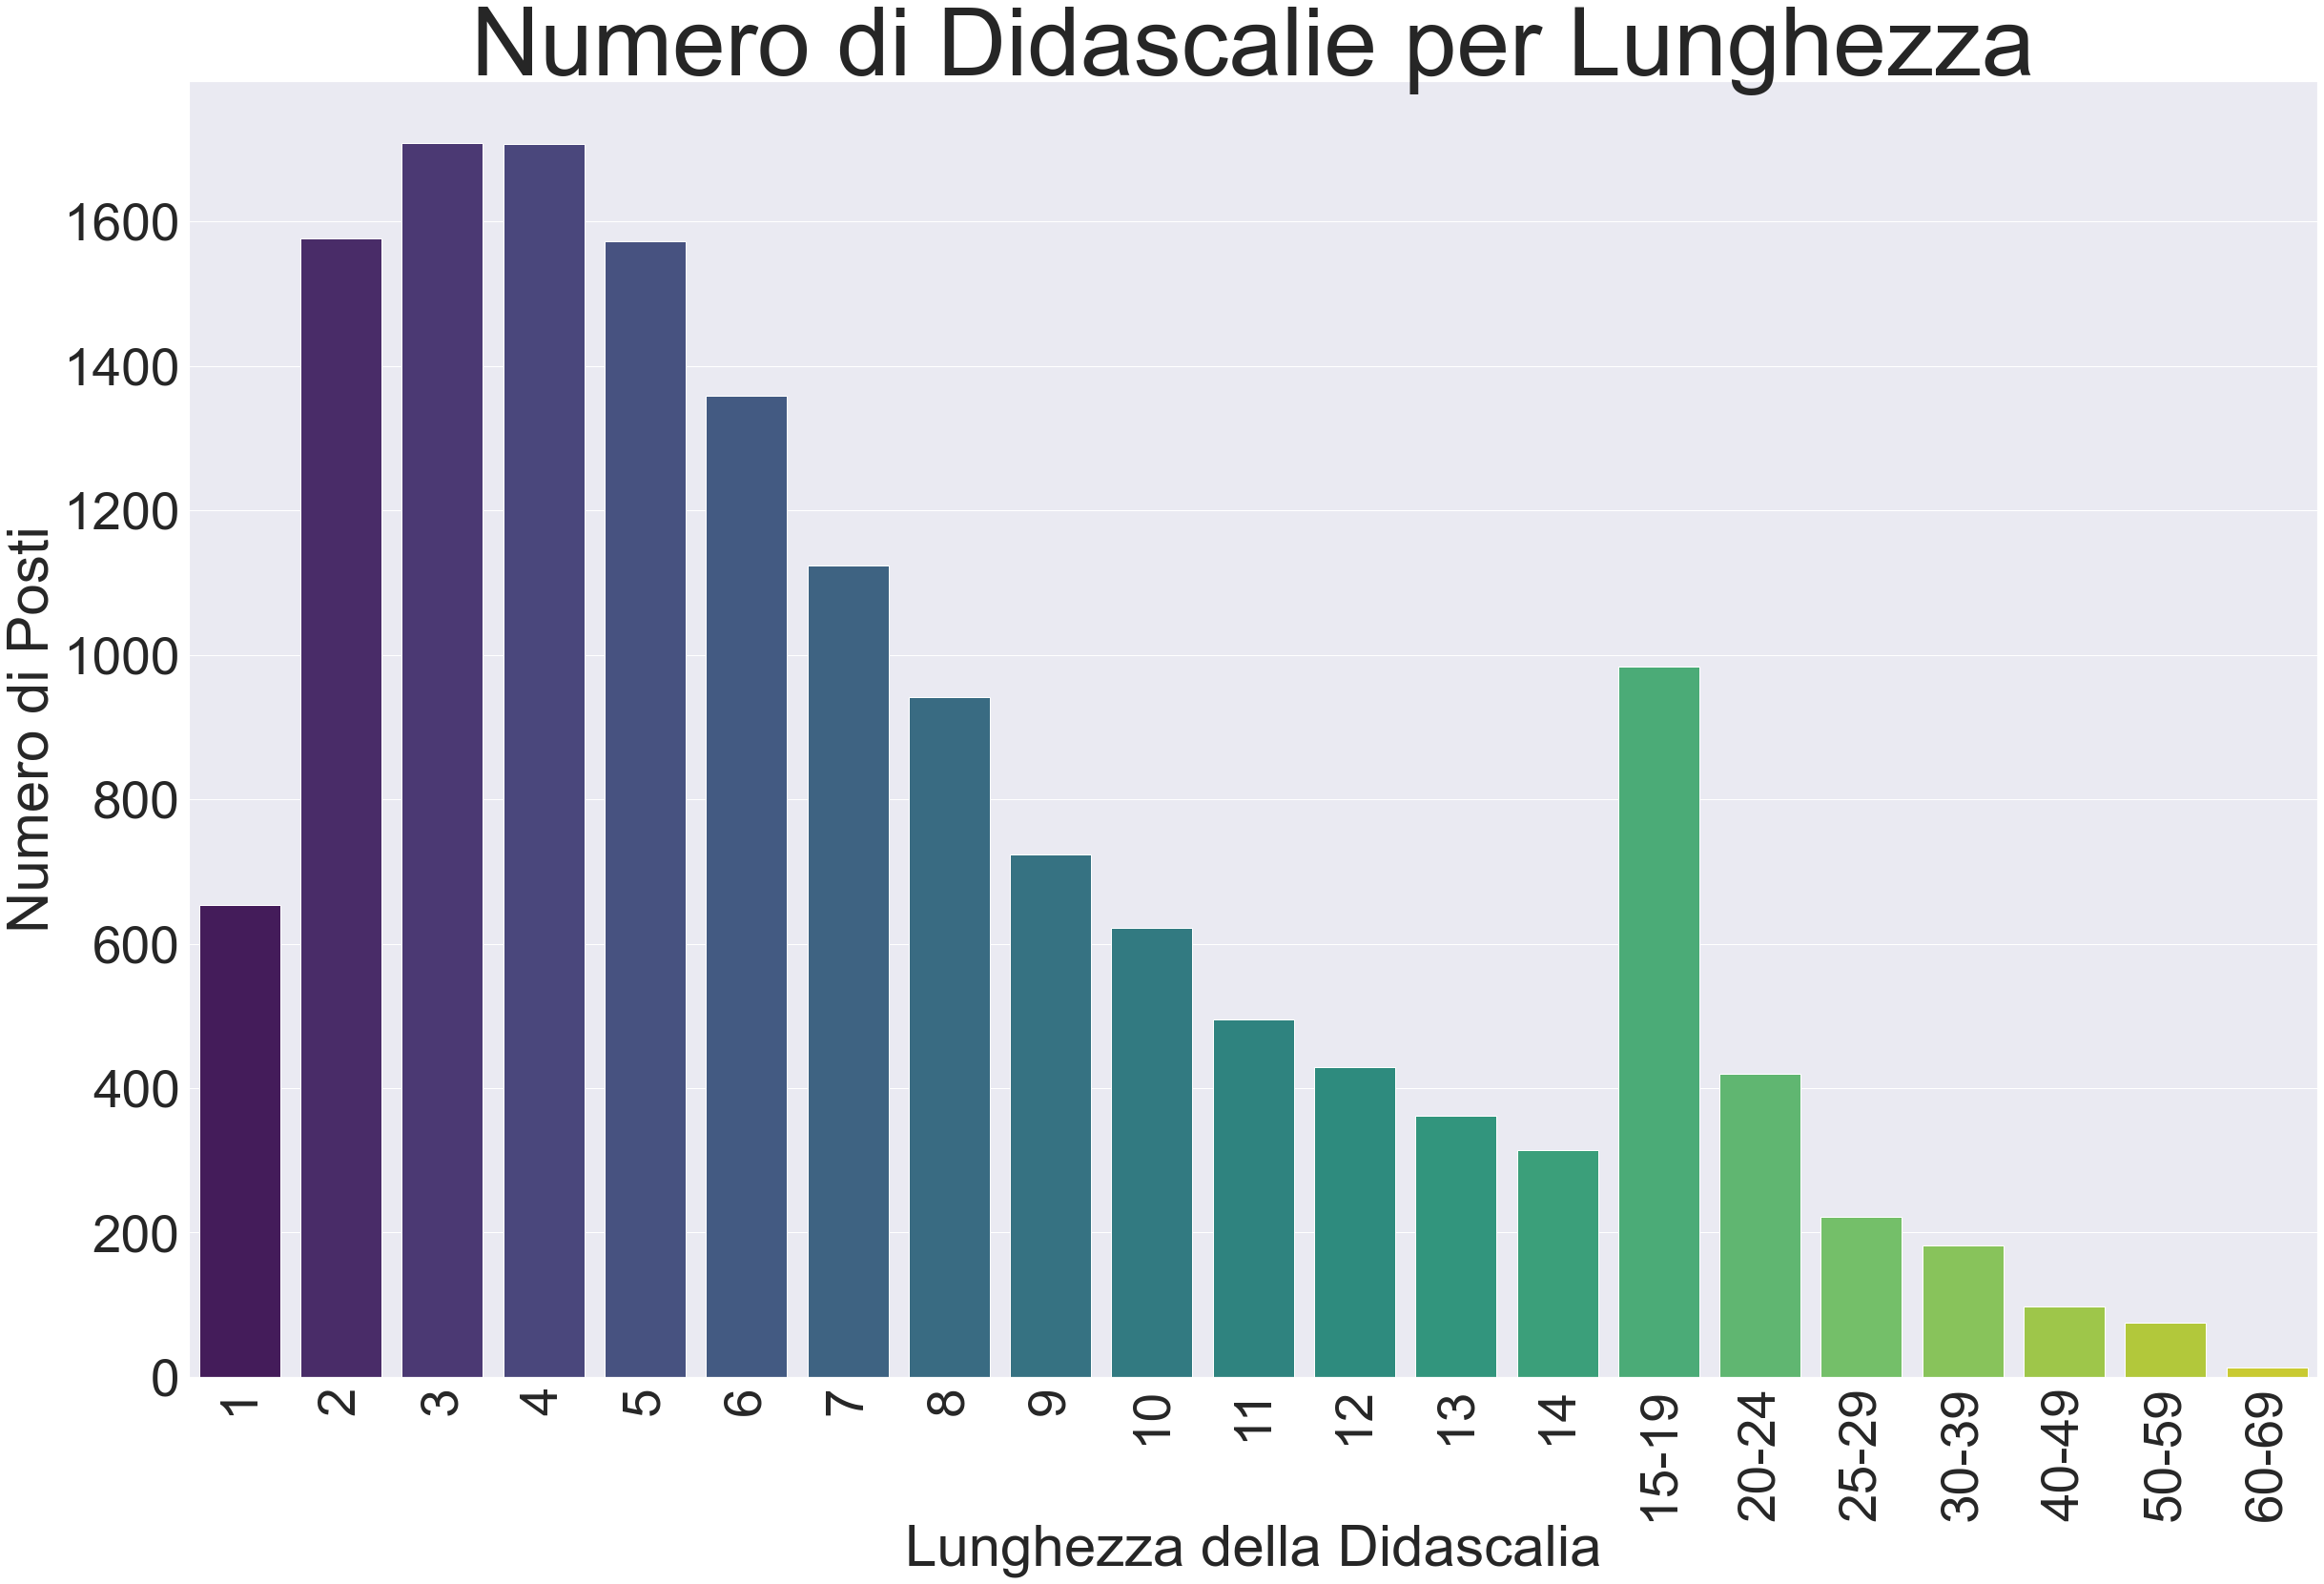

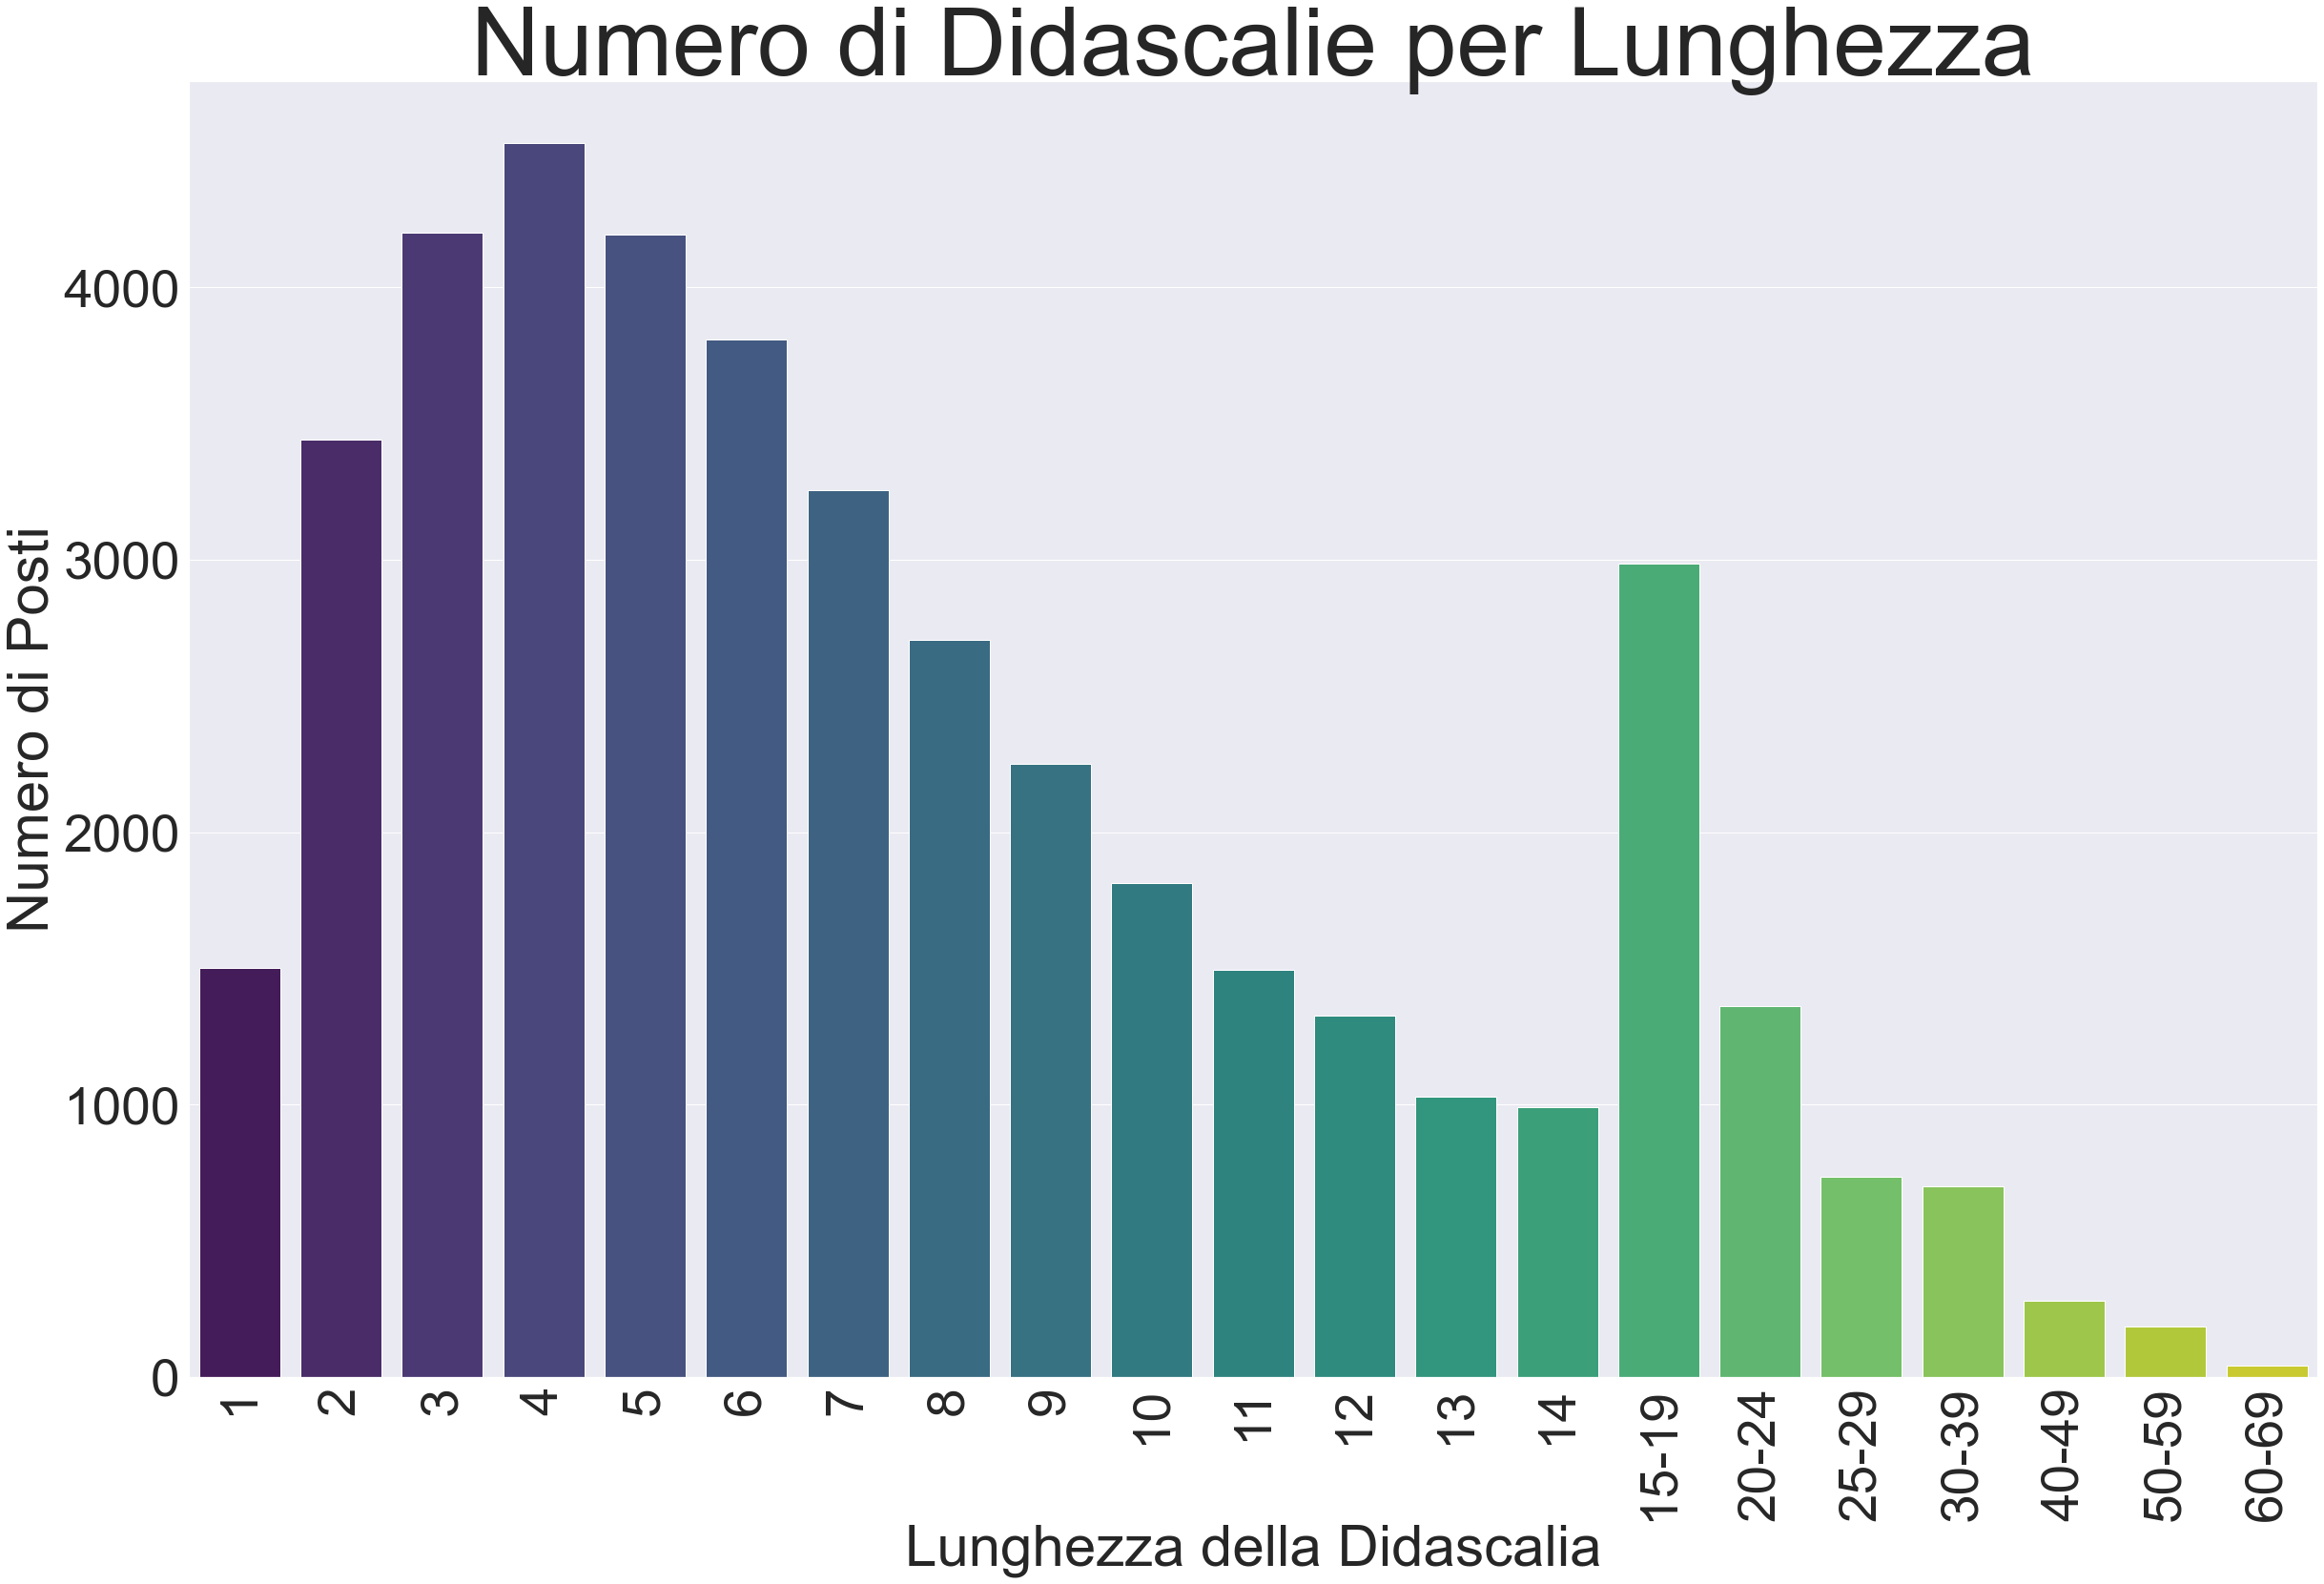

In [67]:

for l in languages:
    for f in ["all","cats","dogs"]:
    
        sns.set(font_scale=5)

        fig1,ax = plt.subplots(figsize=(40,25))

        if f=="all":
            sns.barplot(data=df,ax=ax,x="length",y="target",estimator=len,order=df.sort_values("title_length").length.unique(),palette="viridis")
        else:
            sns.barplot(data=df[df.category==f],ax=ax,x="length",y="target",estimator=len,order=df.sort_values("title_length").length.unique(),palette="viridis")
        
        if l=="English":
            plt.title("Number of Captions by Length",fontsize=100)
            plt.xlabel("Length of Caption")
            plt.ylabel("Number of Posts")
        else:
            plt.title("Numero di Didascalie per Lunghezza",fontsize=100)
            plt.xlabel("Lunghezza della Didascalia")
            plt.ylabel("Numero di Posti")
        plt.xticks(rotation = 90)
        
        plt.savefig(f'appdata/captionlength_count_{l.lower()}_{f}.png')

#### Popularity of posts by length

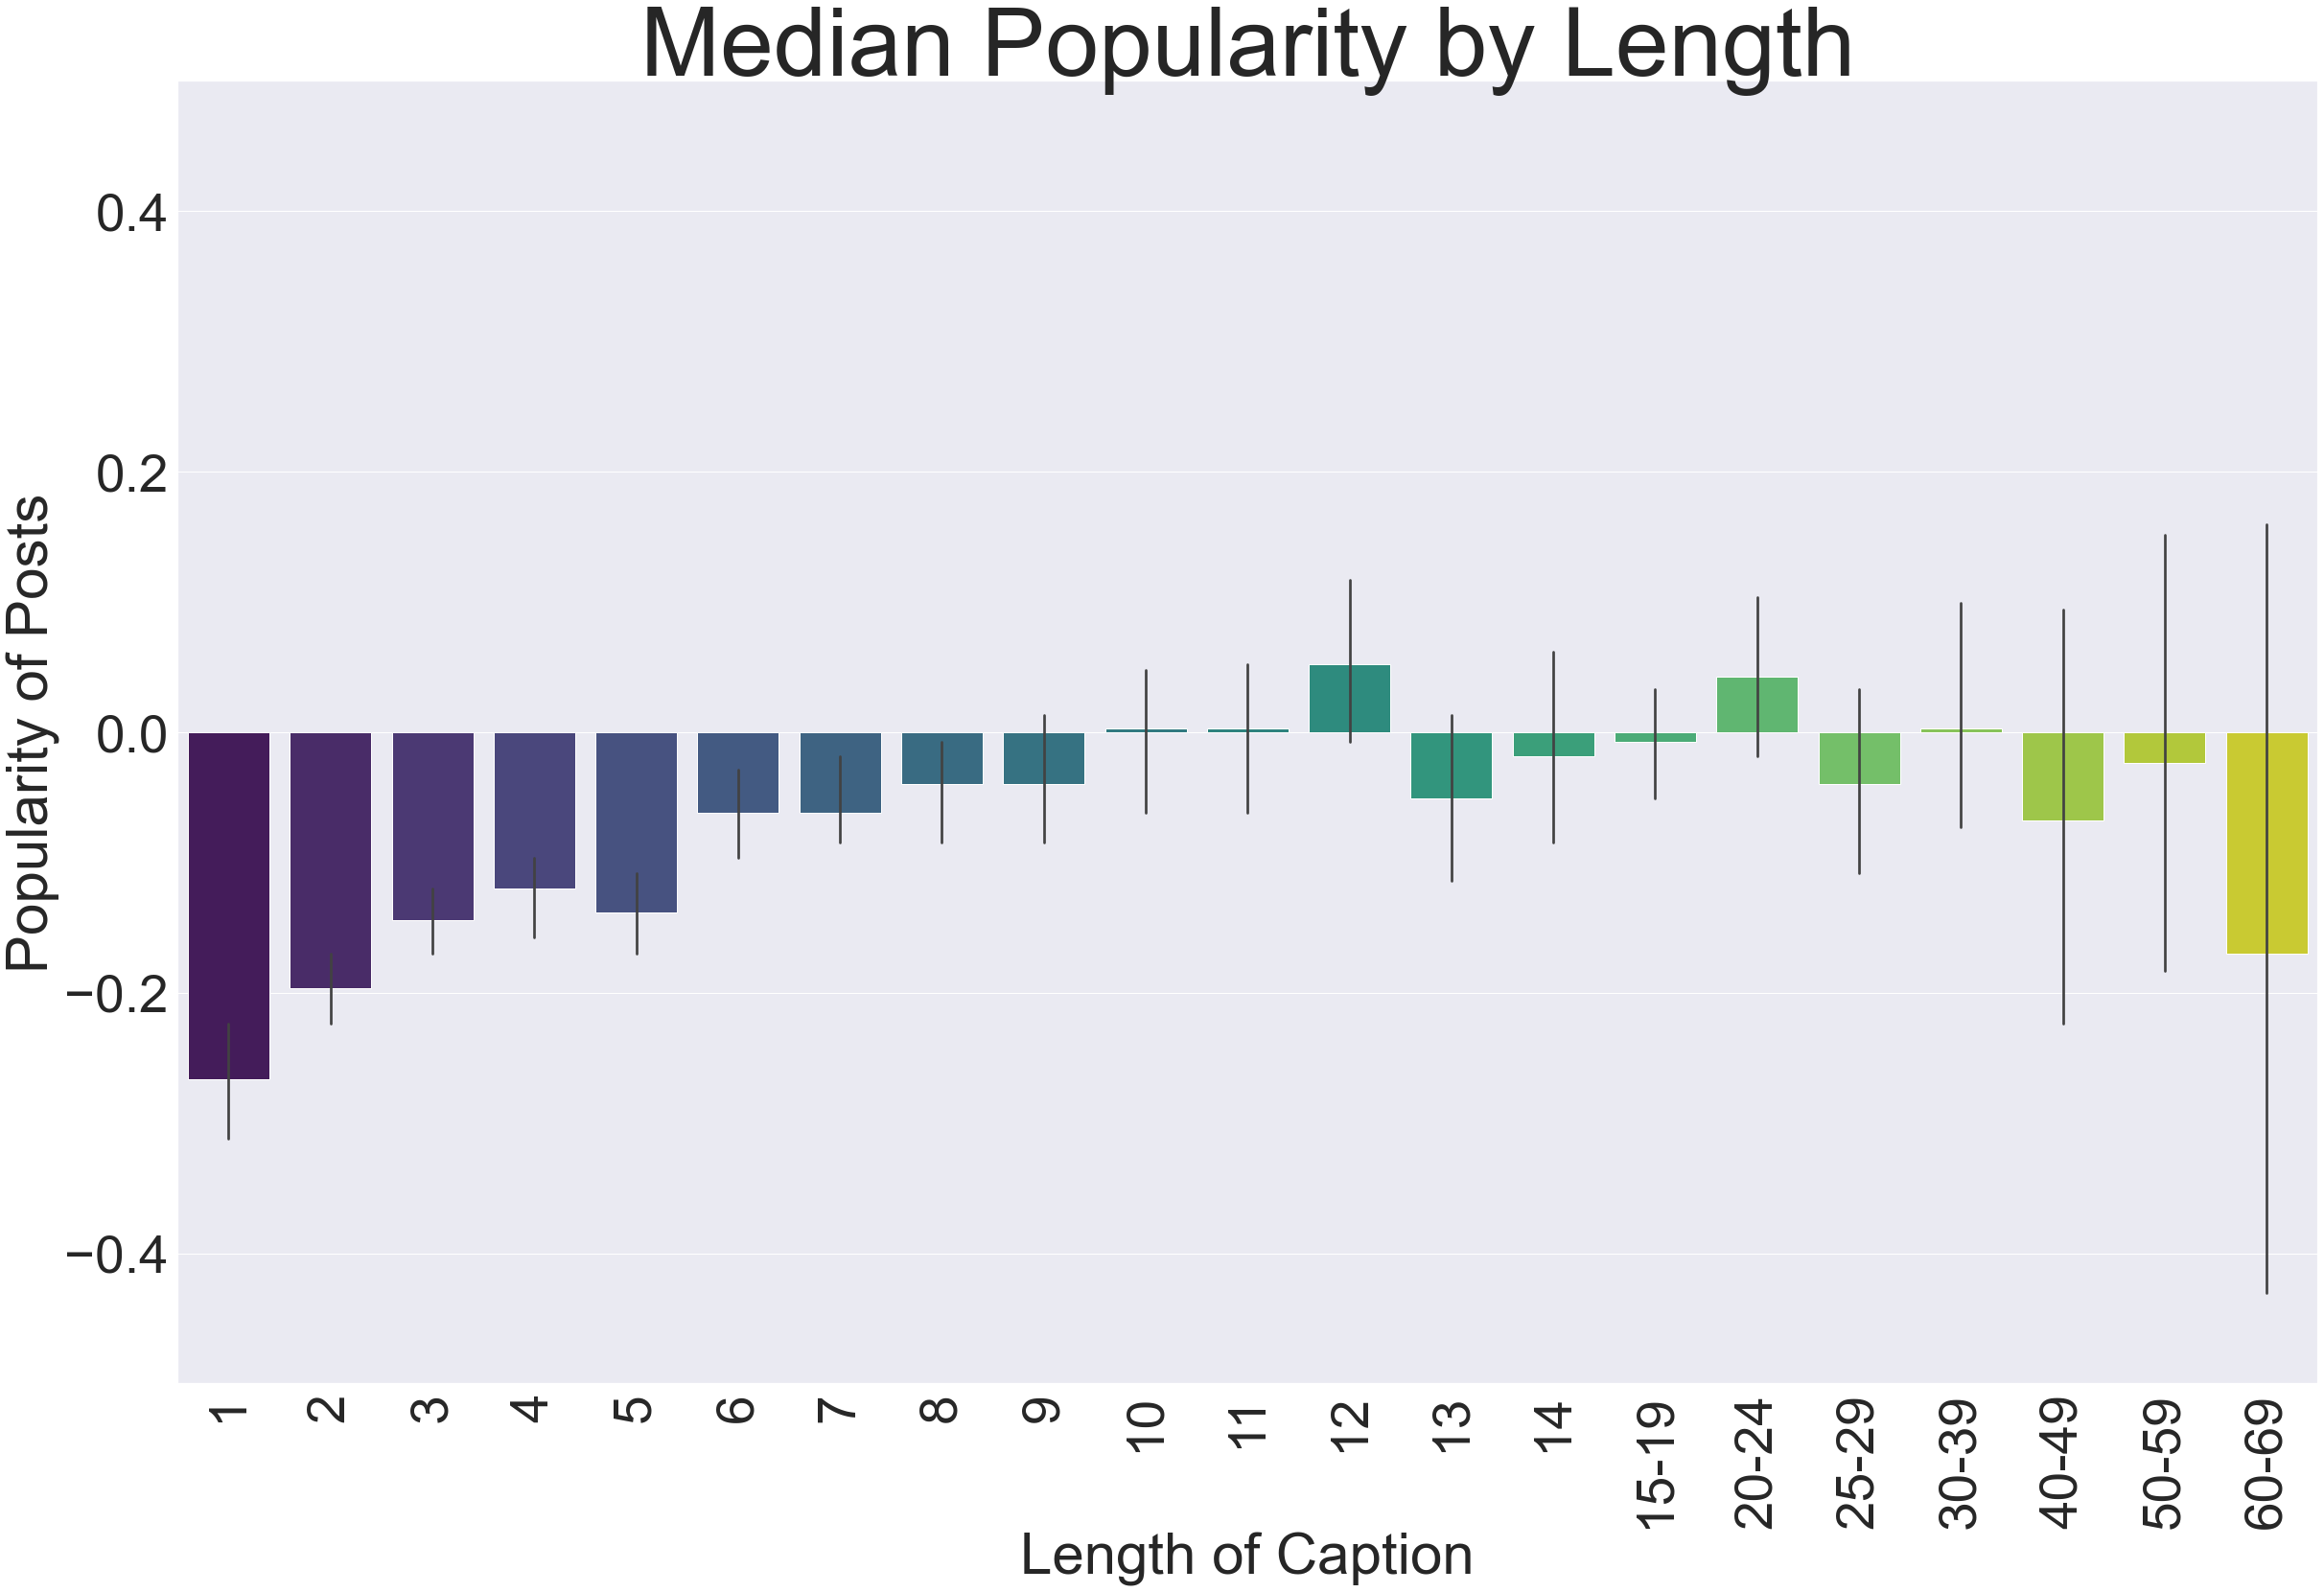

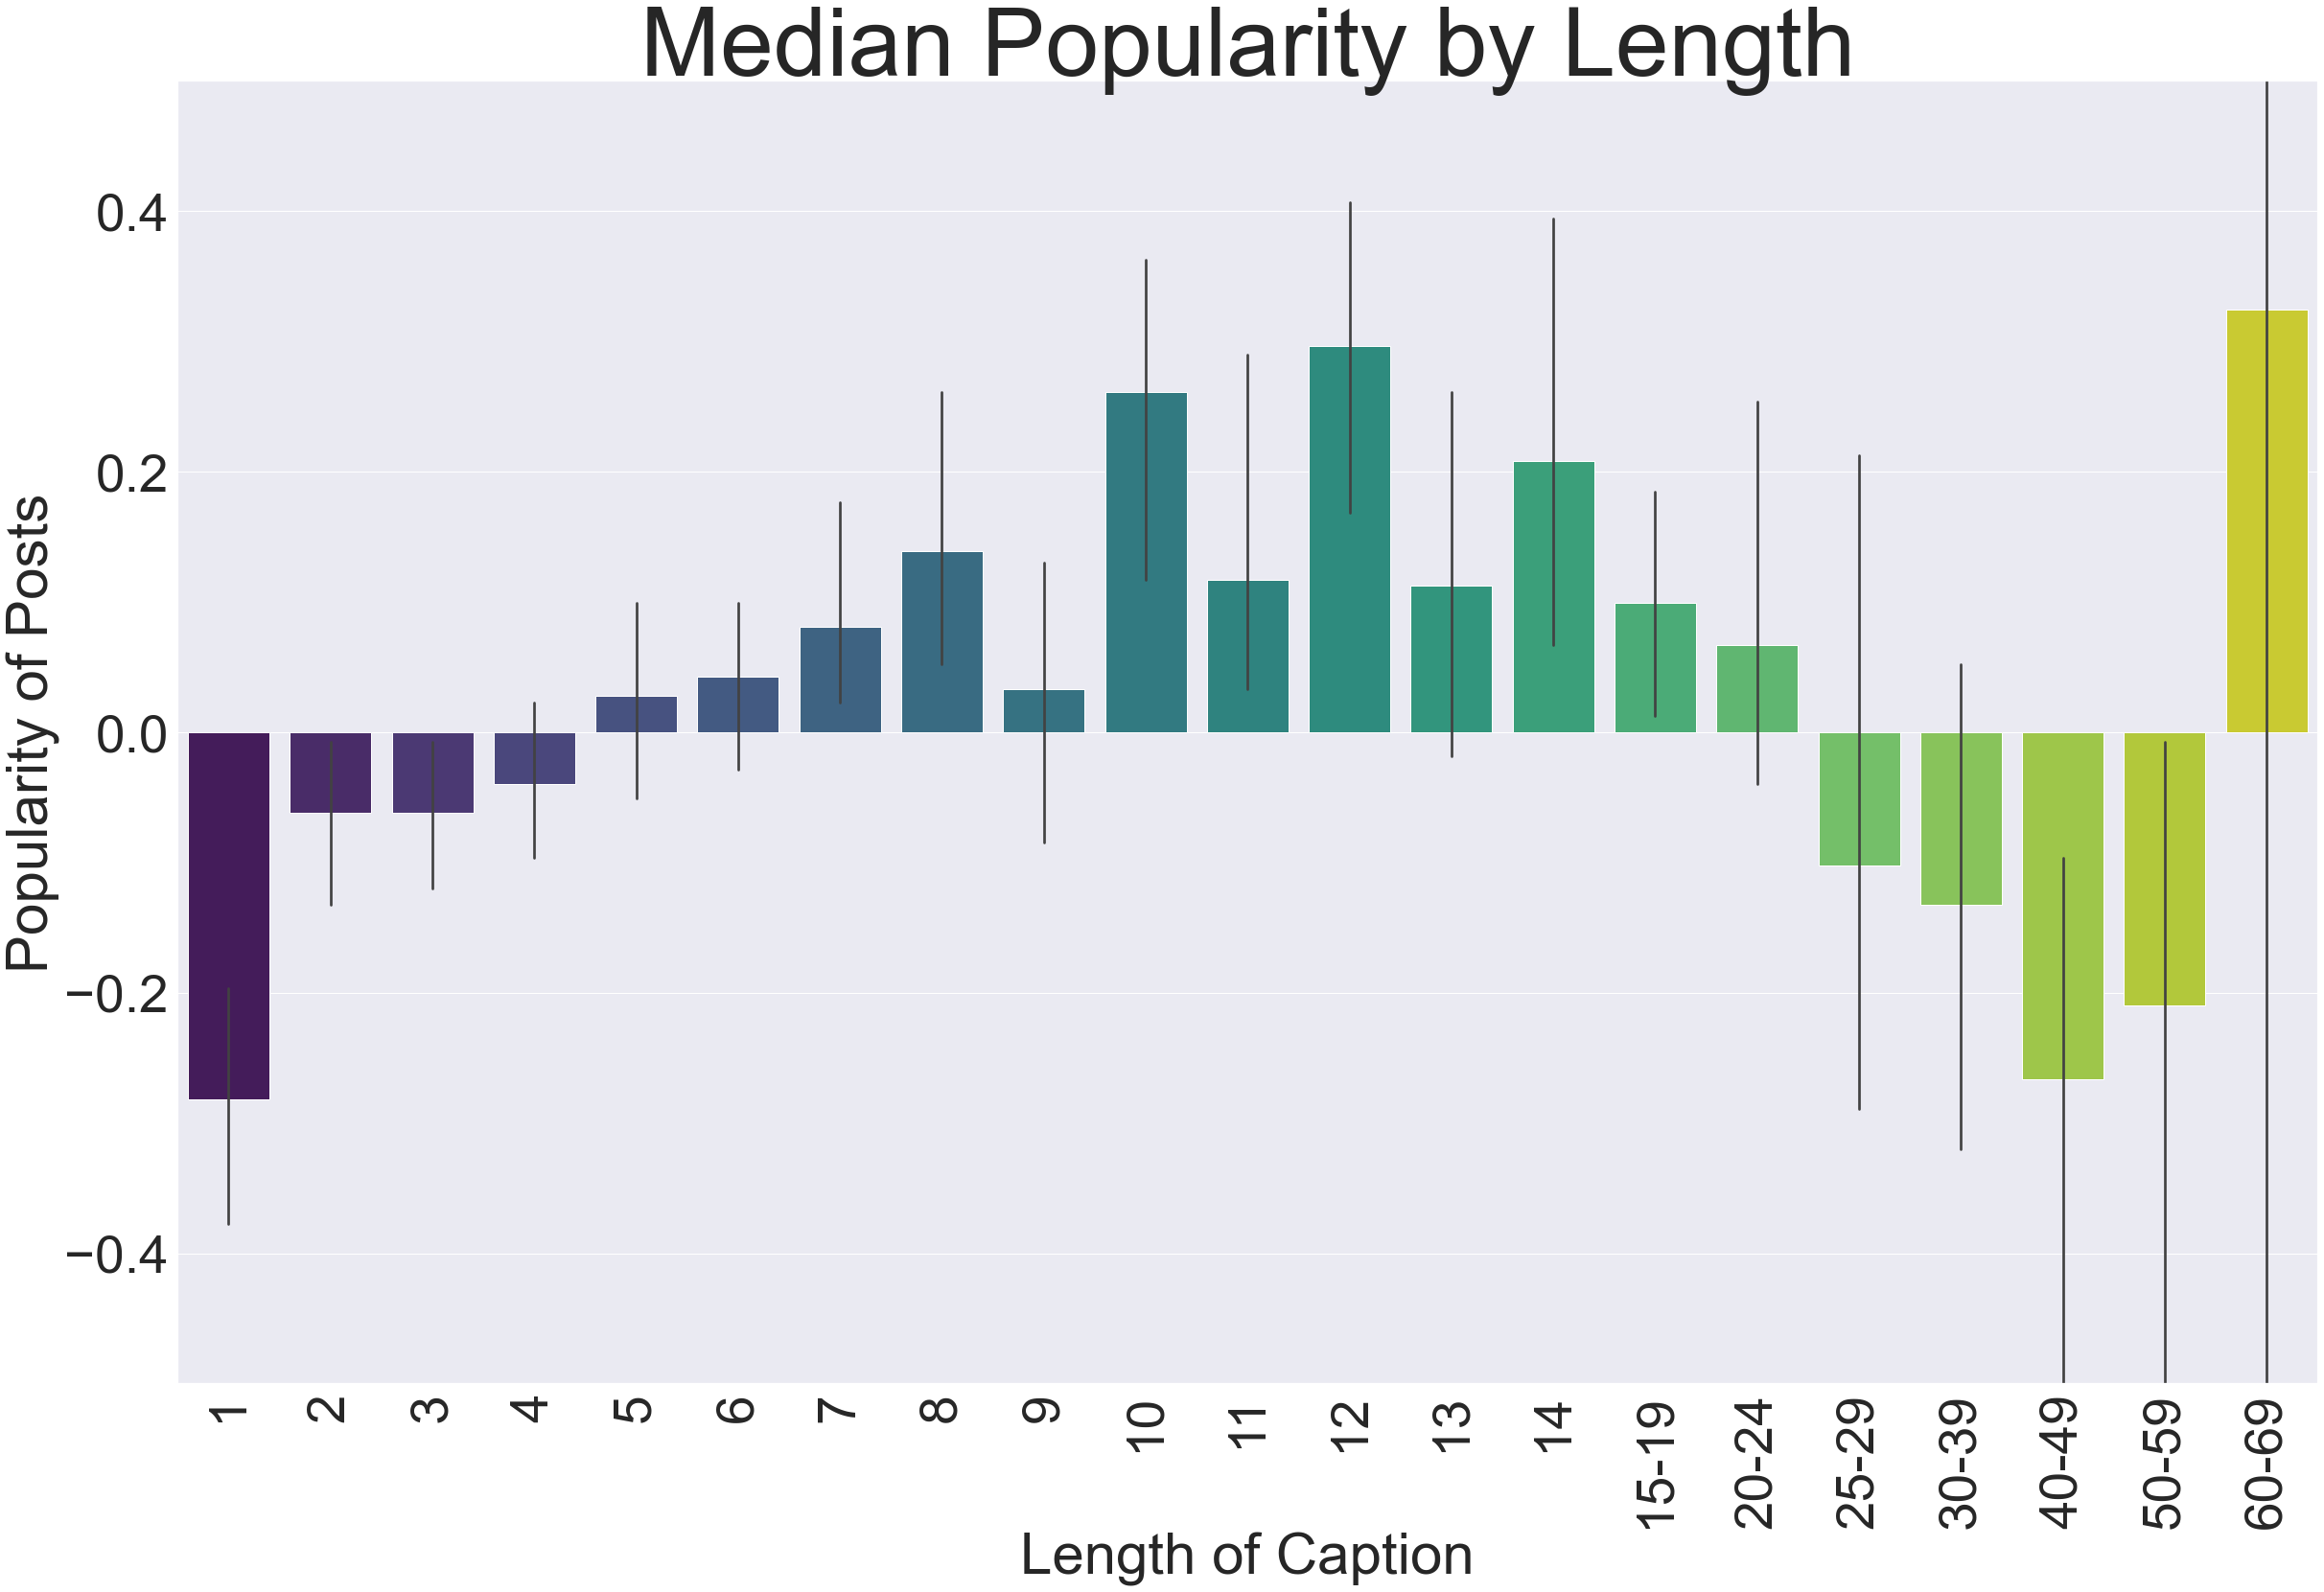

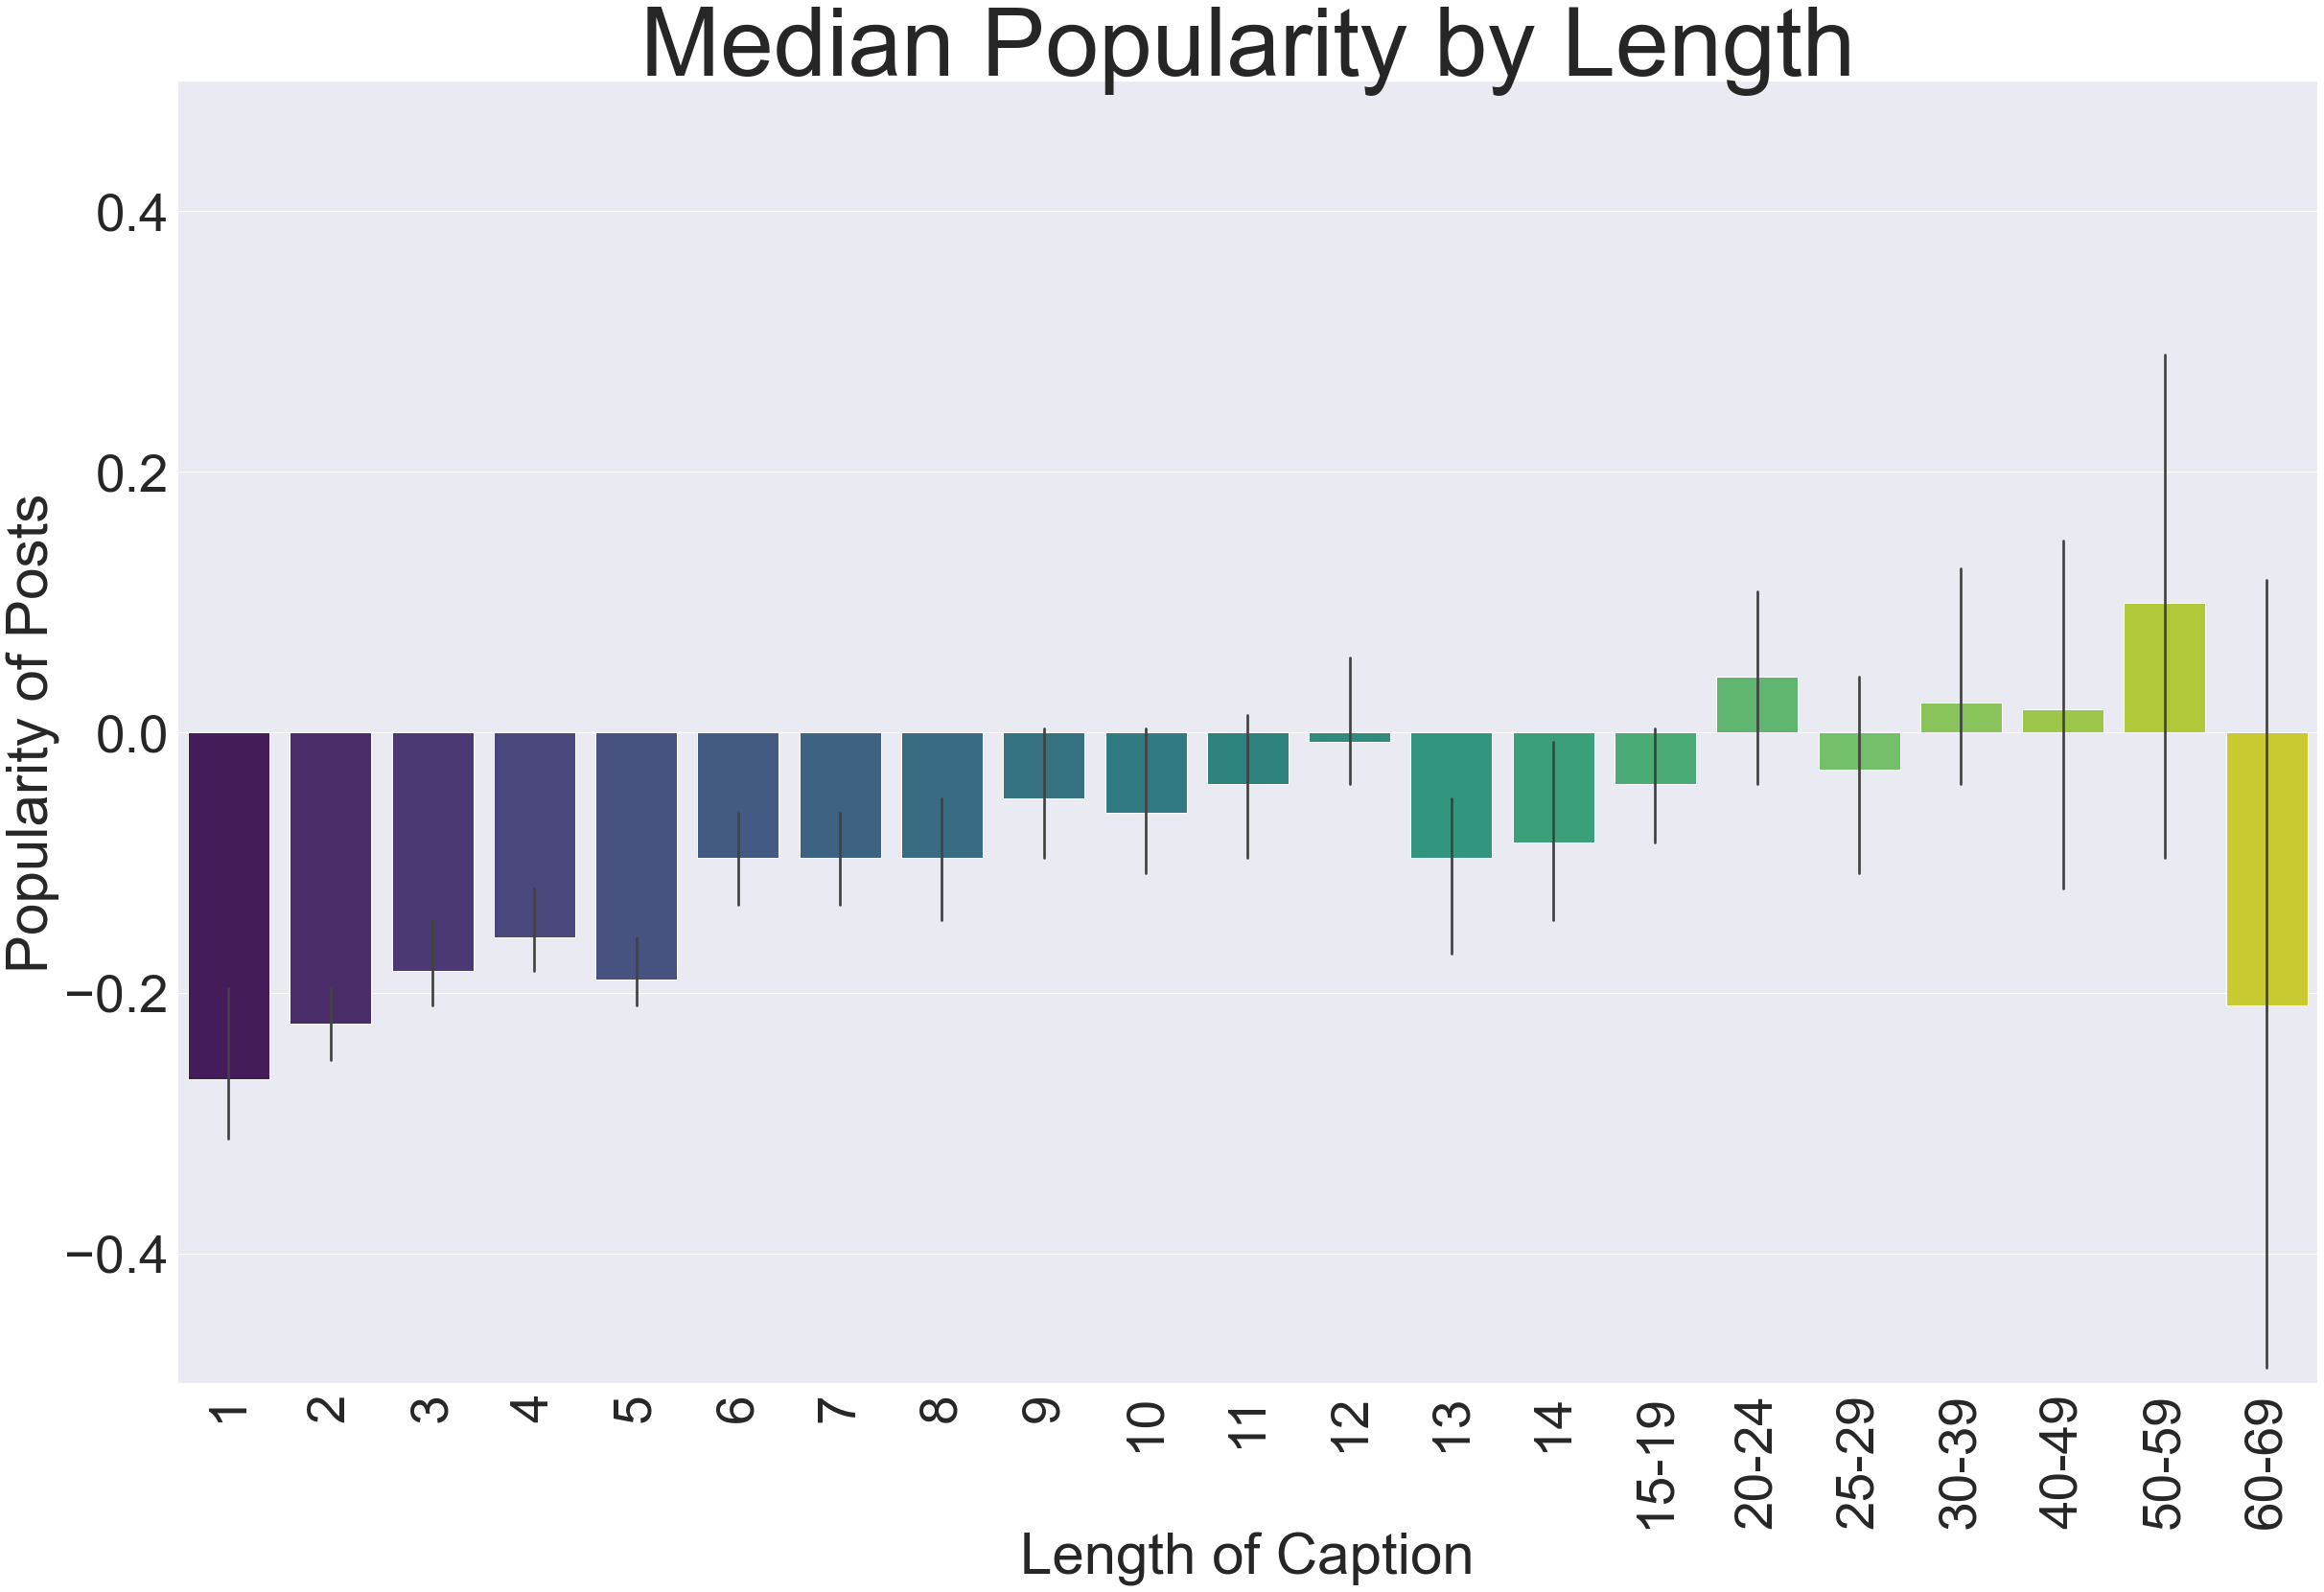

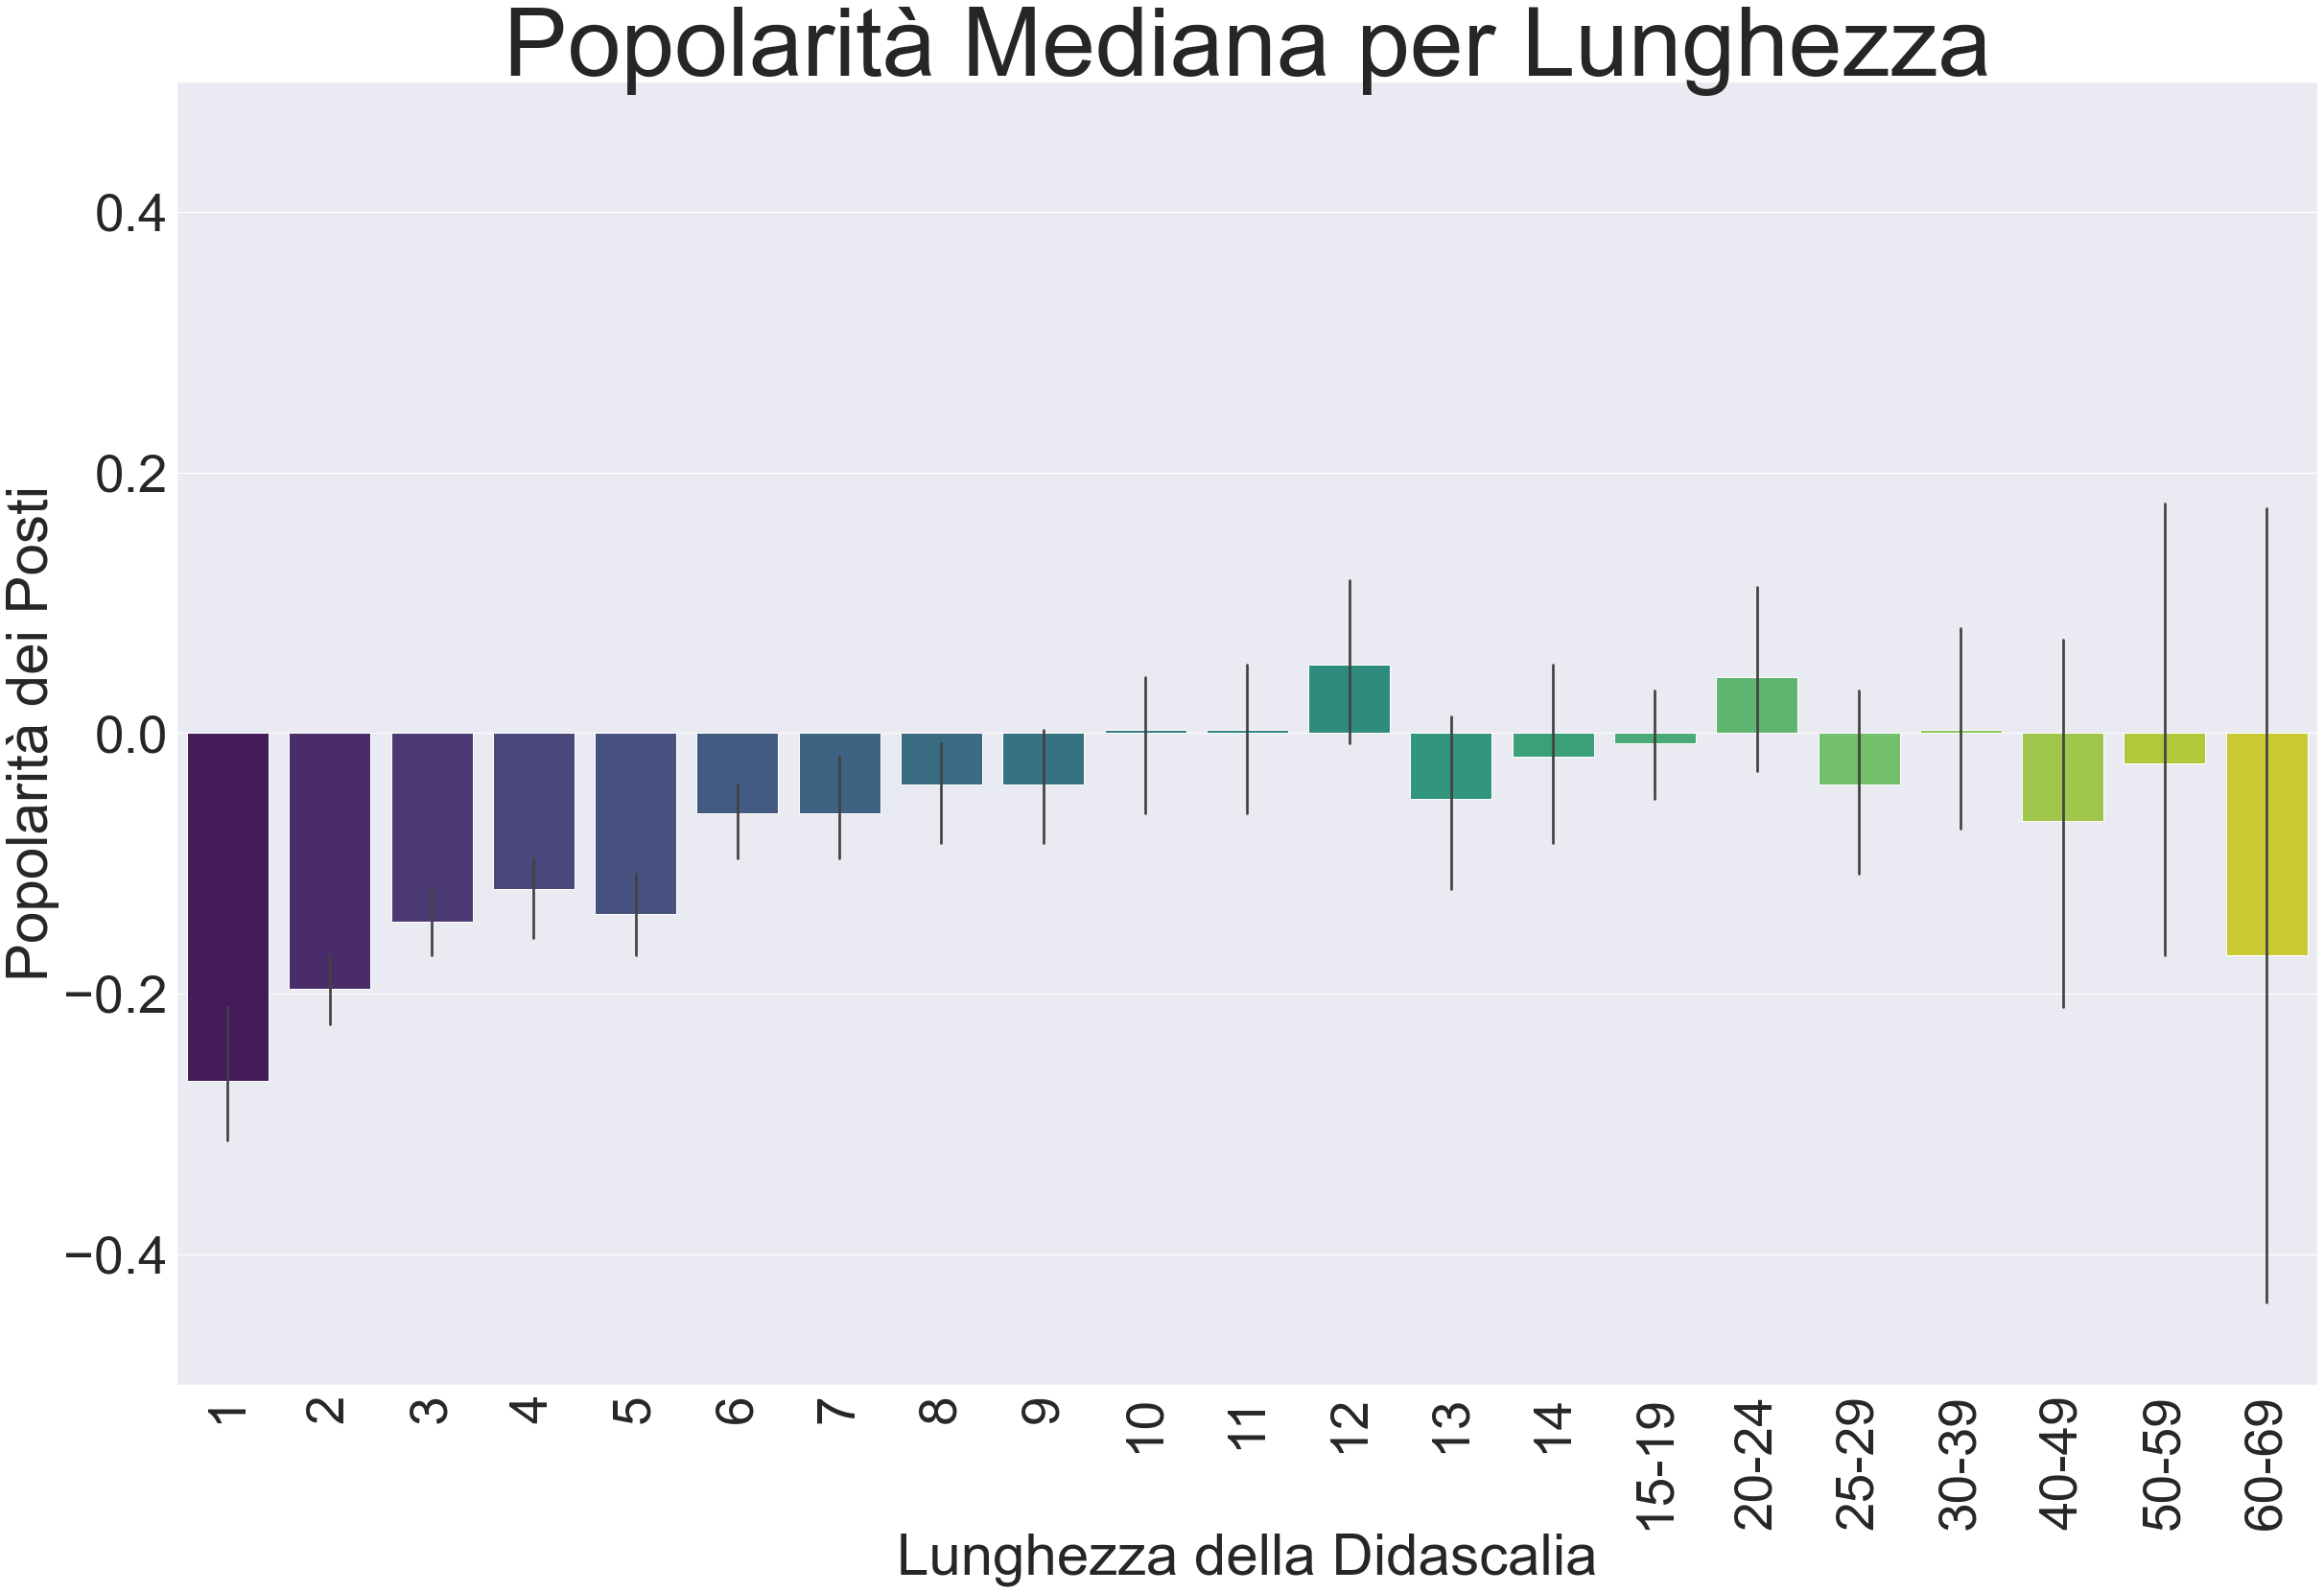

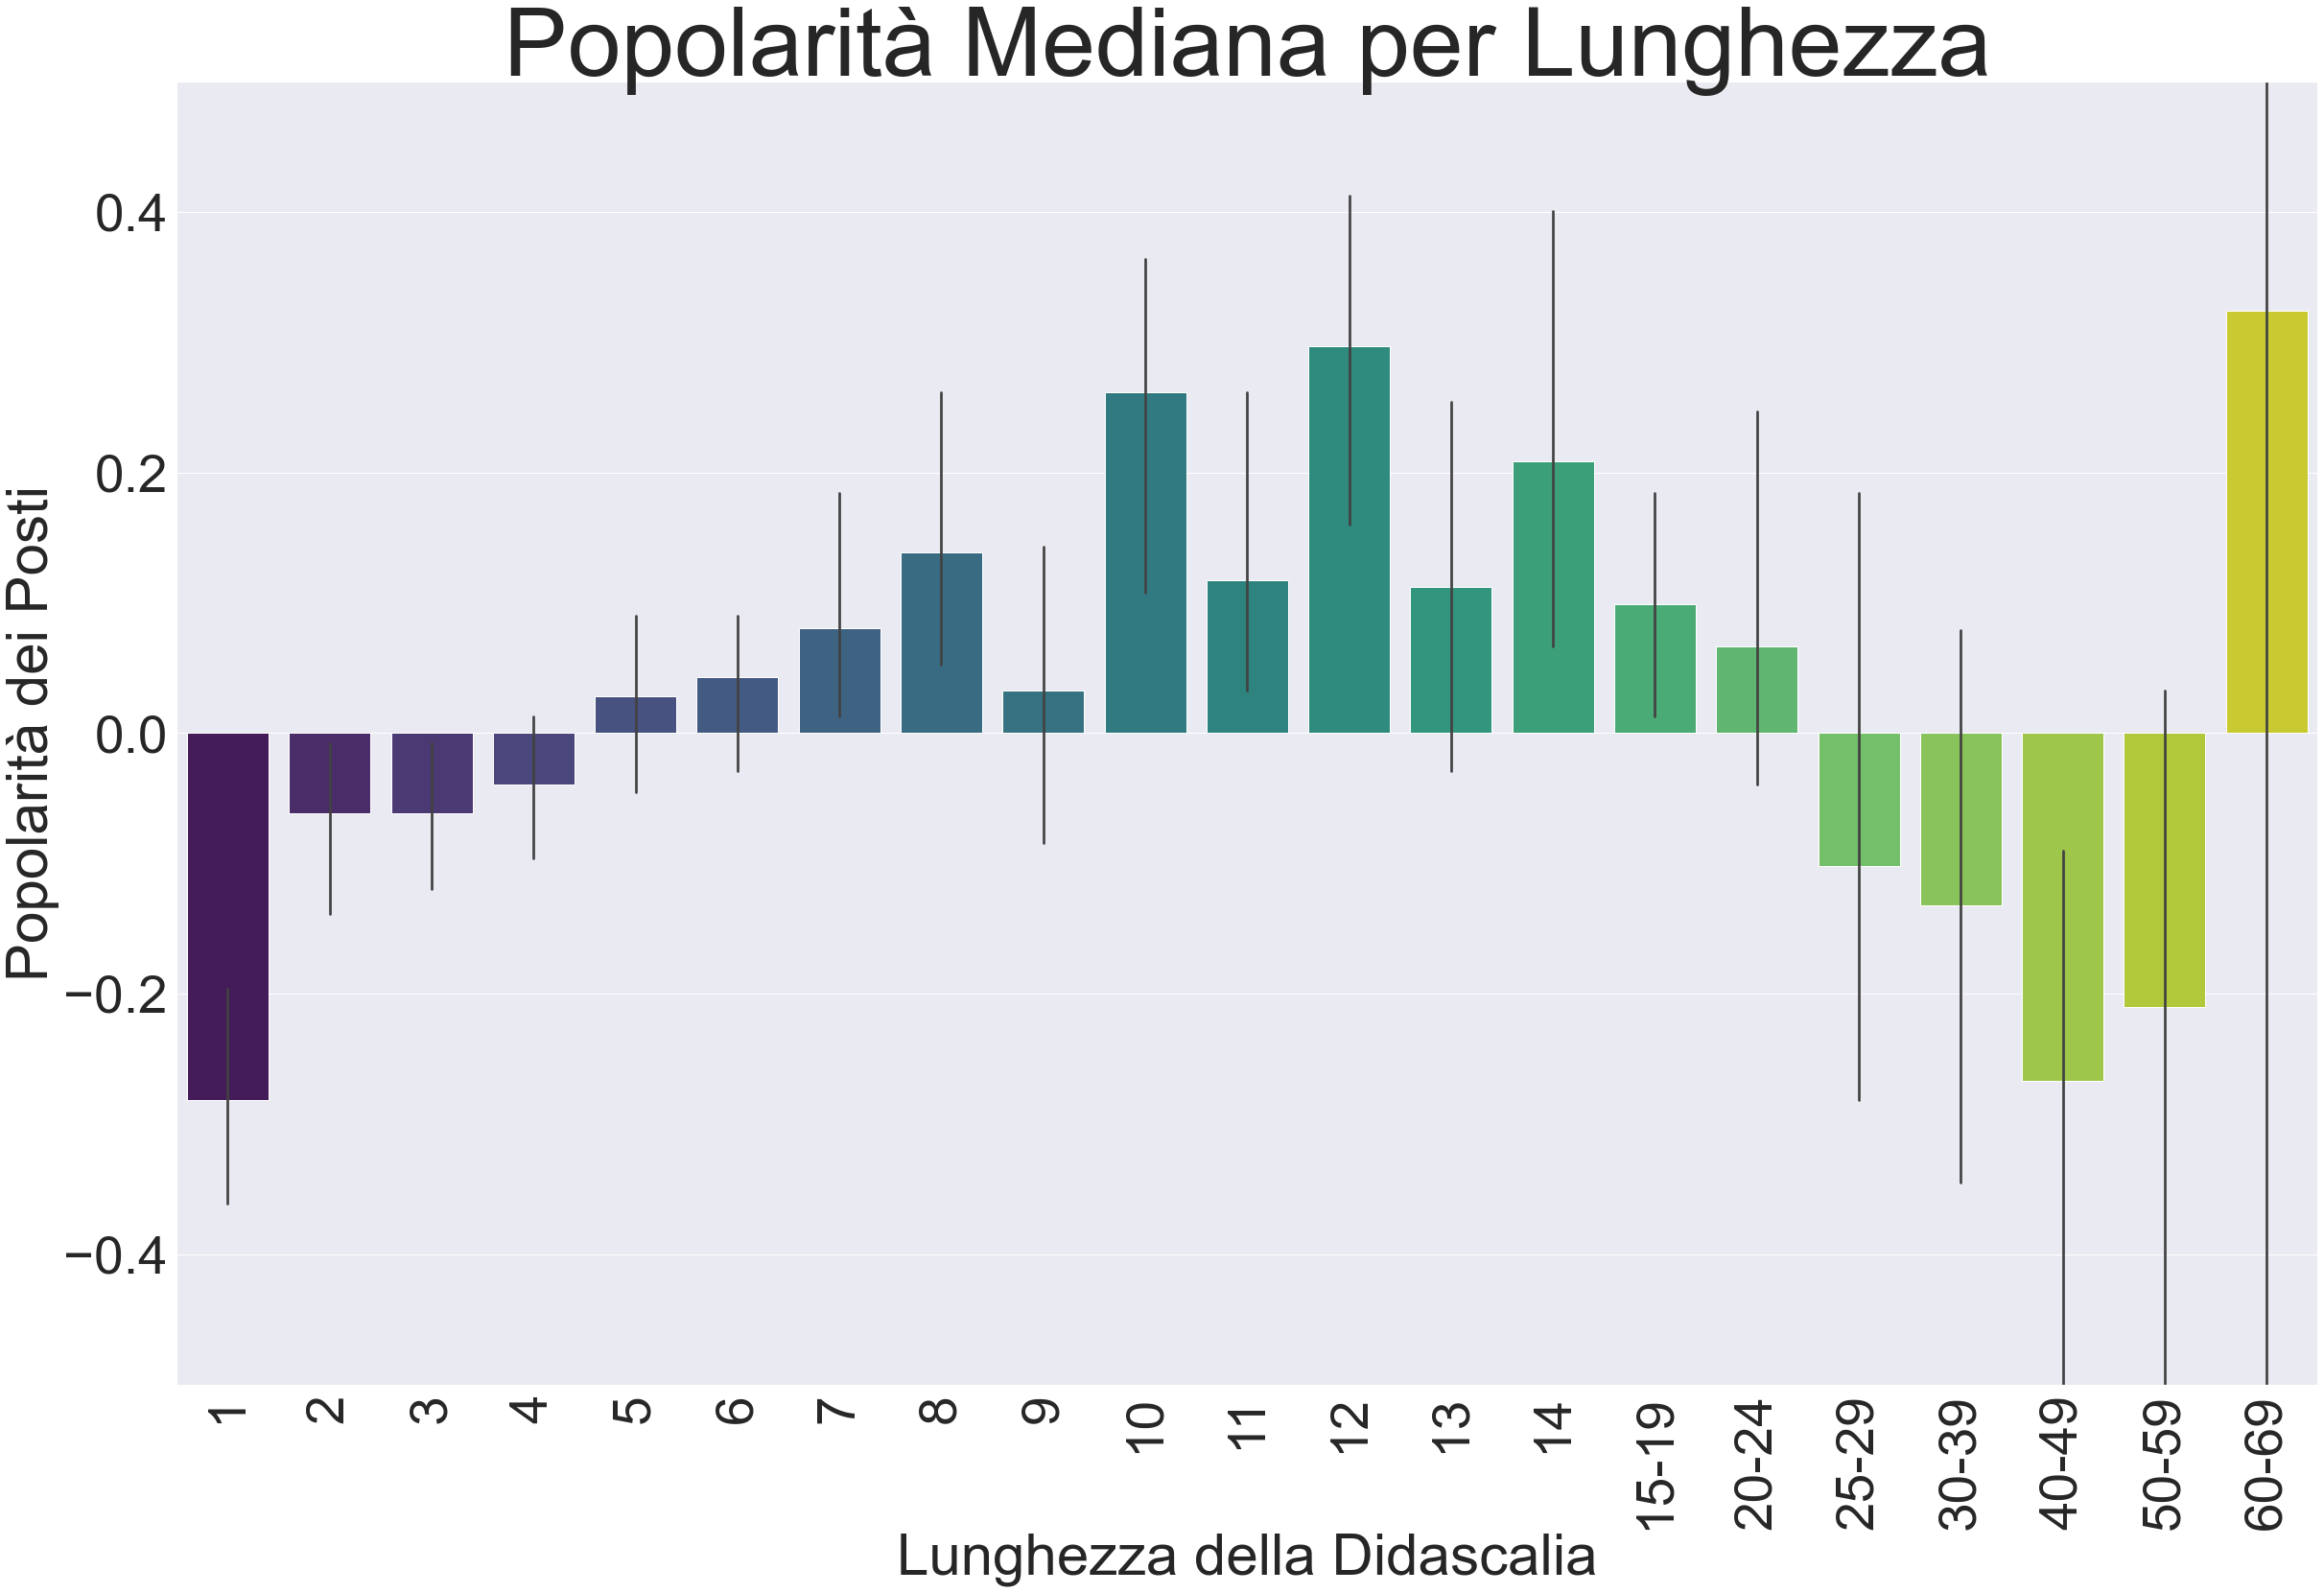

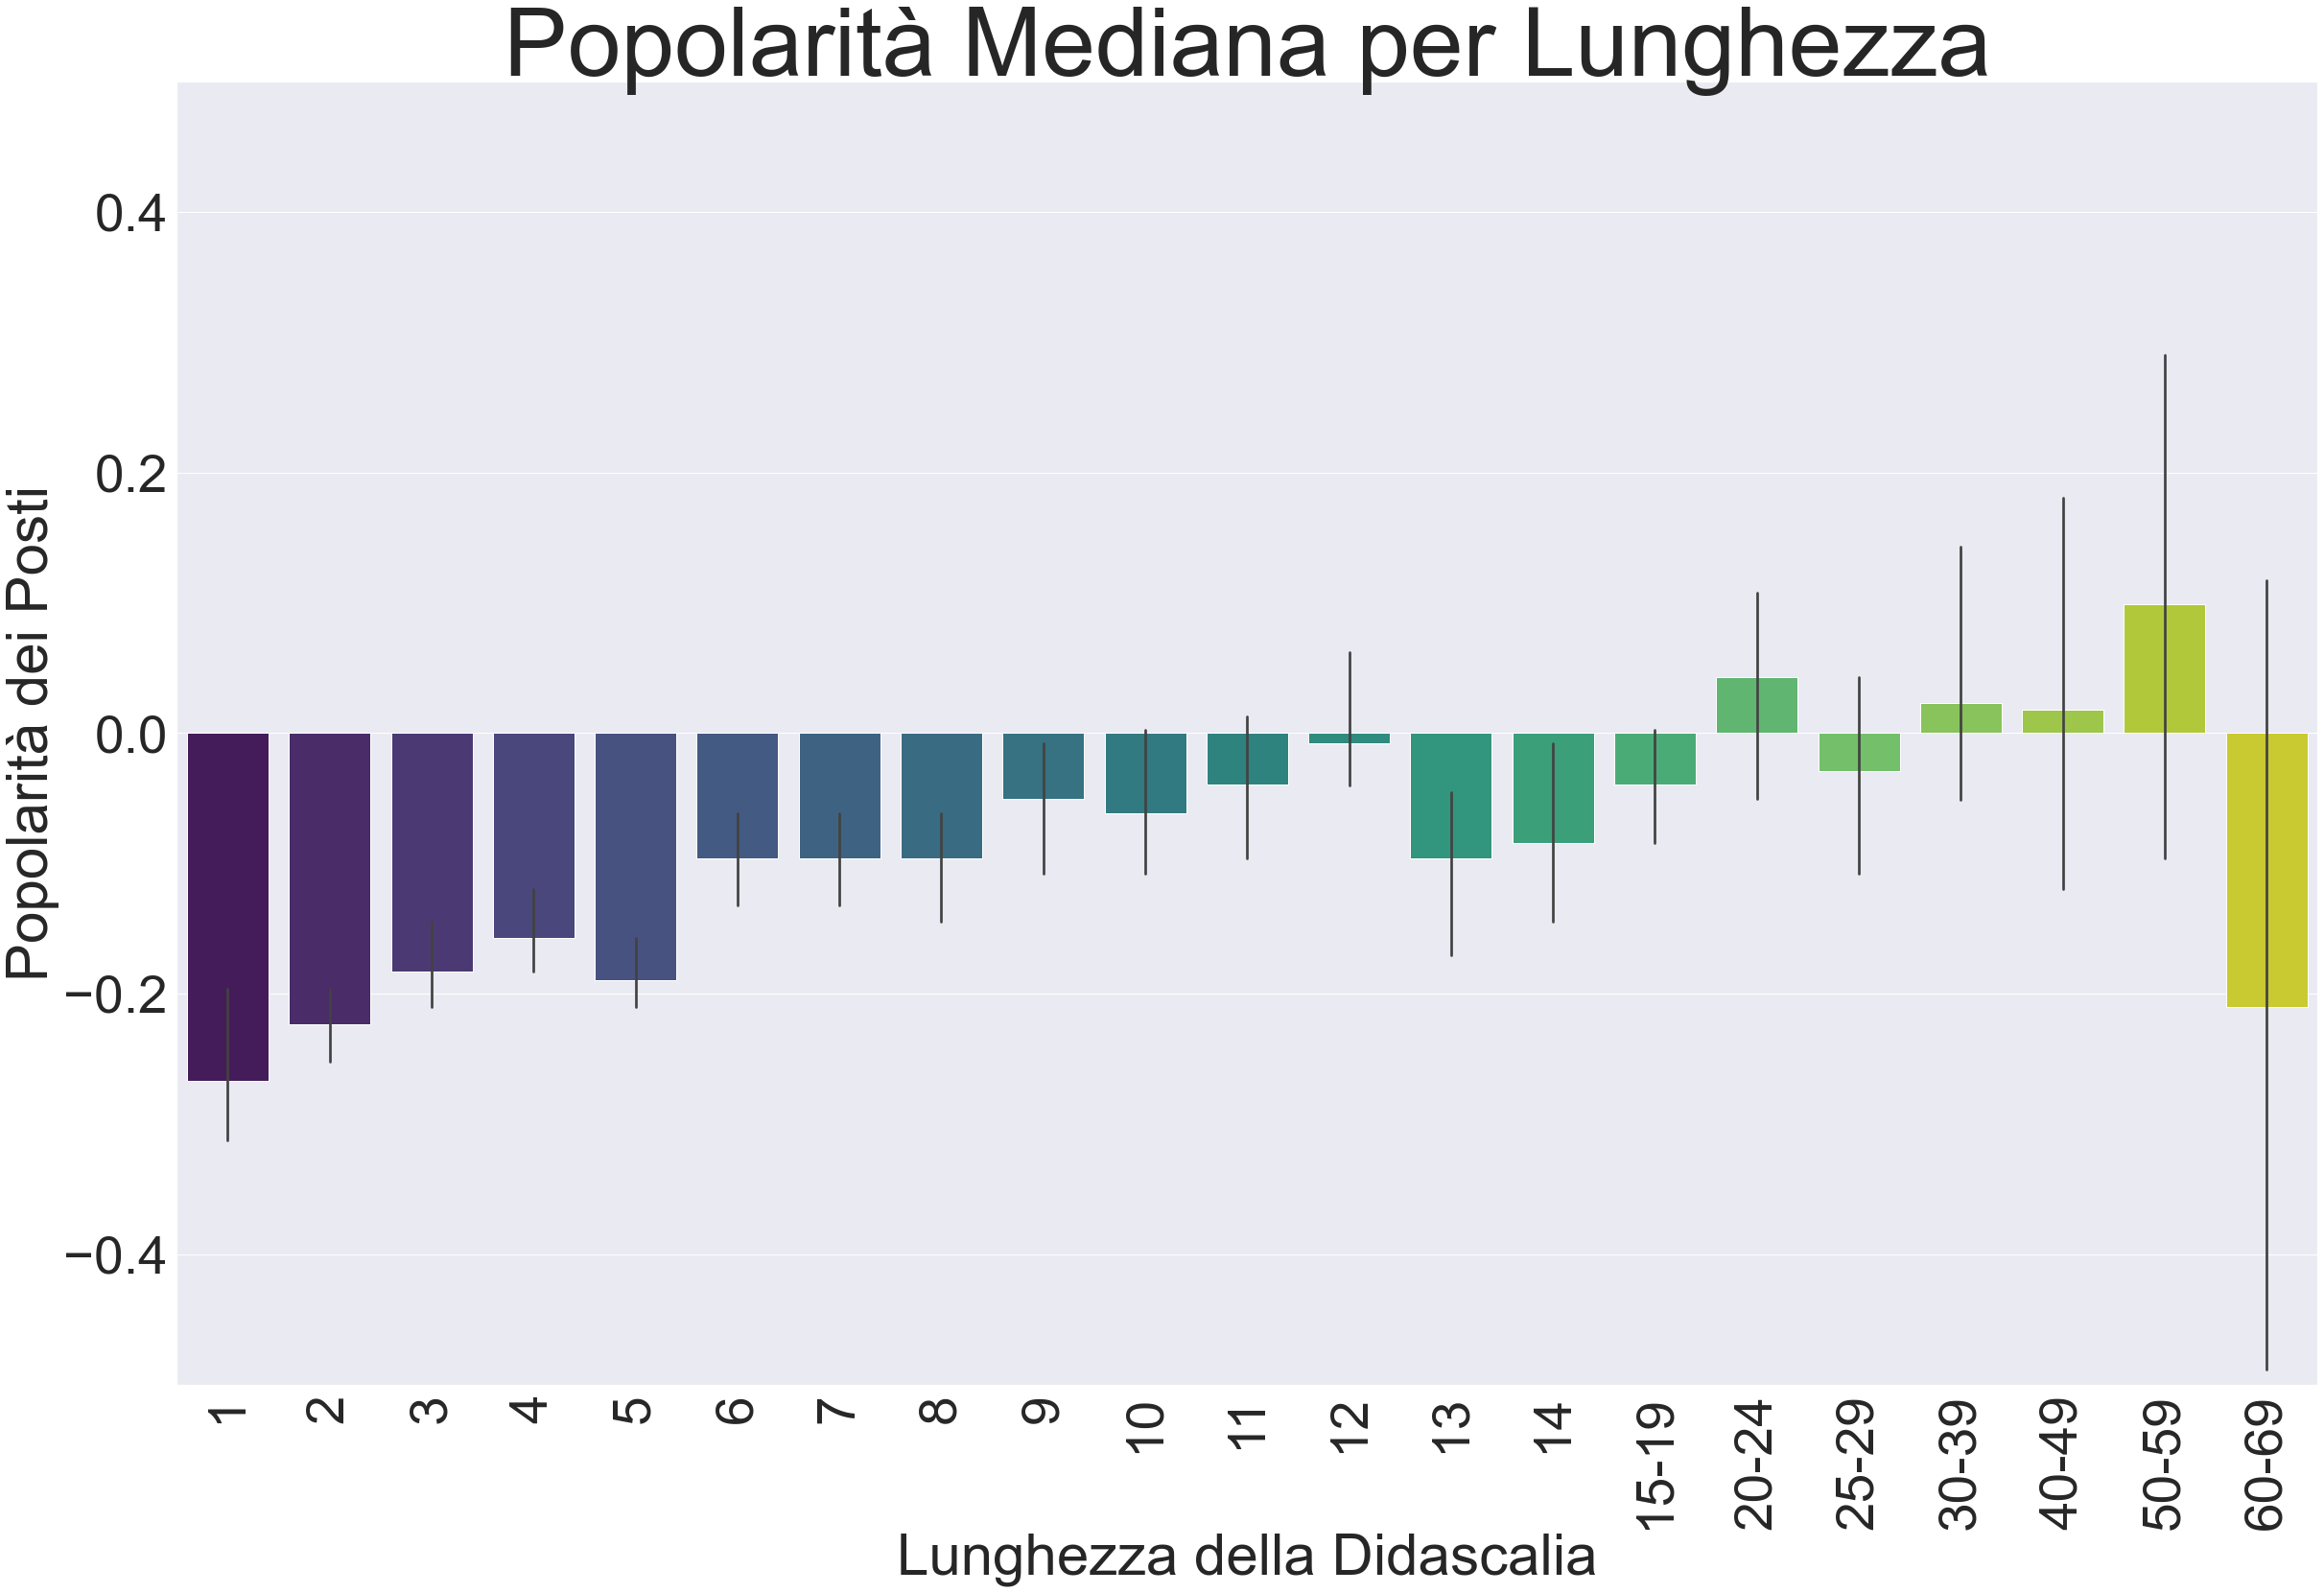

In [33]:
for l in languages:
    for f in ["all","cats","dogs"]:
    
        sns.set(font_scale=5)

        fig,ax = plt.subplots(figsize=(40,25))

        if f=="all":
            sns.barplot(data=df,ax=ax,x="length",y="target",estimator=np.median,order=df.sort_values("title_length").length.unique(),palette="viridis")
        else:
            sns.barplot(data=df[df.category==f],ax=ax,x="length",y="target",estimator=np.median,order=df.sort_values("title_length").length.unique(),palette="viridis")
        
        if l=="English":
            plt.title("Median Popularity by Length",fontsize=100)
            plt.xlabel("Length of Caption")
            plt.ylabel("Popularity of Posts")
        else:
            plt.title("Popolarità Mediana per Lunghezza",fontsize=100)
            plt.xlabel("Lunghezza della Didascalia")
            plt.ylabel("Popolarità dei Posti")
            
        plt.ylim([-0.5,0.5])
        plt.xticks(rotation = 90)
        
        plt.savefig(f'appdata/captionlength_target_{l.lower()}_{f}.png')

### Percent composition of subject

In [9]:
data = df.value_counts(subset="subject",normalize=True).to_frame().reset_index().rename(columns={0:"percent"})
data = data[data.subject!="other"]
sub_order = data.subject.unique()
data = df[df.soggetto!="altro"].value_counts(subset="soggetto",normalize=True).to_frame().reset_index().rename(columns={0:"percent"})
data = data[data.soggetto!="altro"]
sub_order_it = data.soggetto.unique()


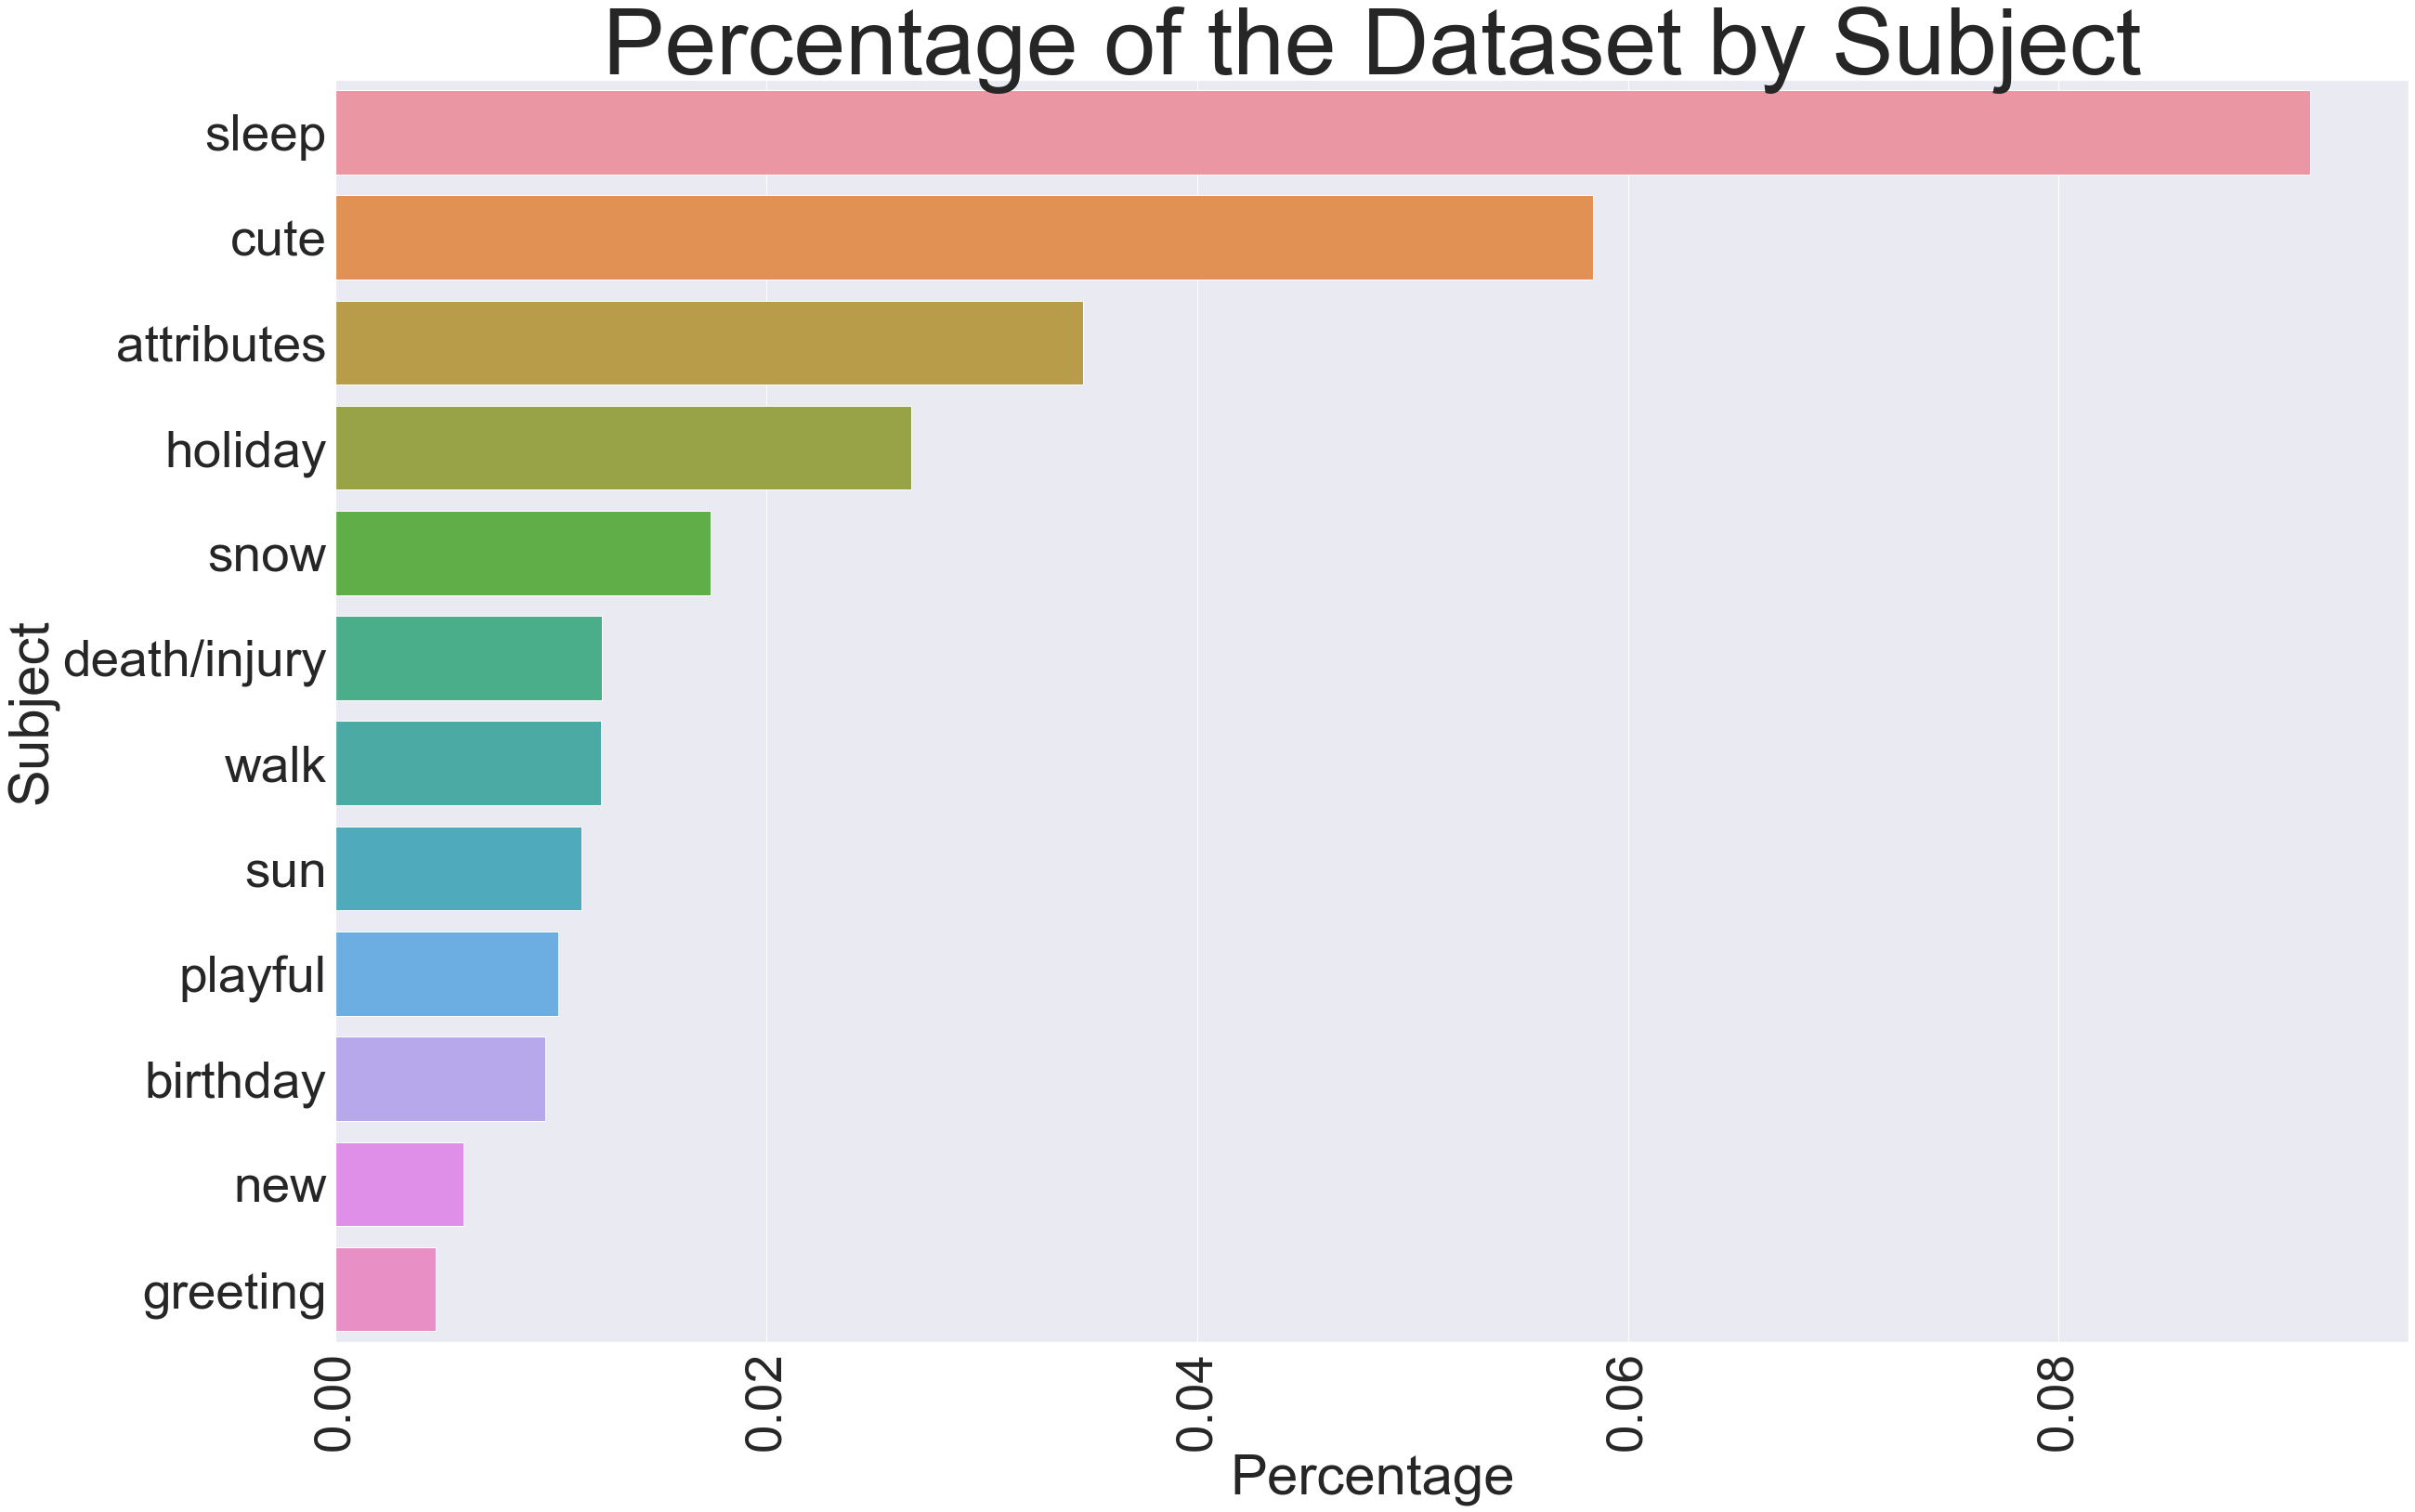

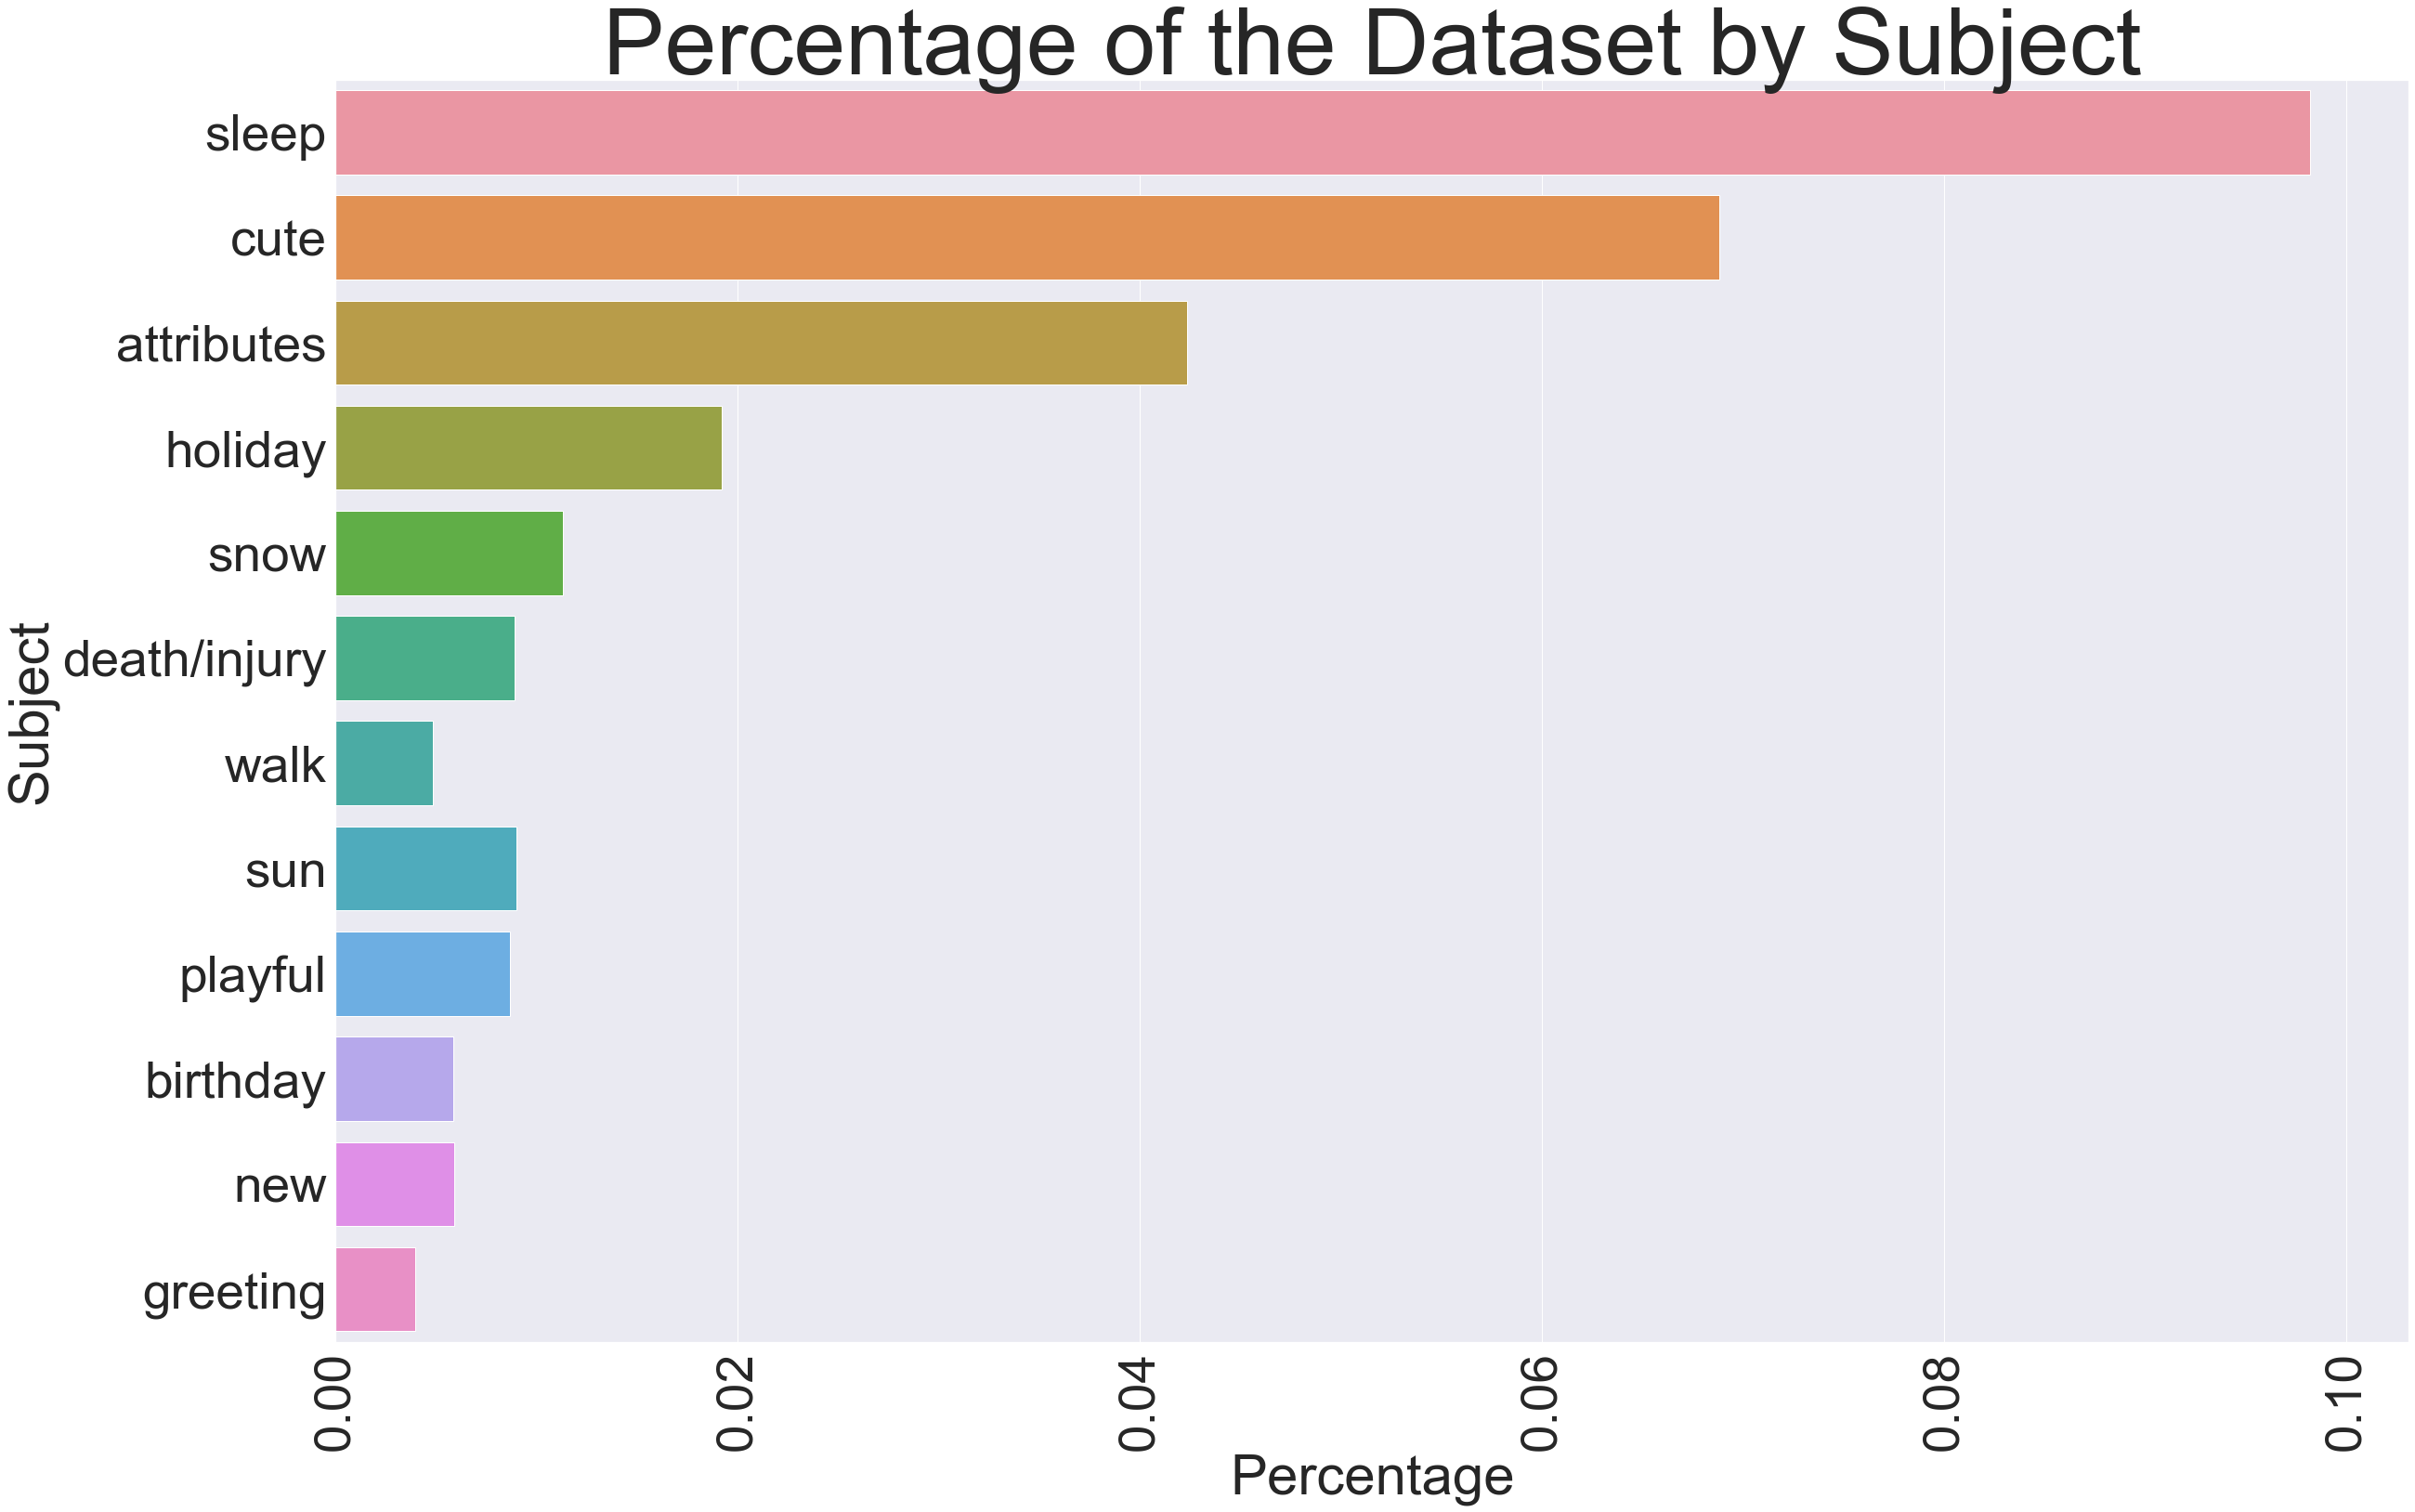

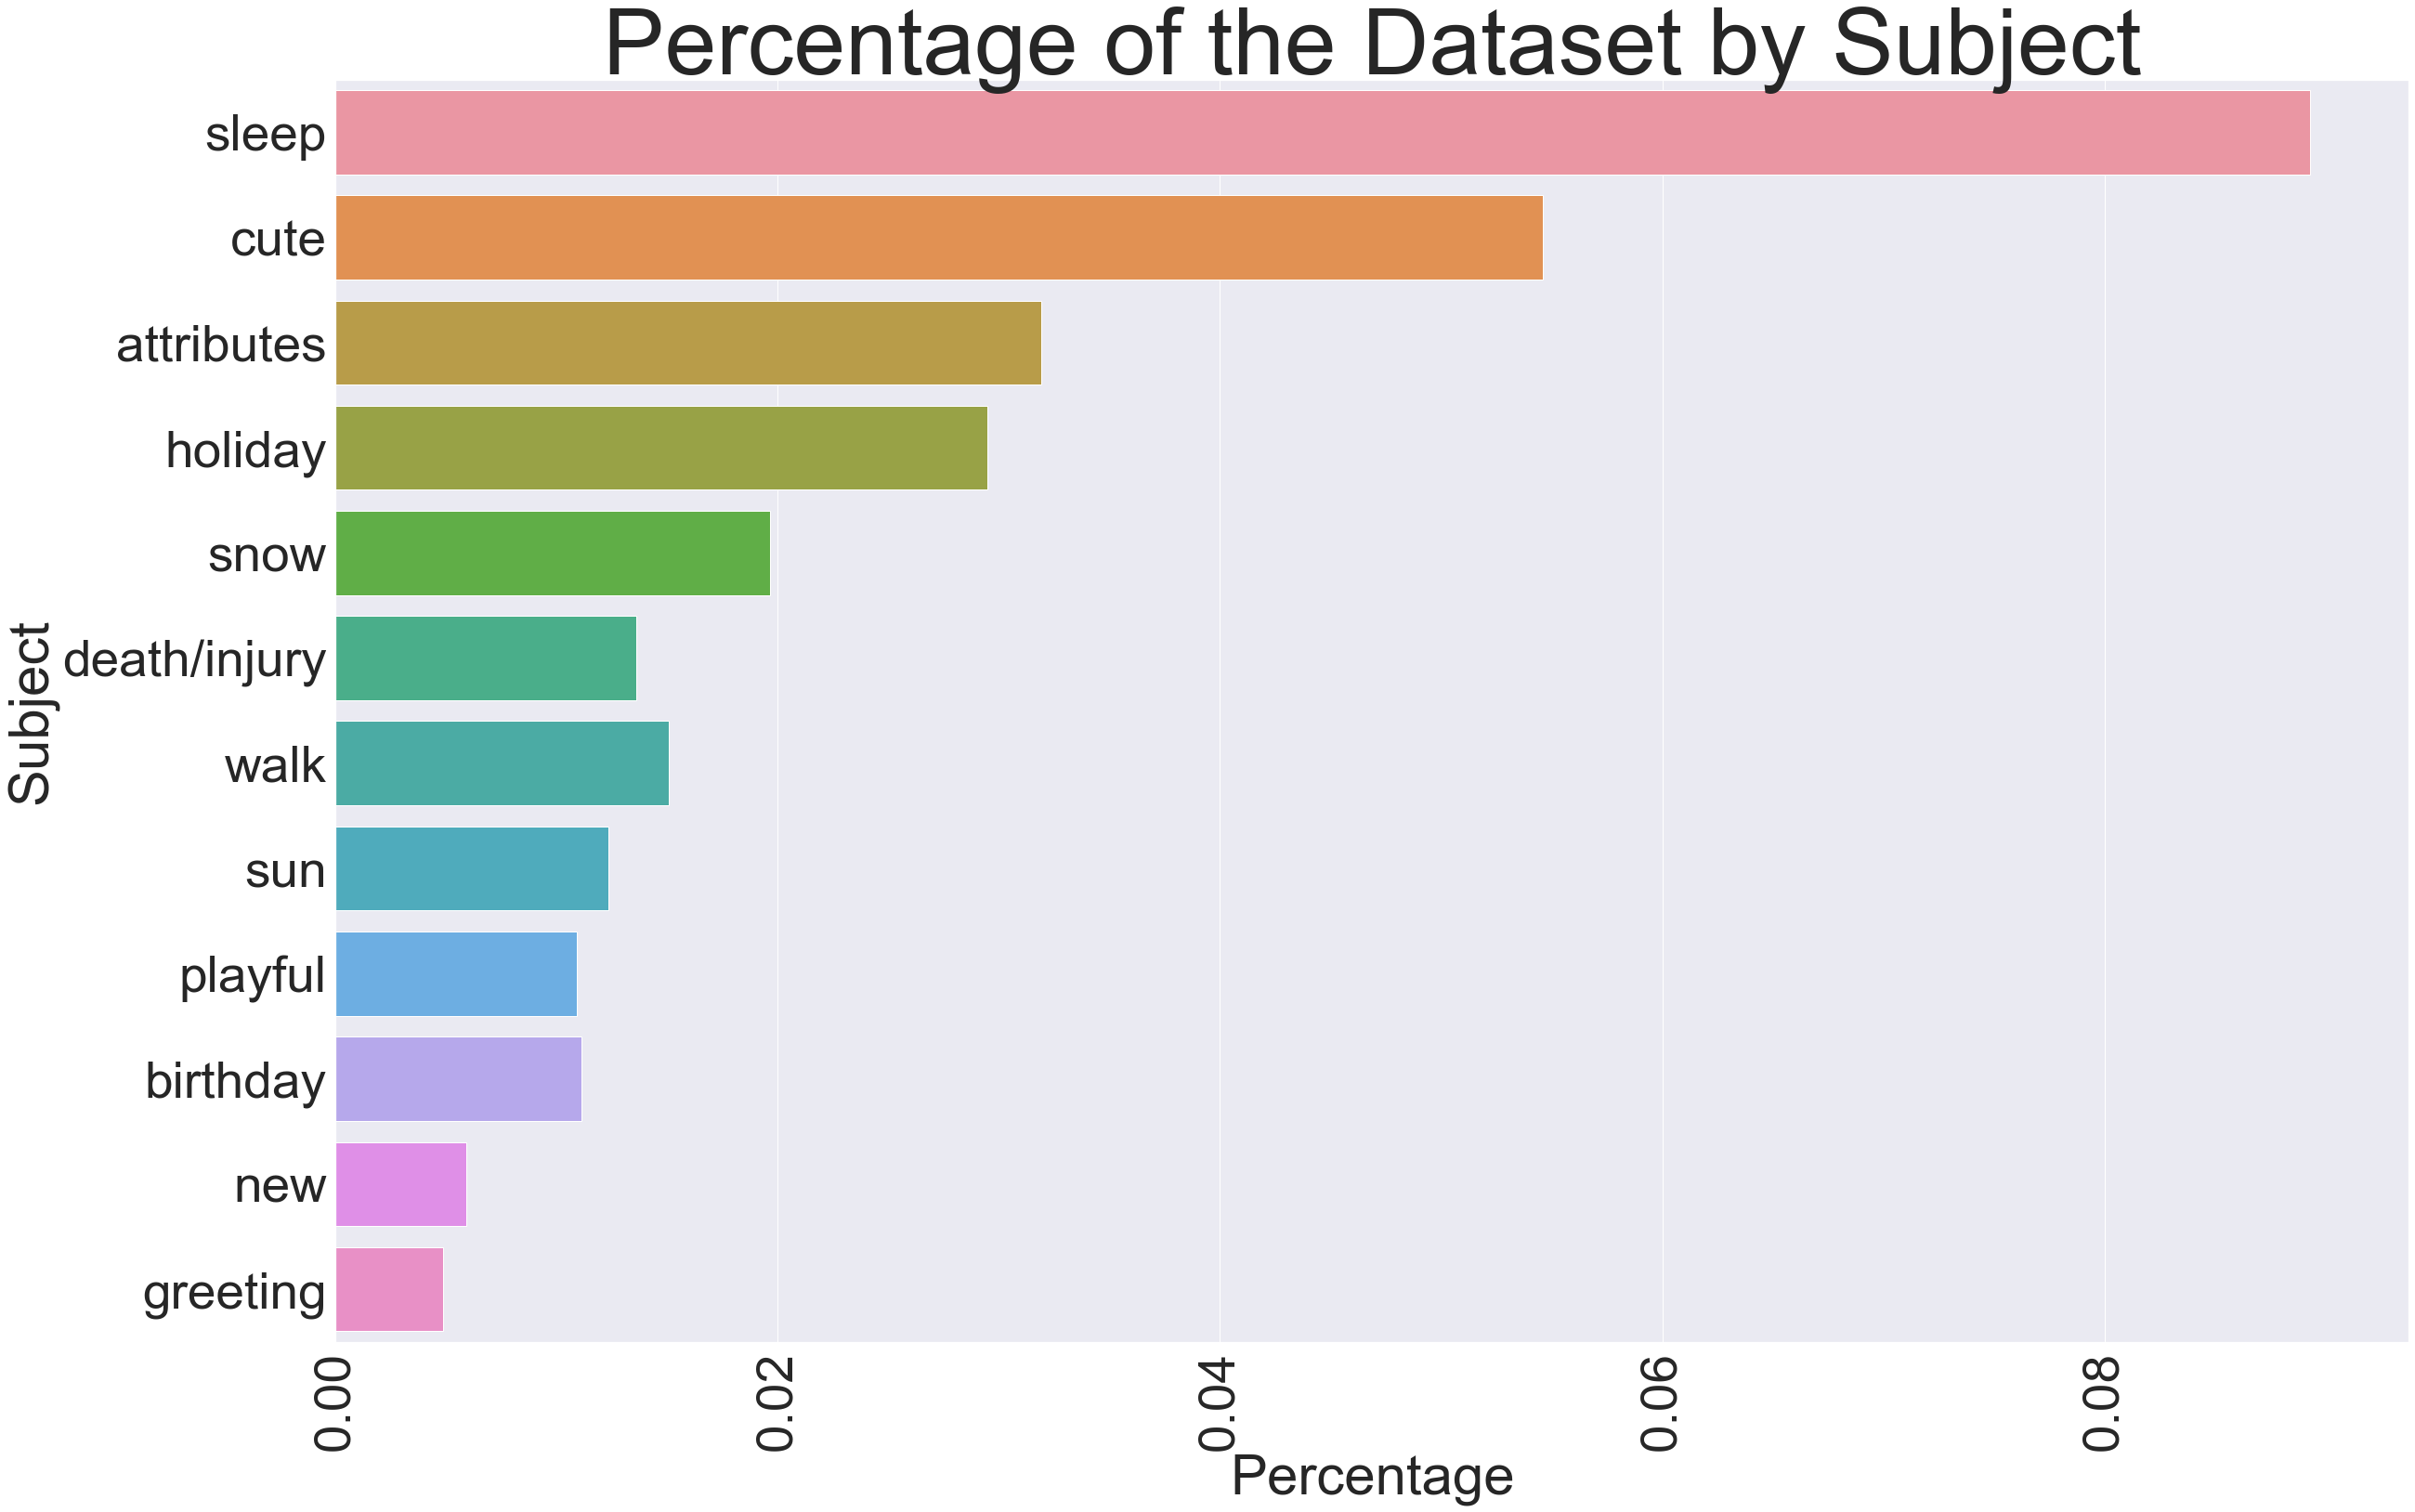

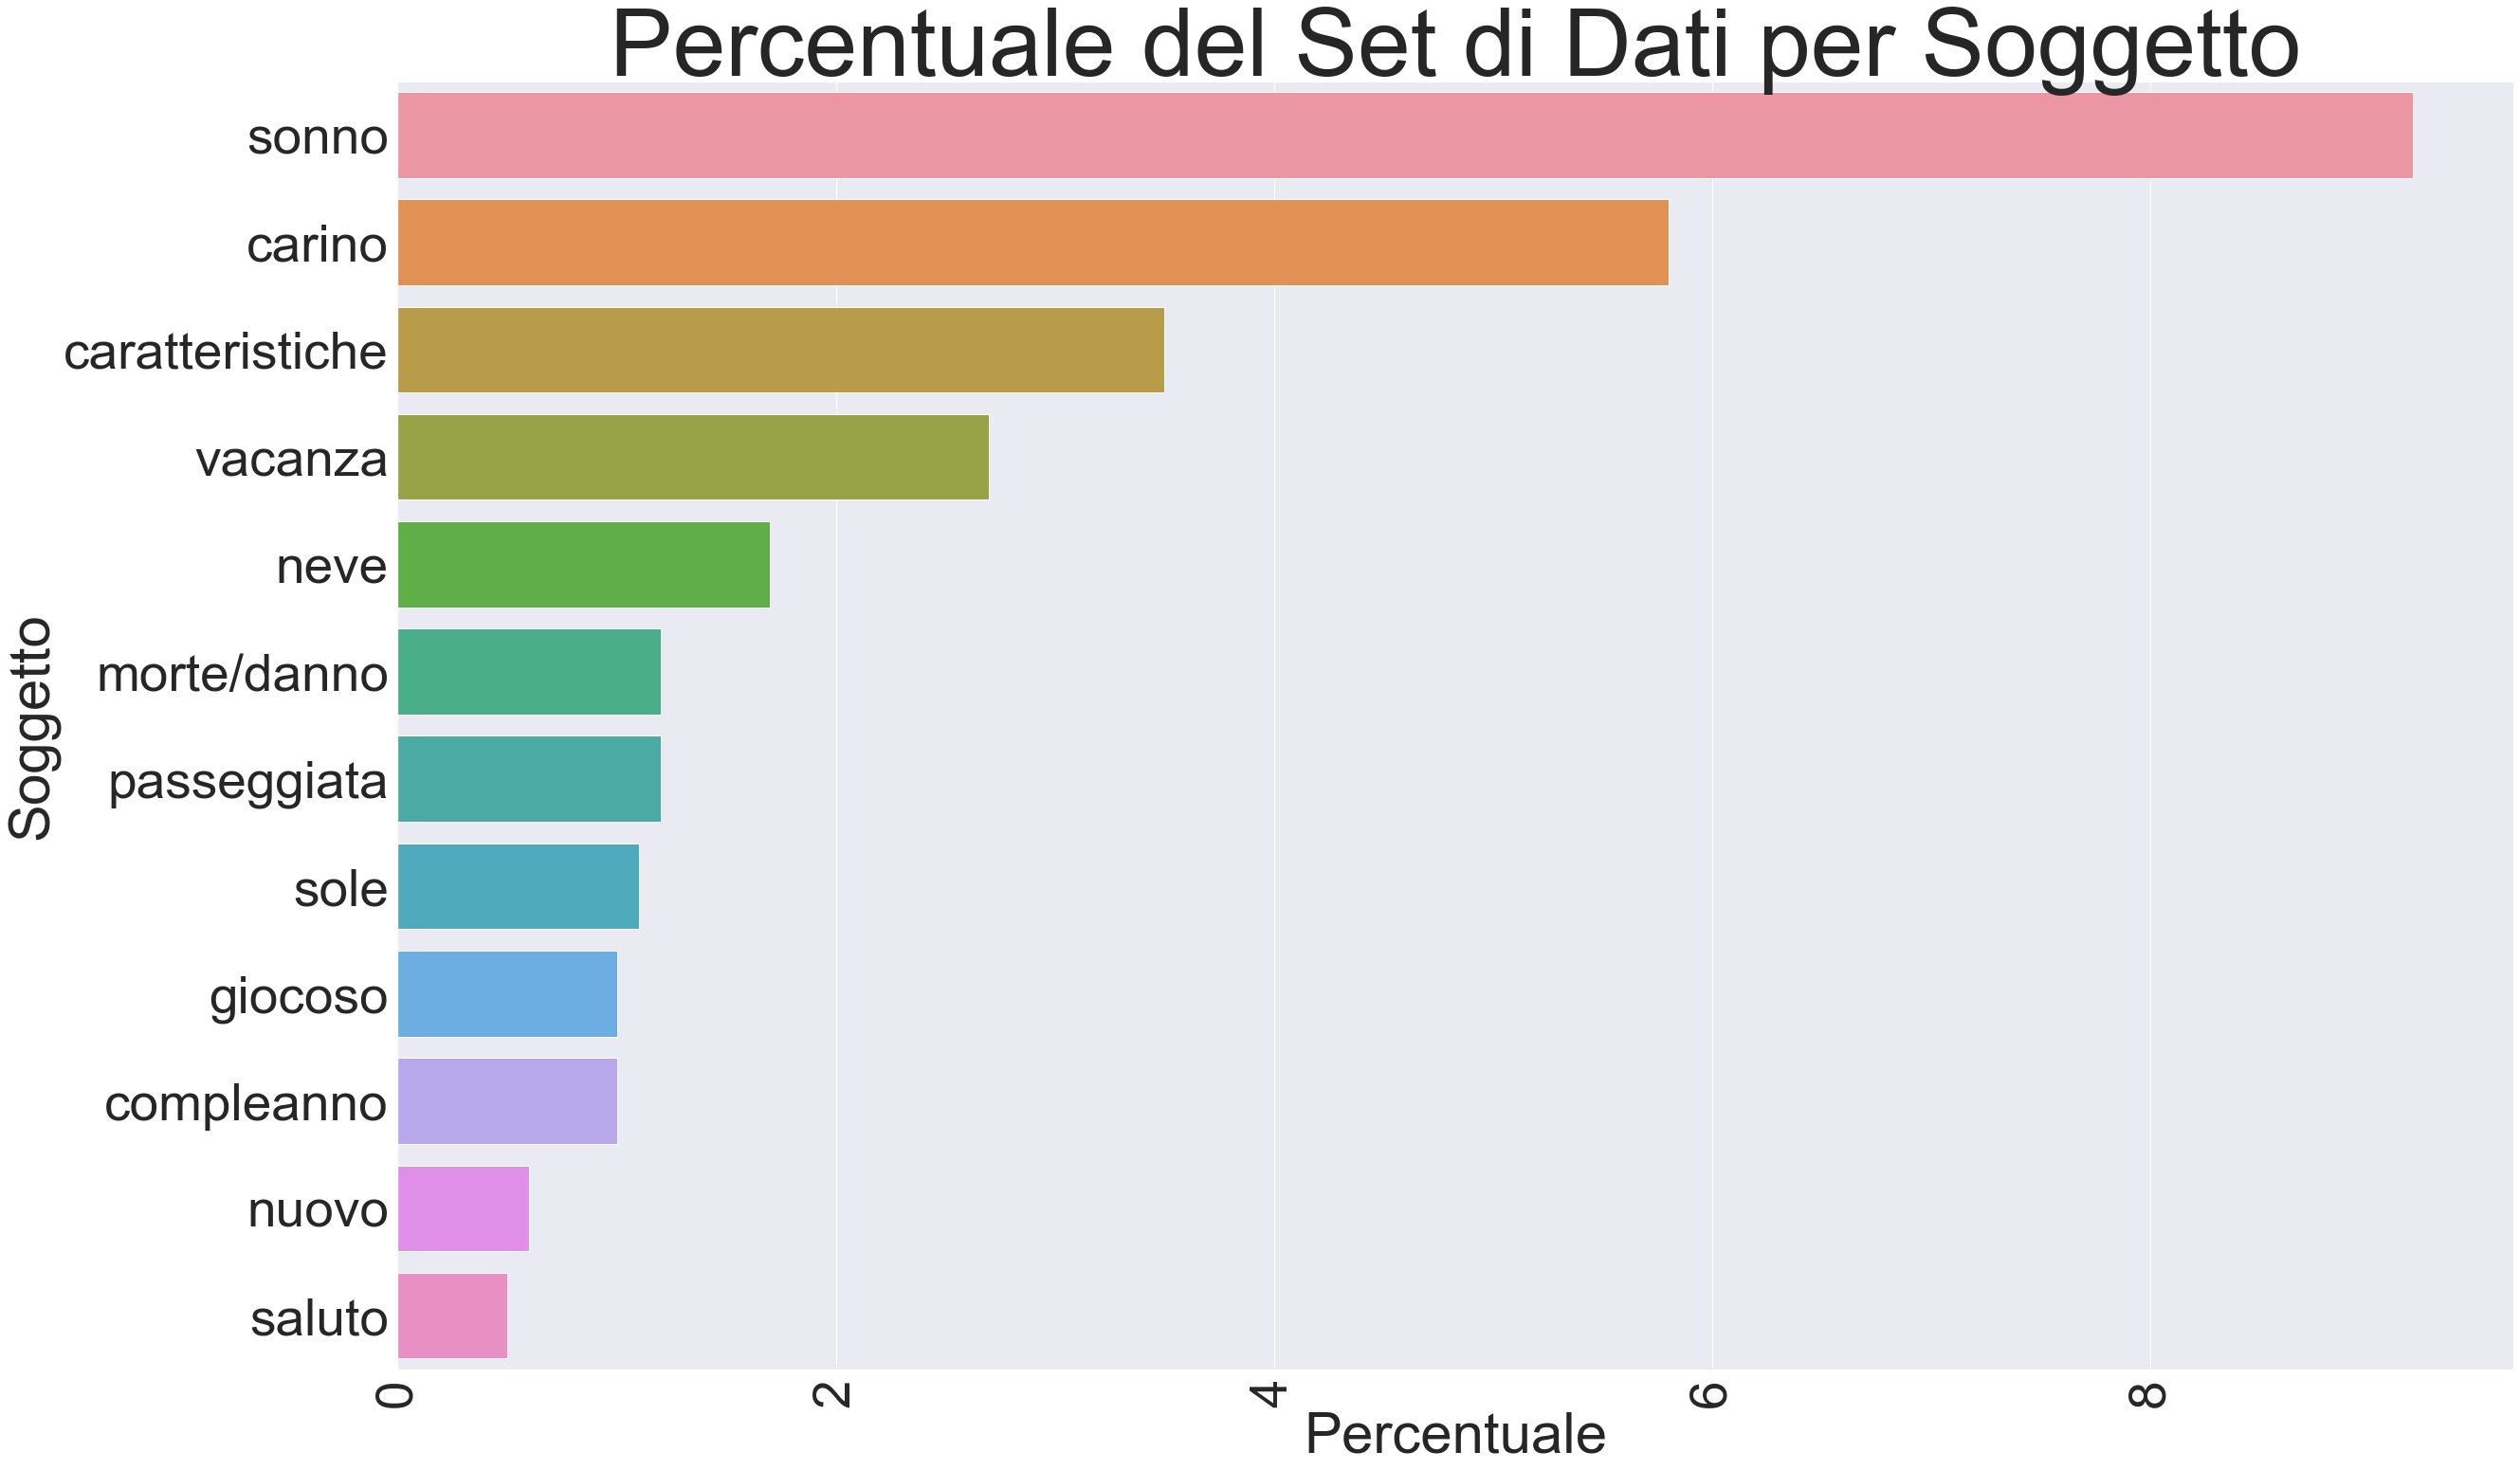

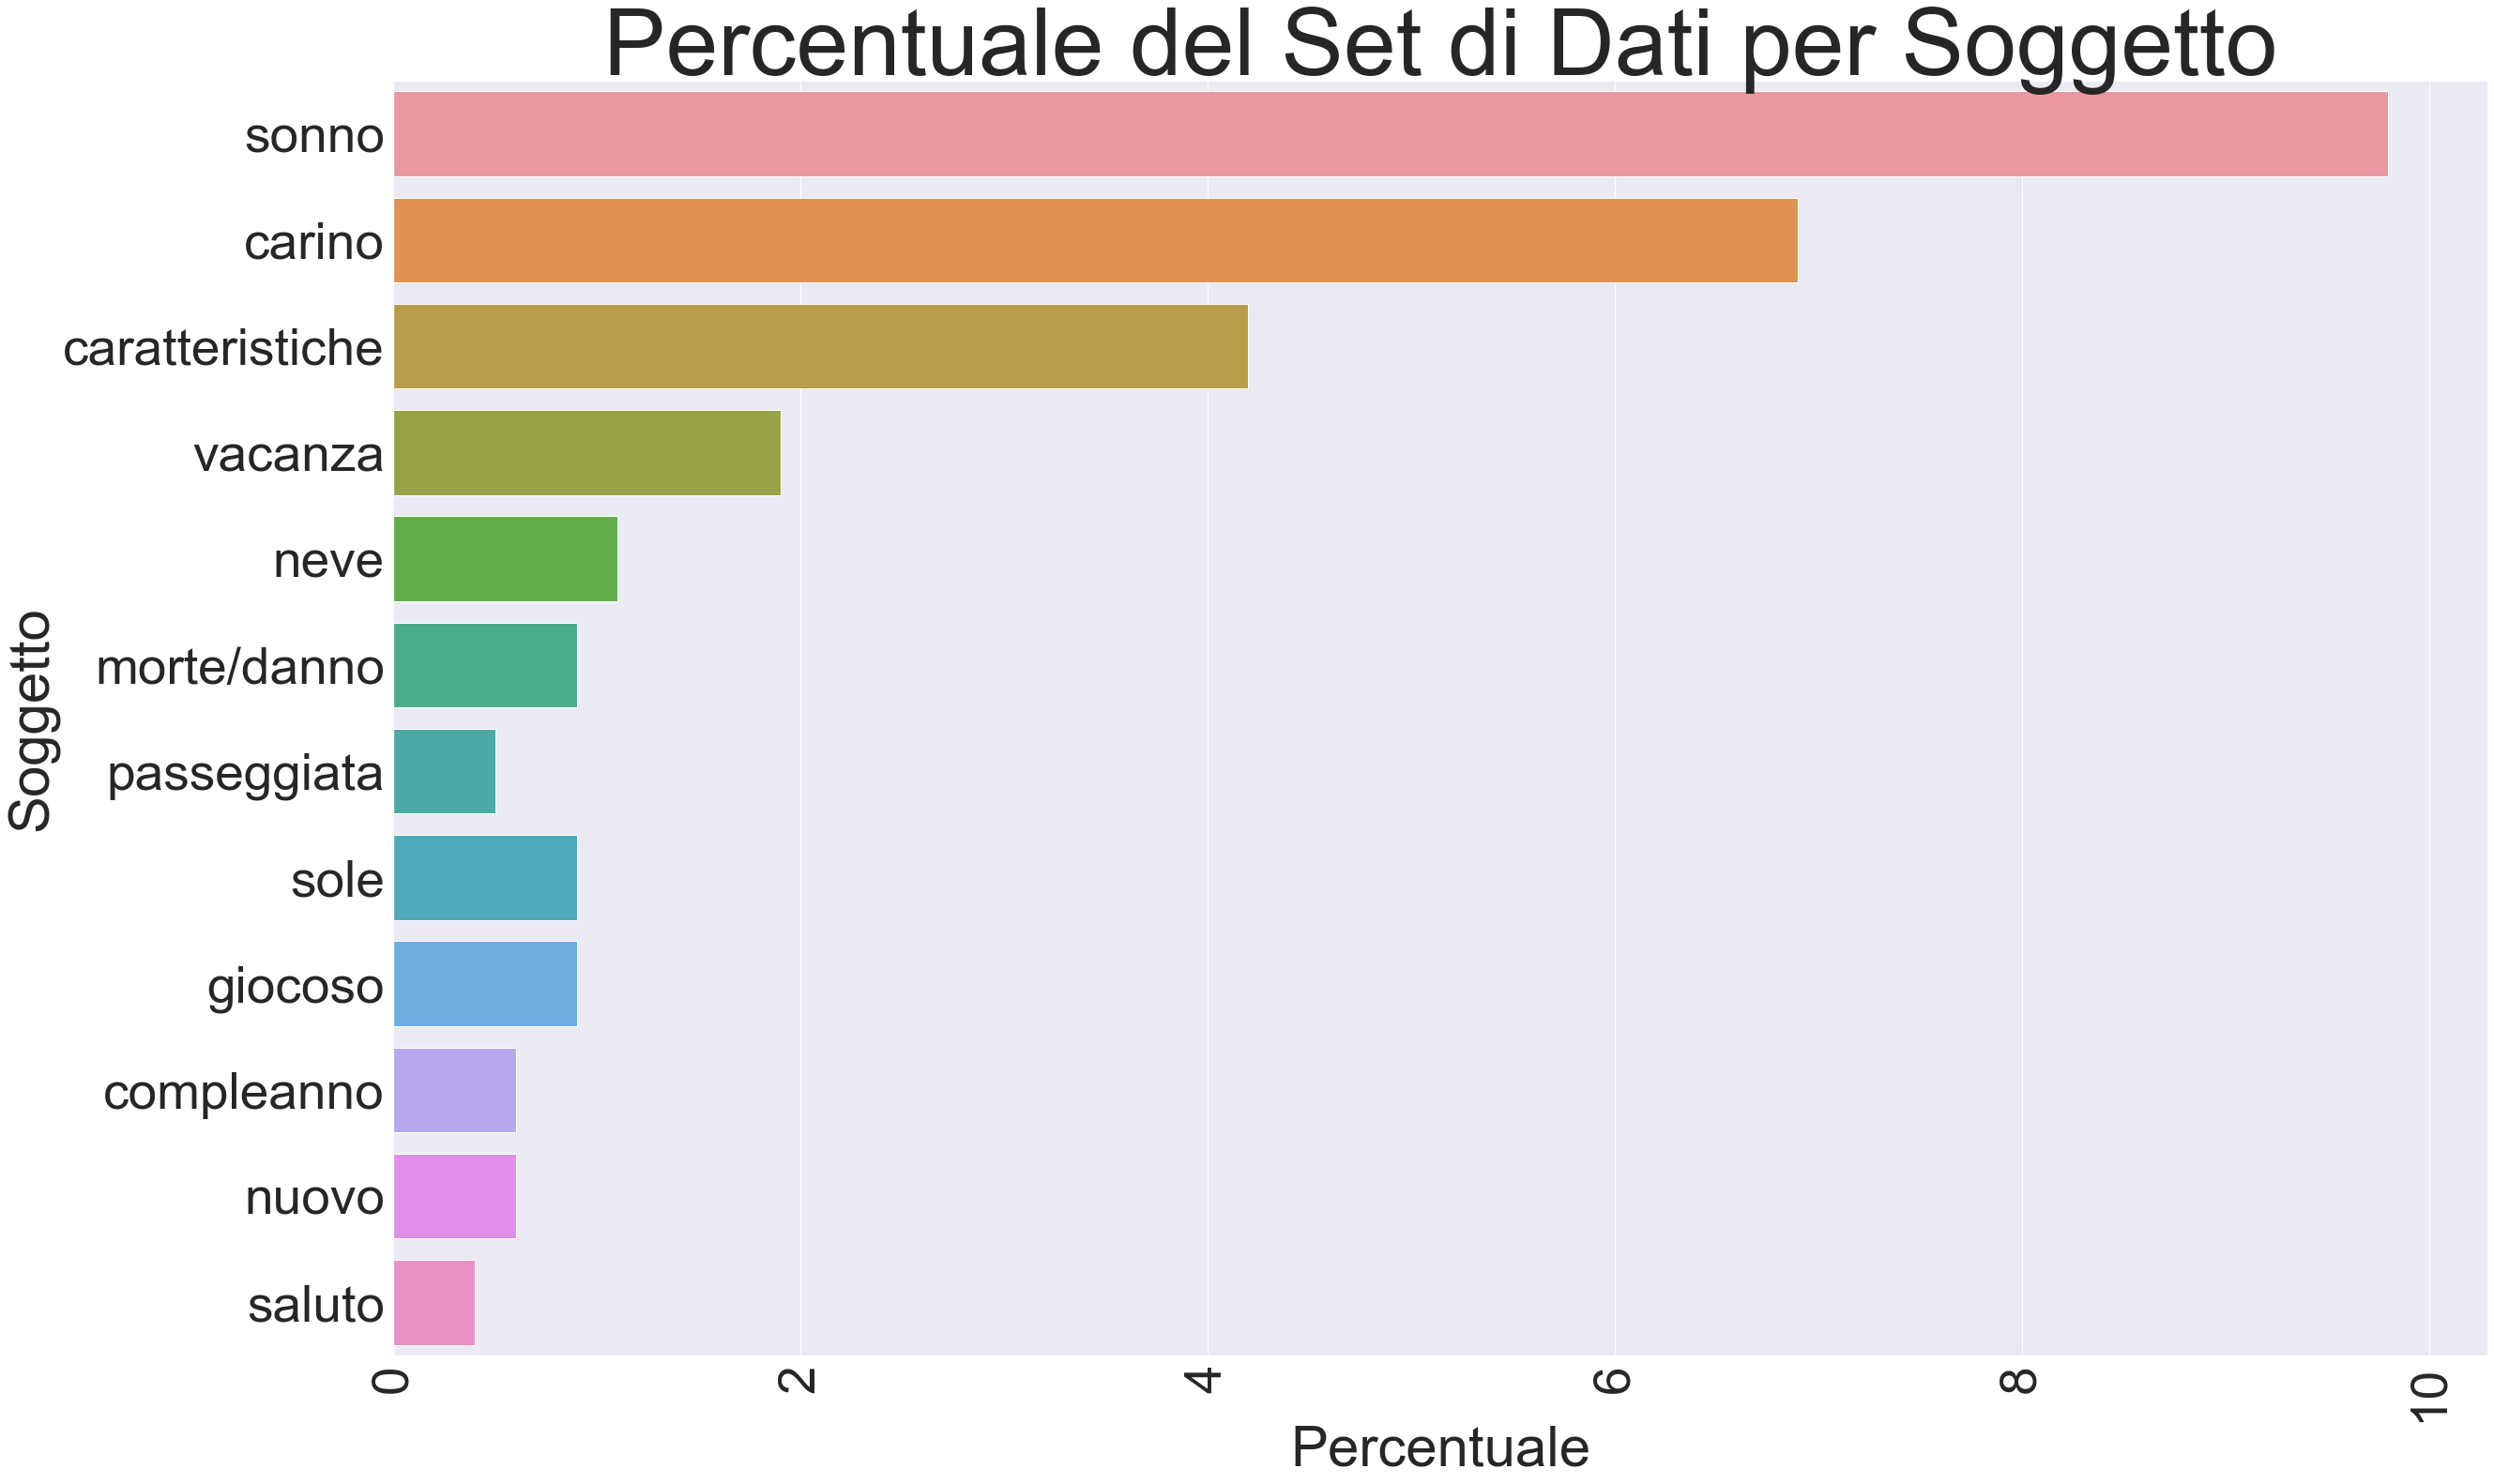

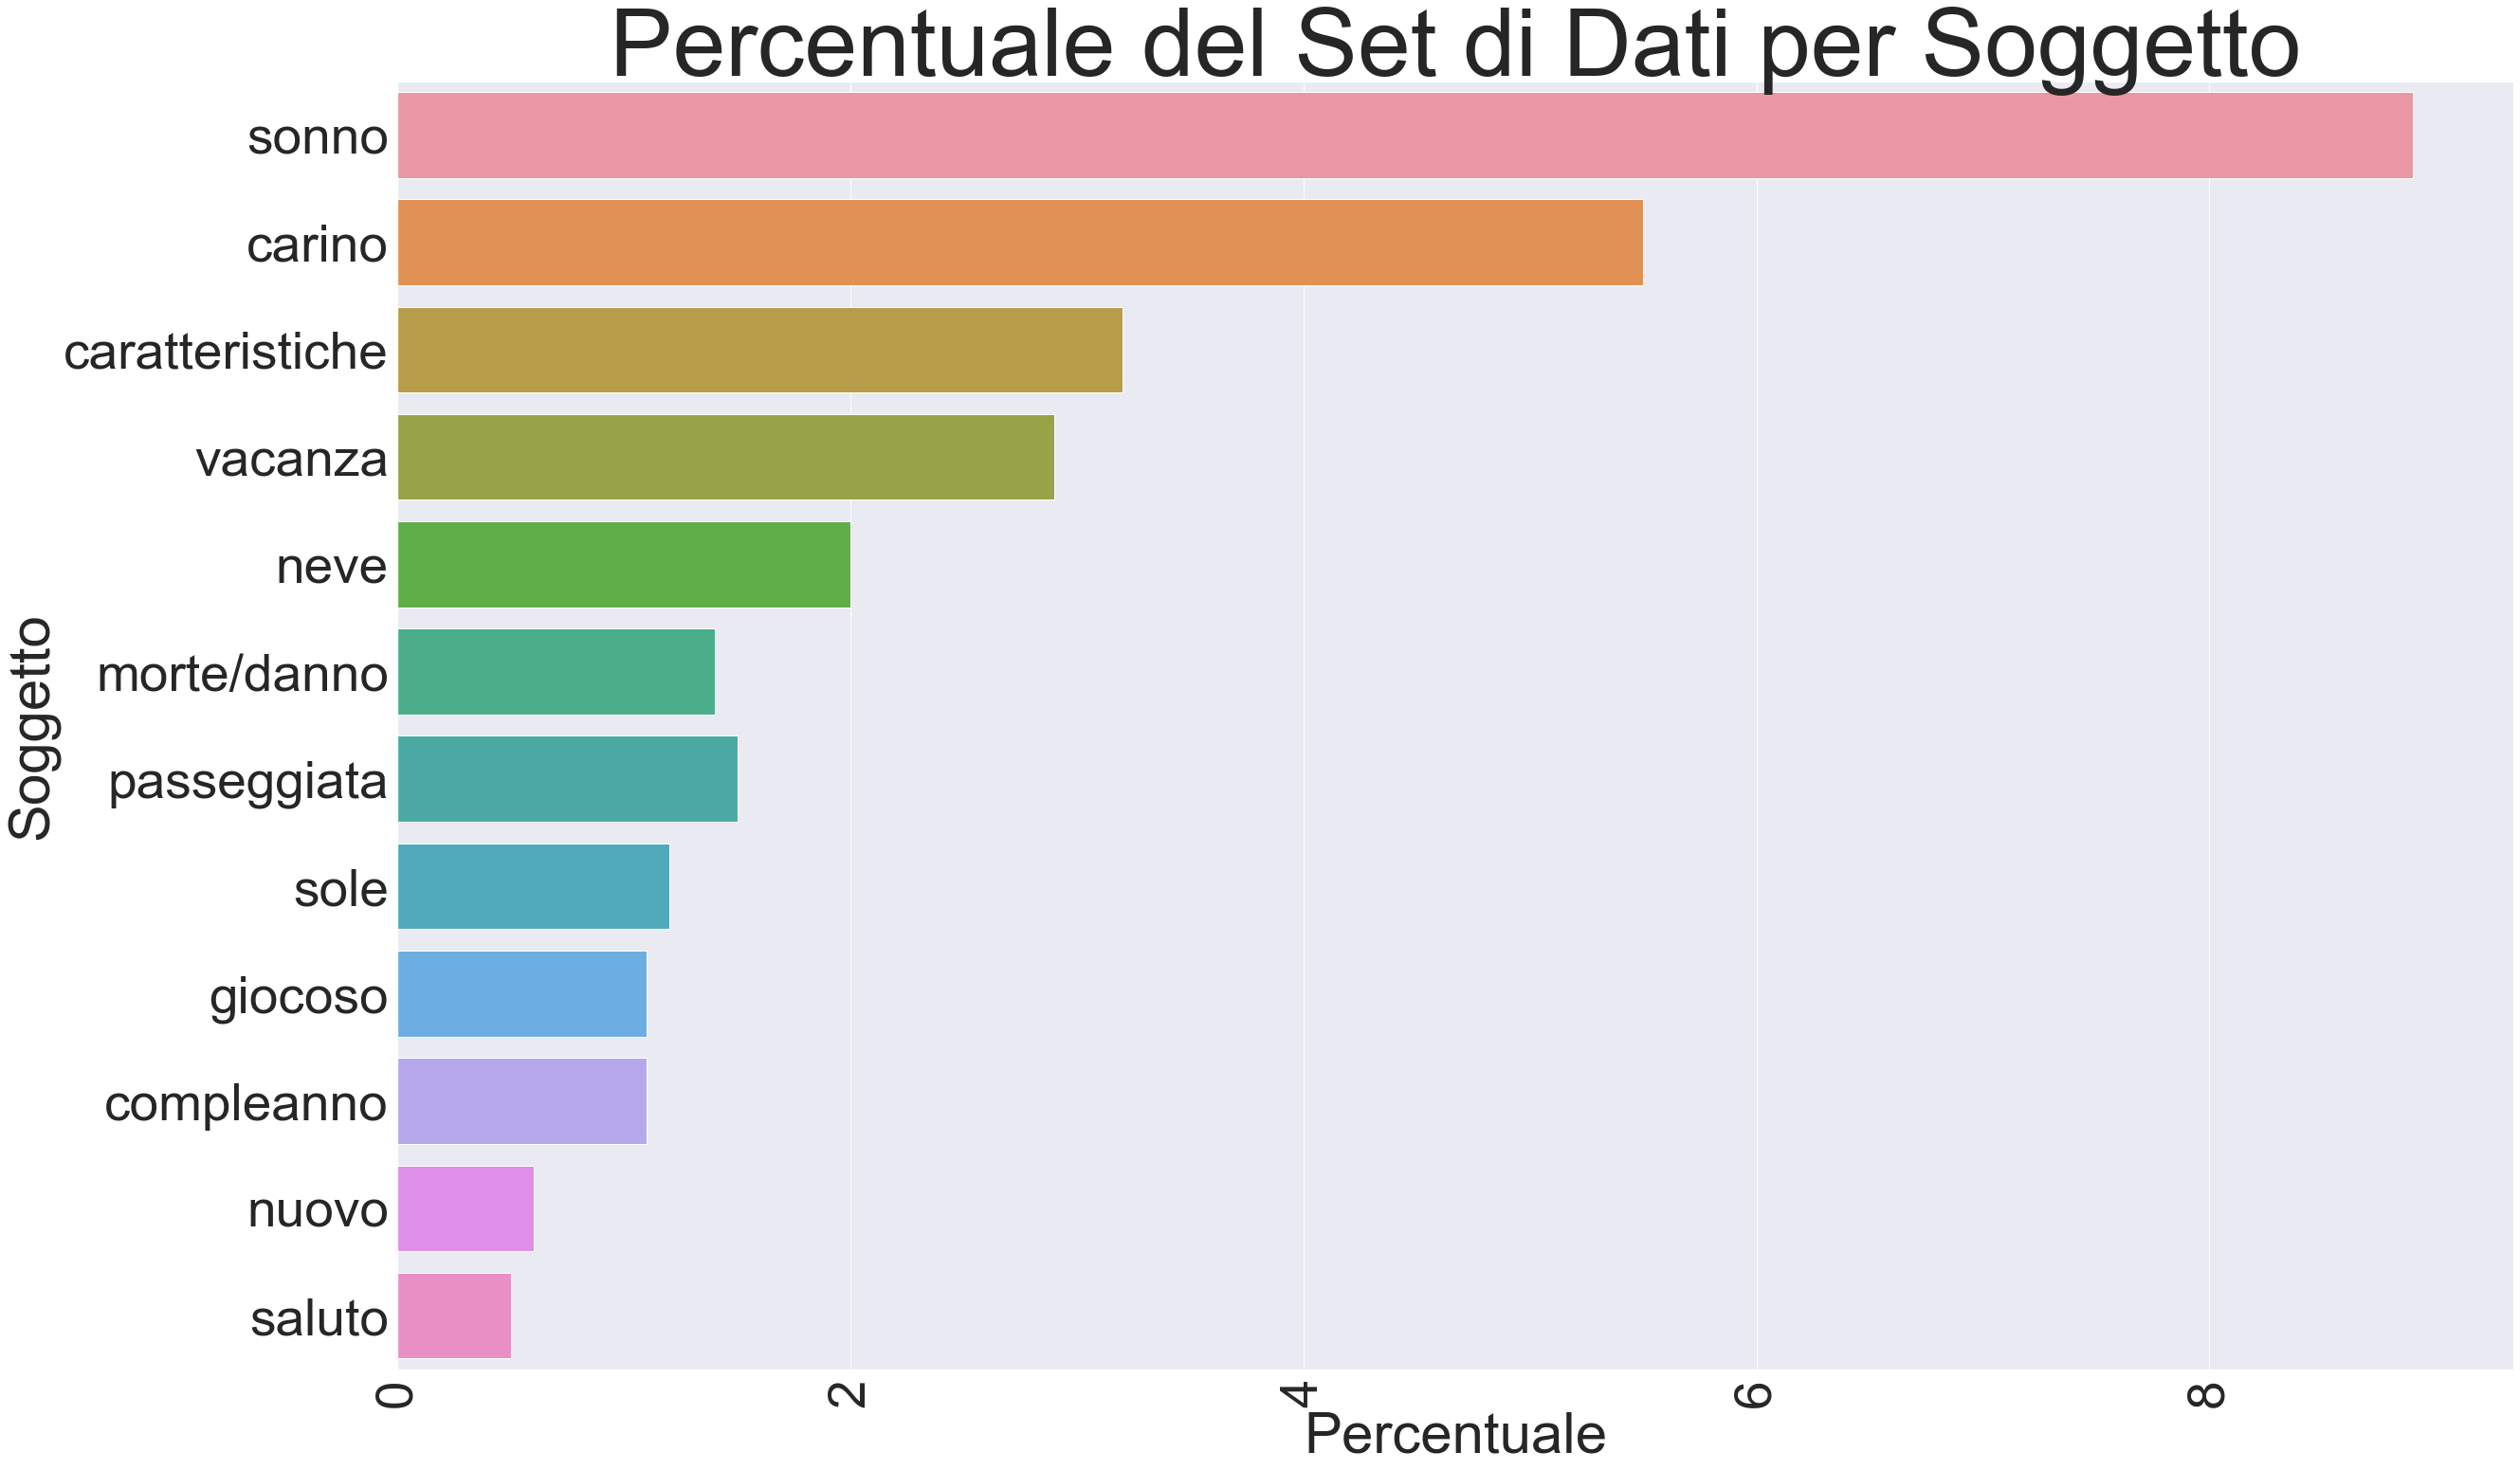

In [37]:
for l in languages:
    for f in ["all","cats","dogs"]:
        
        
        sns.set(font_scale=5)

        fig,ax = plt.subplots(figsize=(40,25))
        
        
        if l=="English":
    
            if f=="all":
                data = df.value_counts(subset="subject",normalize=True).to_frame().reset_index().rename(columns={0:"percent"})
            else:
                data = df[df.category==f].value_counts(subset="subject",normalize=True).to_frame().reset_index().rename(columns={0:"percent"})
            
            sns.barplot(data=data[data.subject!="other"],ax=ax,x="percent",y="subject",order=sub_order)

            
        else:

            if f=="all":
                data = df.value_counts(subset="soggetto",normalize=True).to_frame().reset_index().rename(columns={0:"percent"})
            else:
                data = df[df.category==f].value_counts(subset="soggetto",normalize=True).to_frame().reset_index().rename(columns={0:"percent"})
    
            data["percent"] = np.round(data.percent*100,1)
            sns.barplot(data=data[data.soggetto!="altro"],ax=ax,x="percent",y="soggetto",order=sub_order_it)


        
        if l=="English":
            plt.title("Percentage of the Dataset by Subject",fontsize=100)
            plt.xlabel("Percentage")
            plt.ylabel("Subject")
        else:
            plt.title("Percentuale del Set di Dati per Soggetto",fontsize=100)
            plt.xlabel("Percentuale")
            plt.ylabel("Soggetto")
        plt.xticks(rotation = 90)
        
        plt.savefig(f'appdata/captionsubject_count_{l.lower()}_{f}.png')

### Popularity by Subject

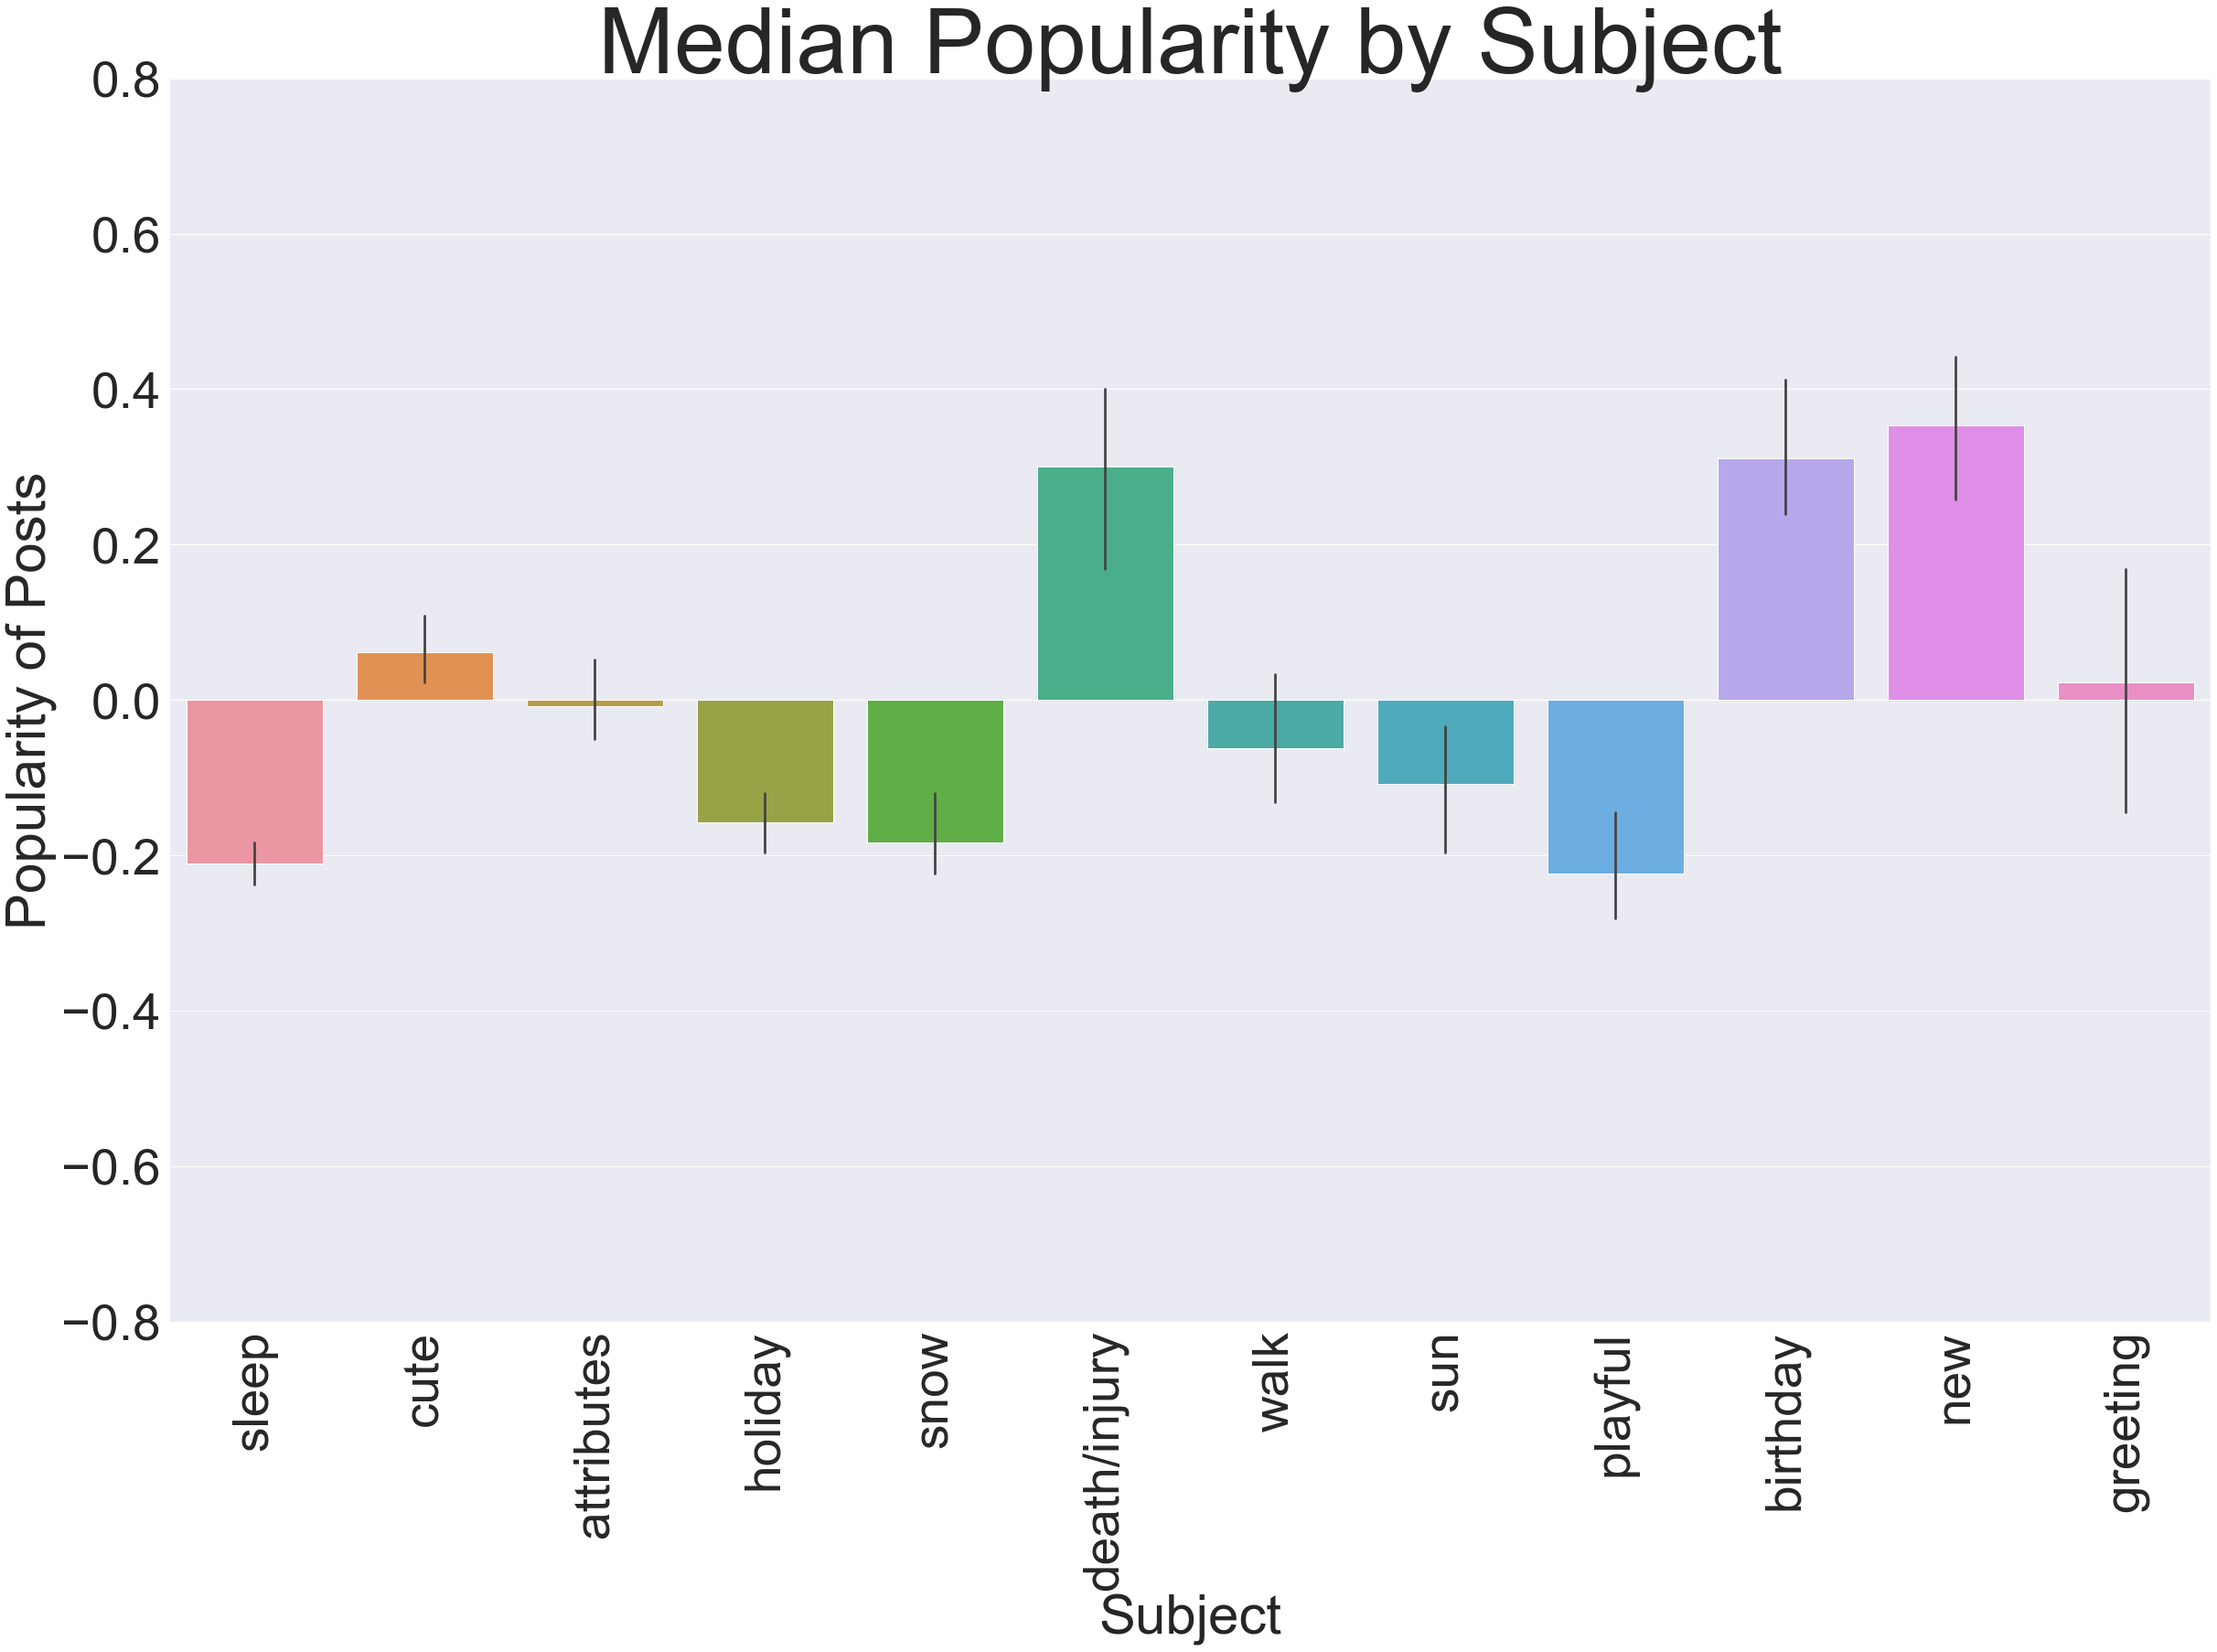

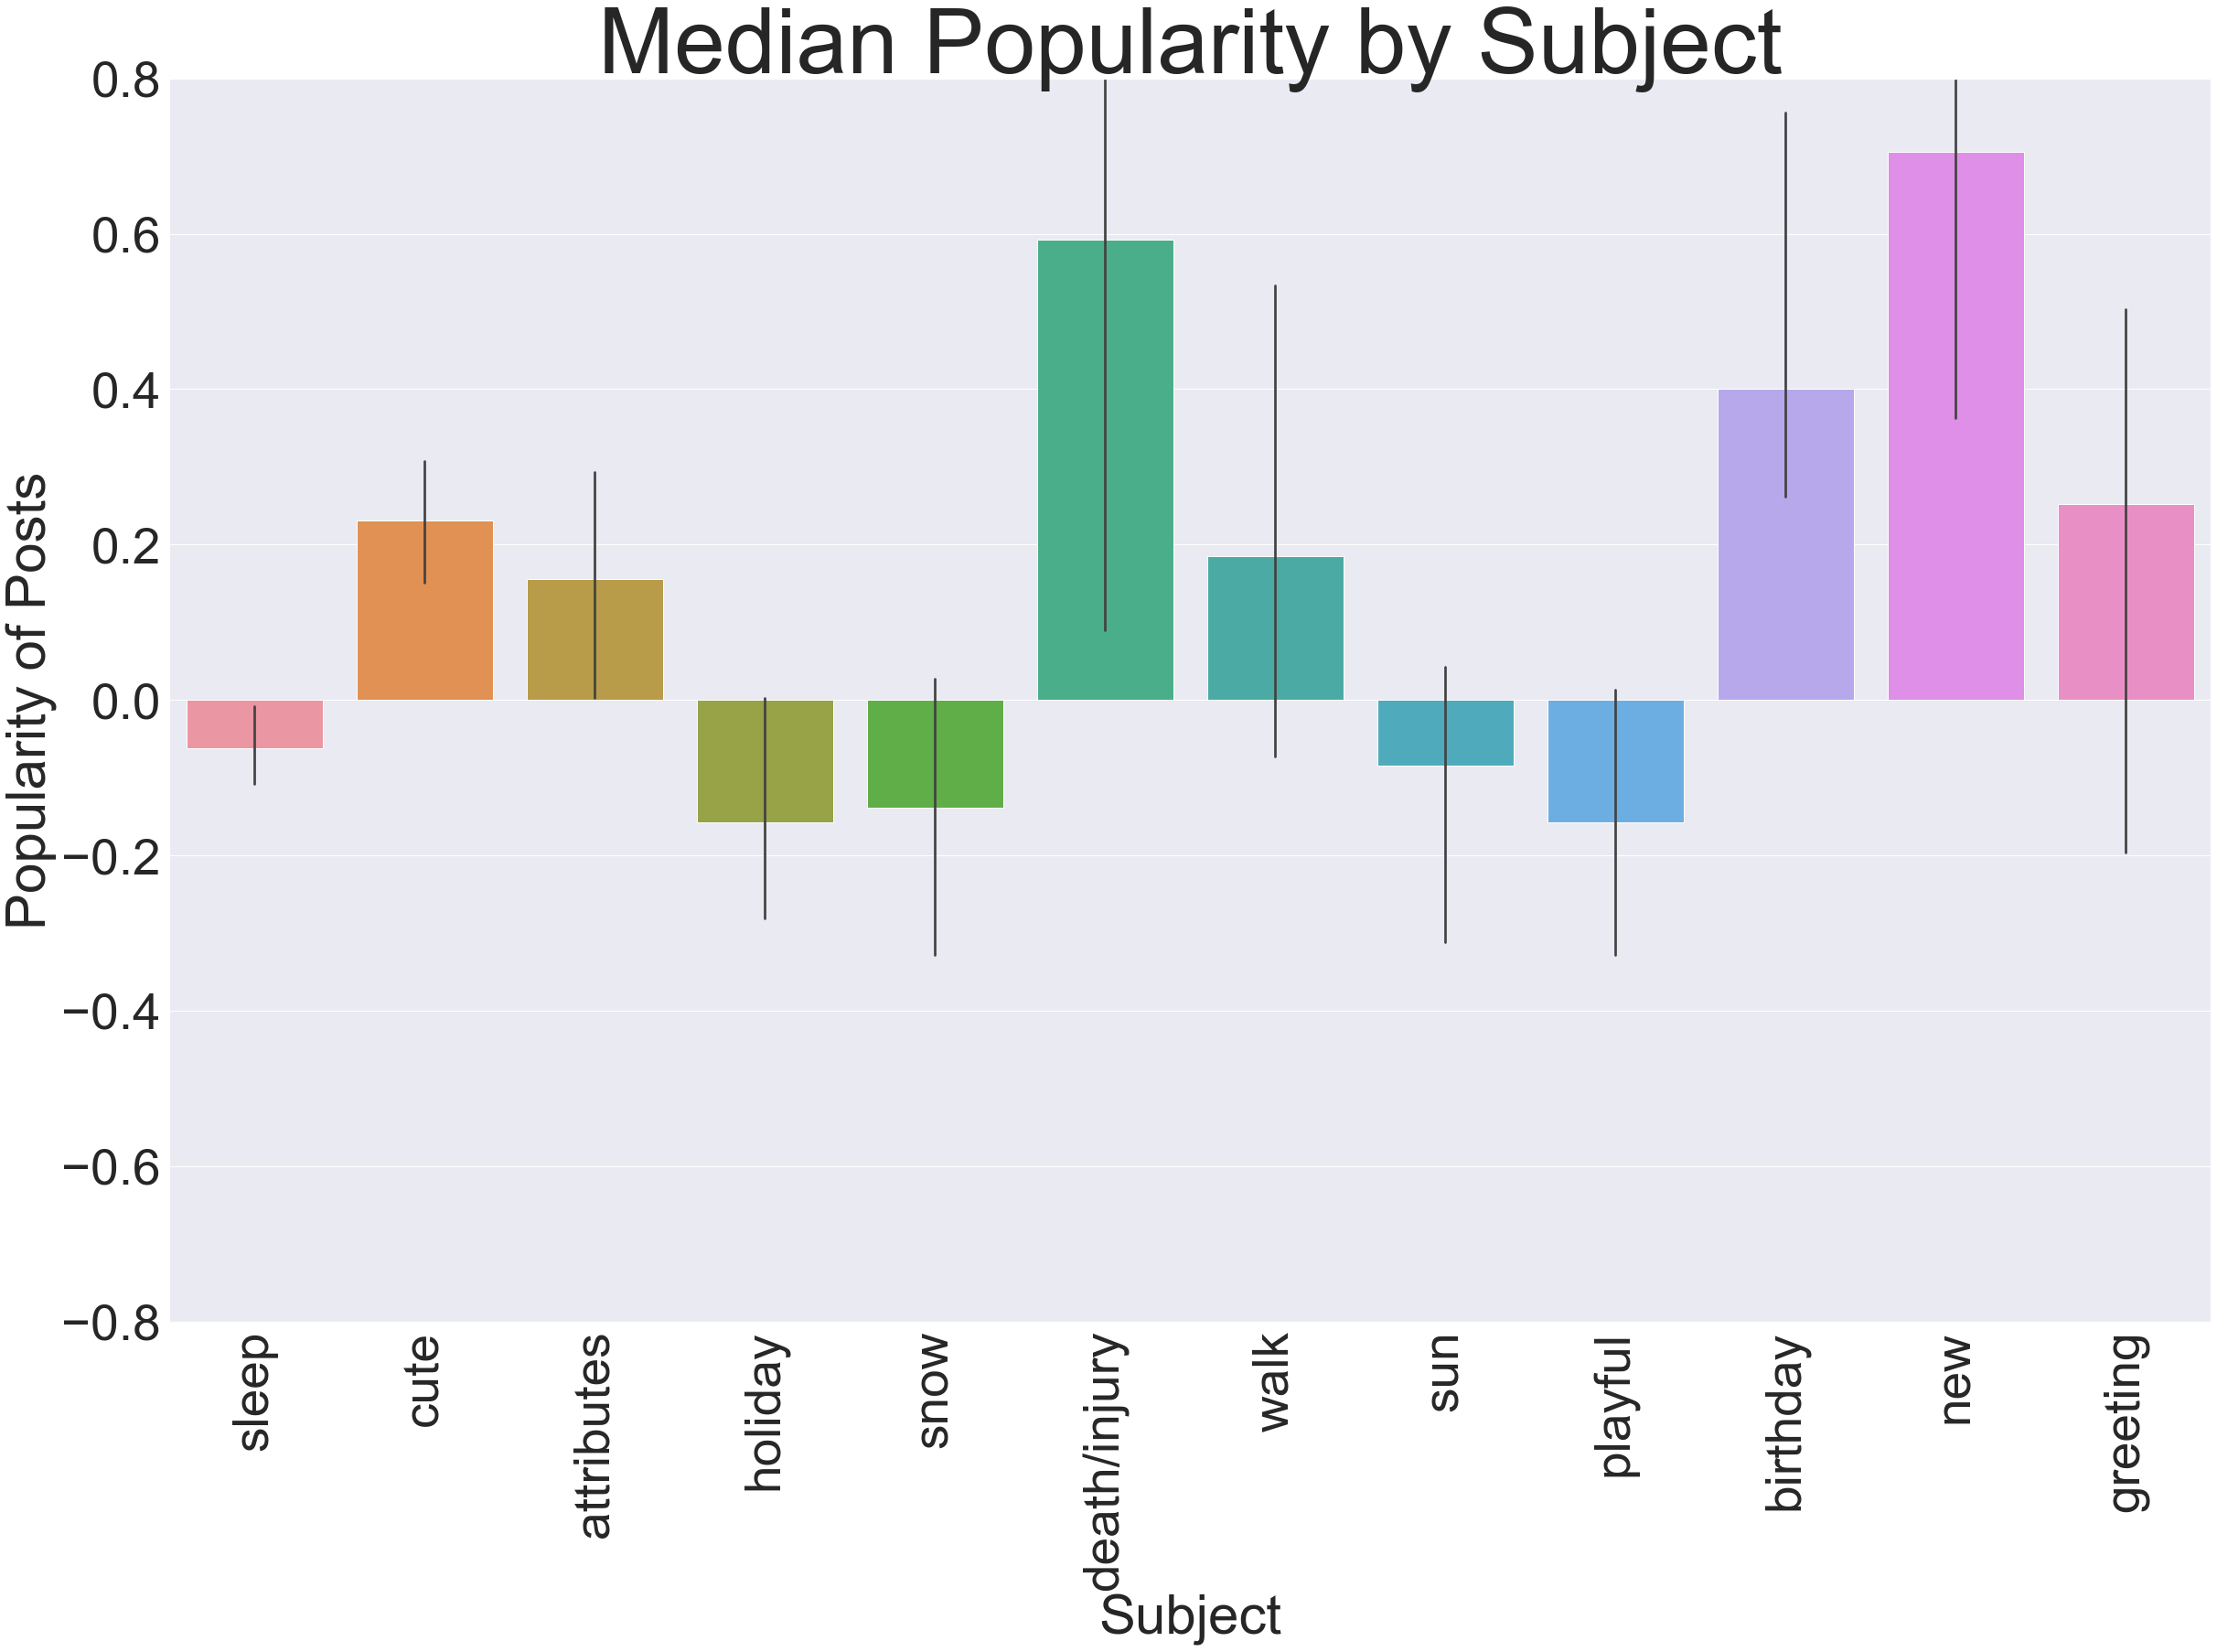

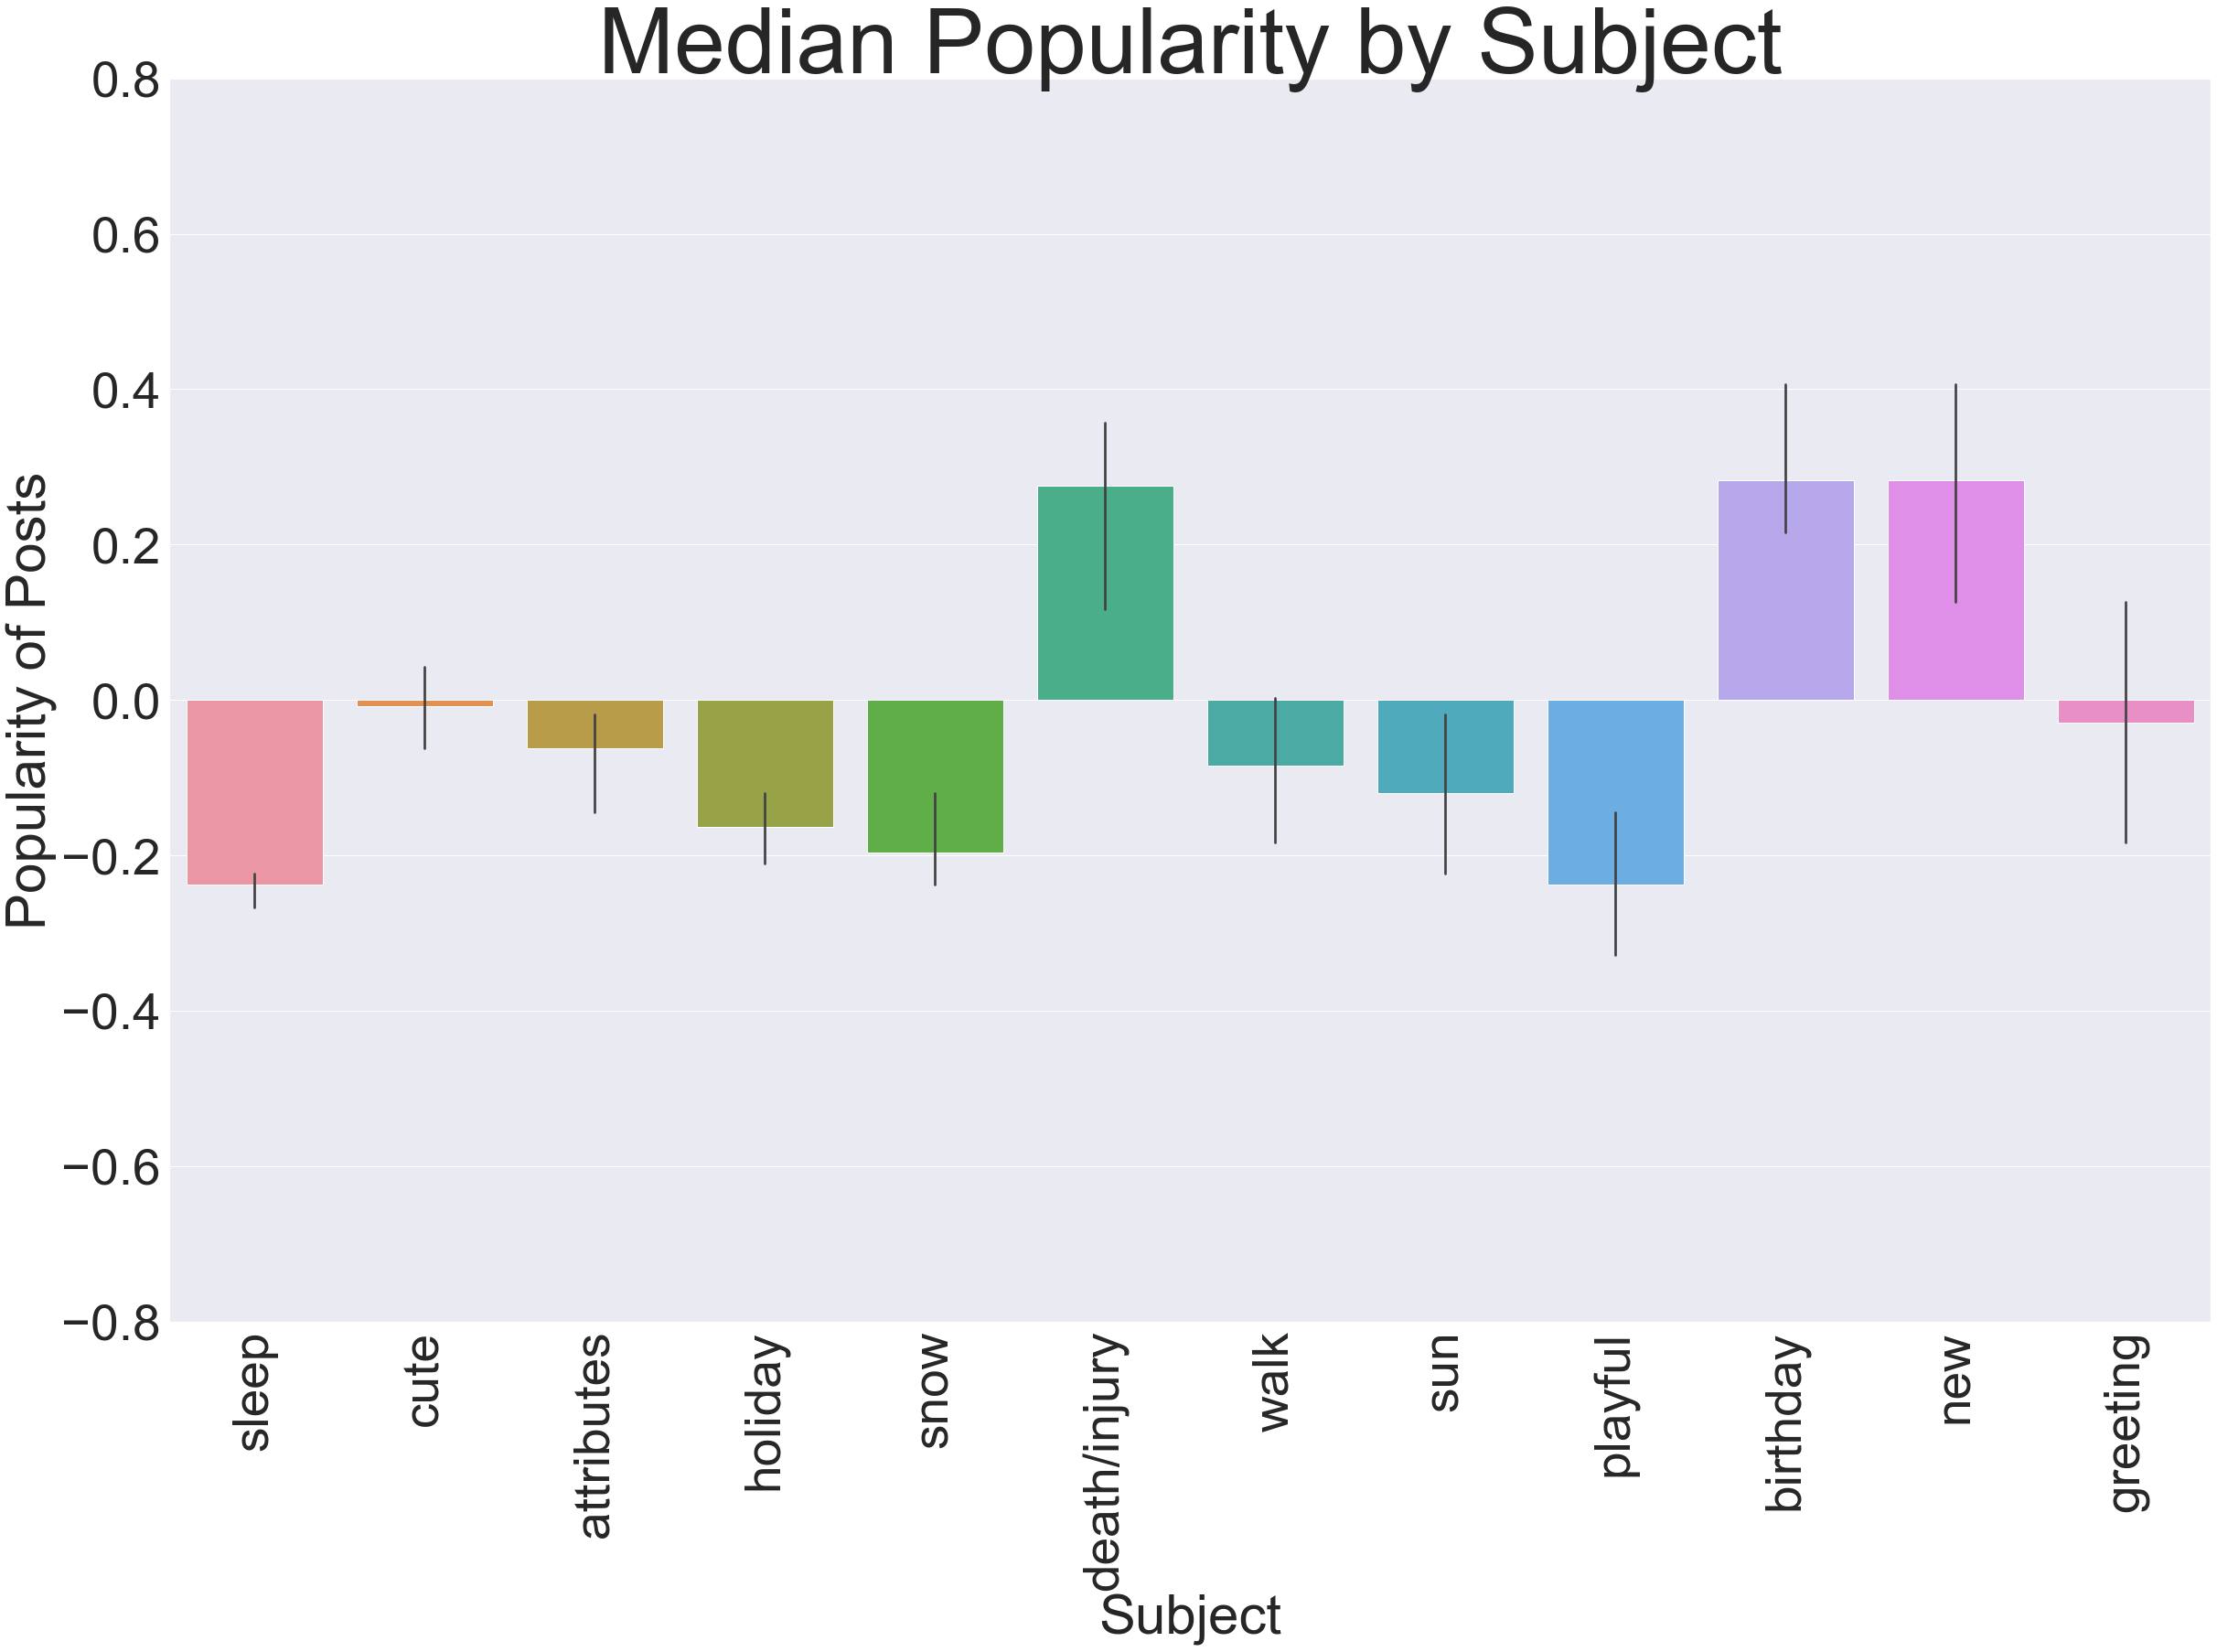

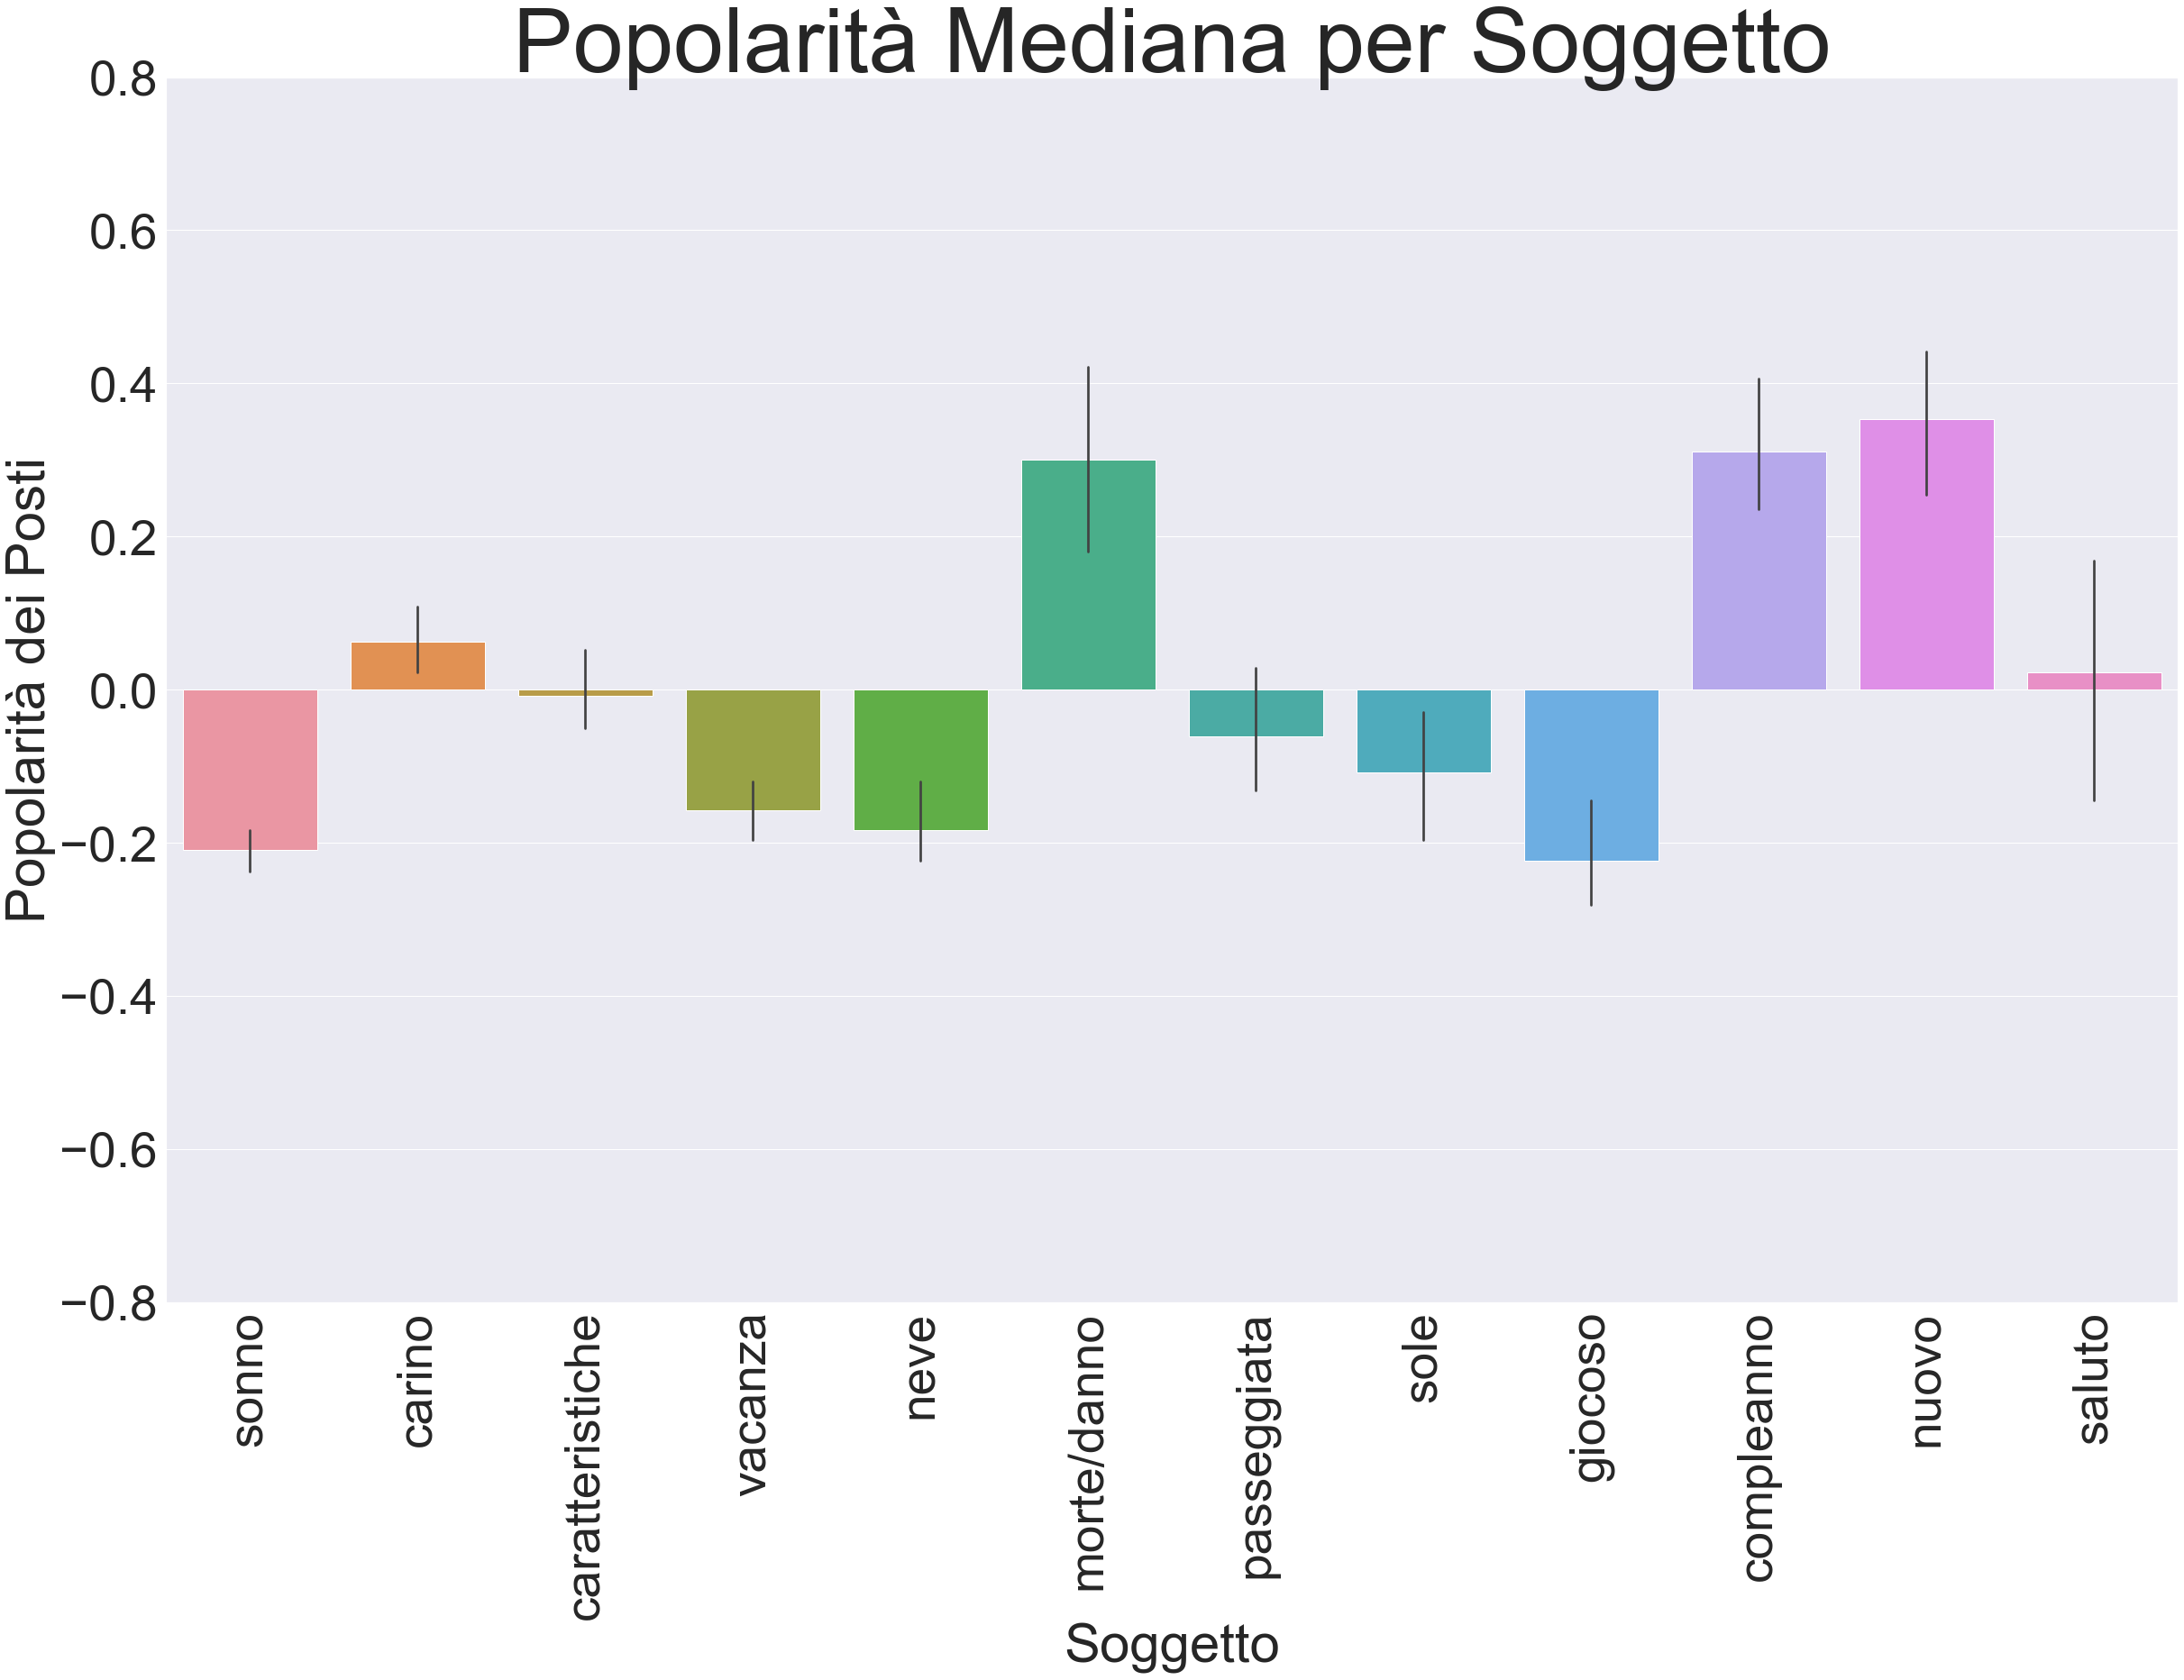

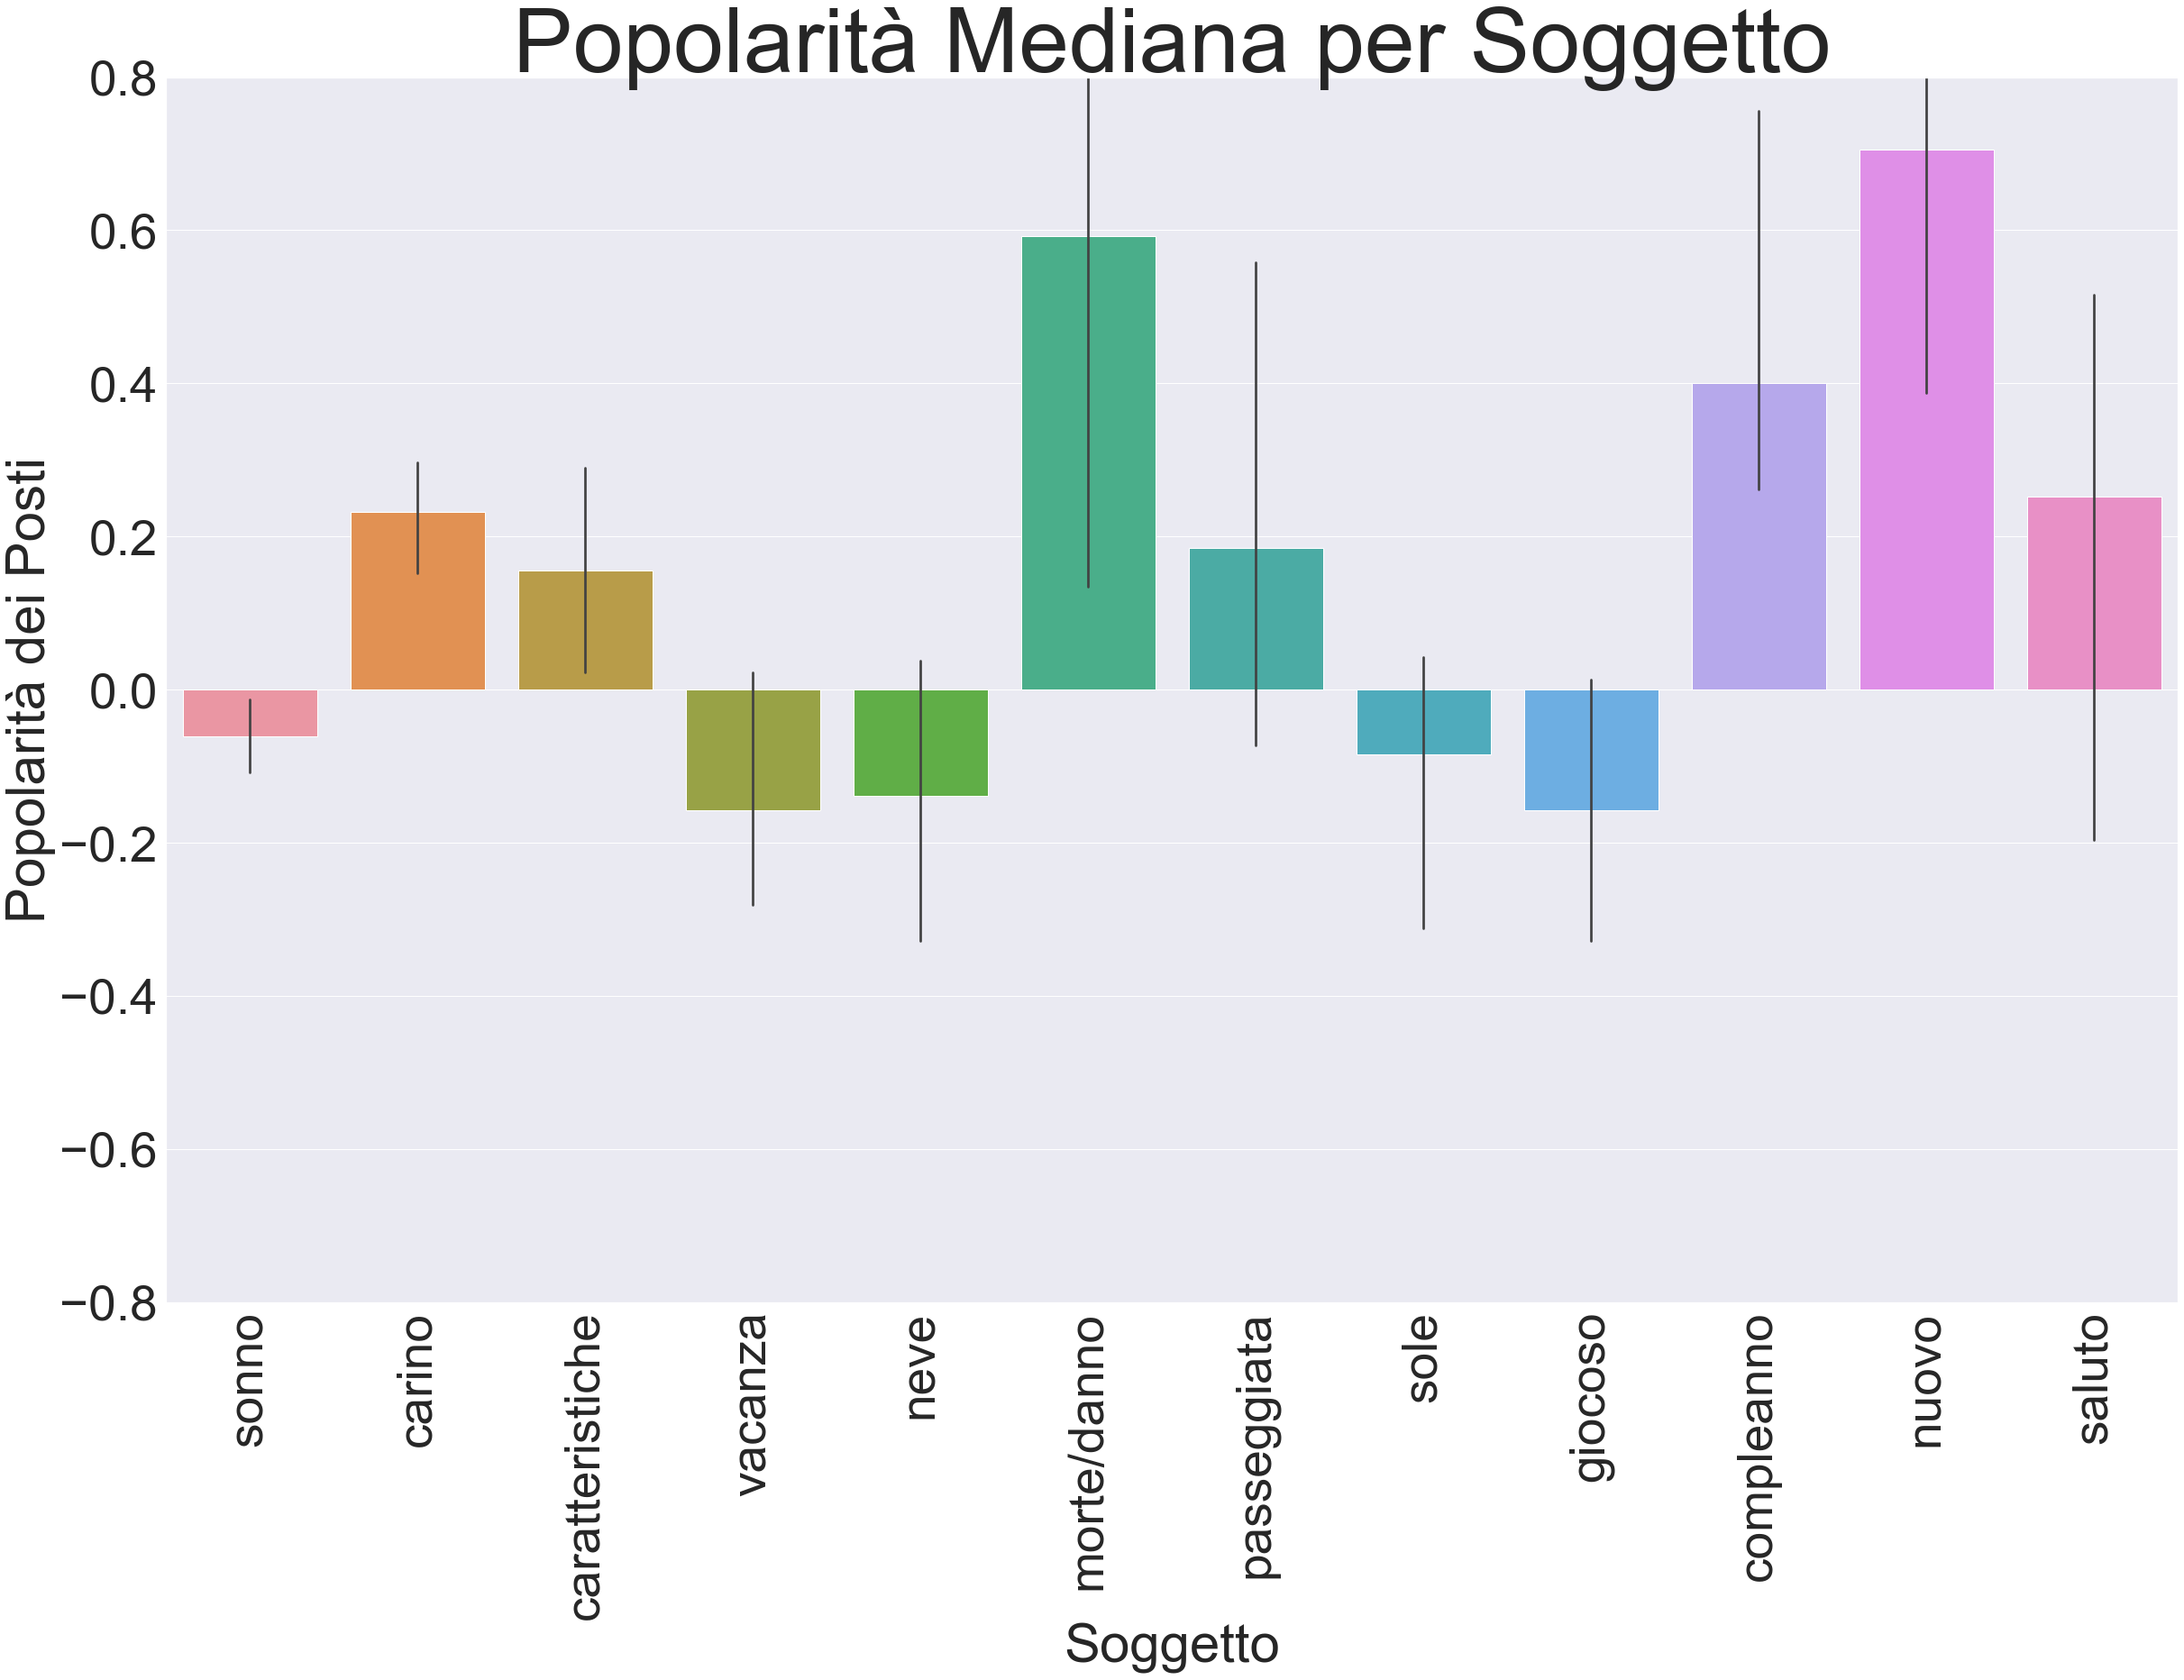

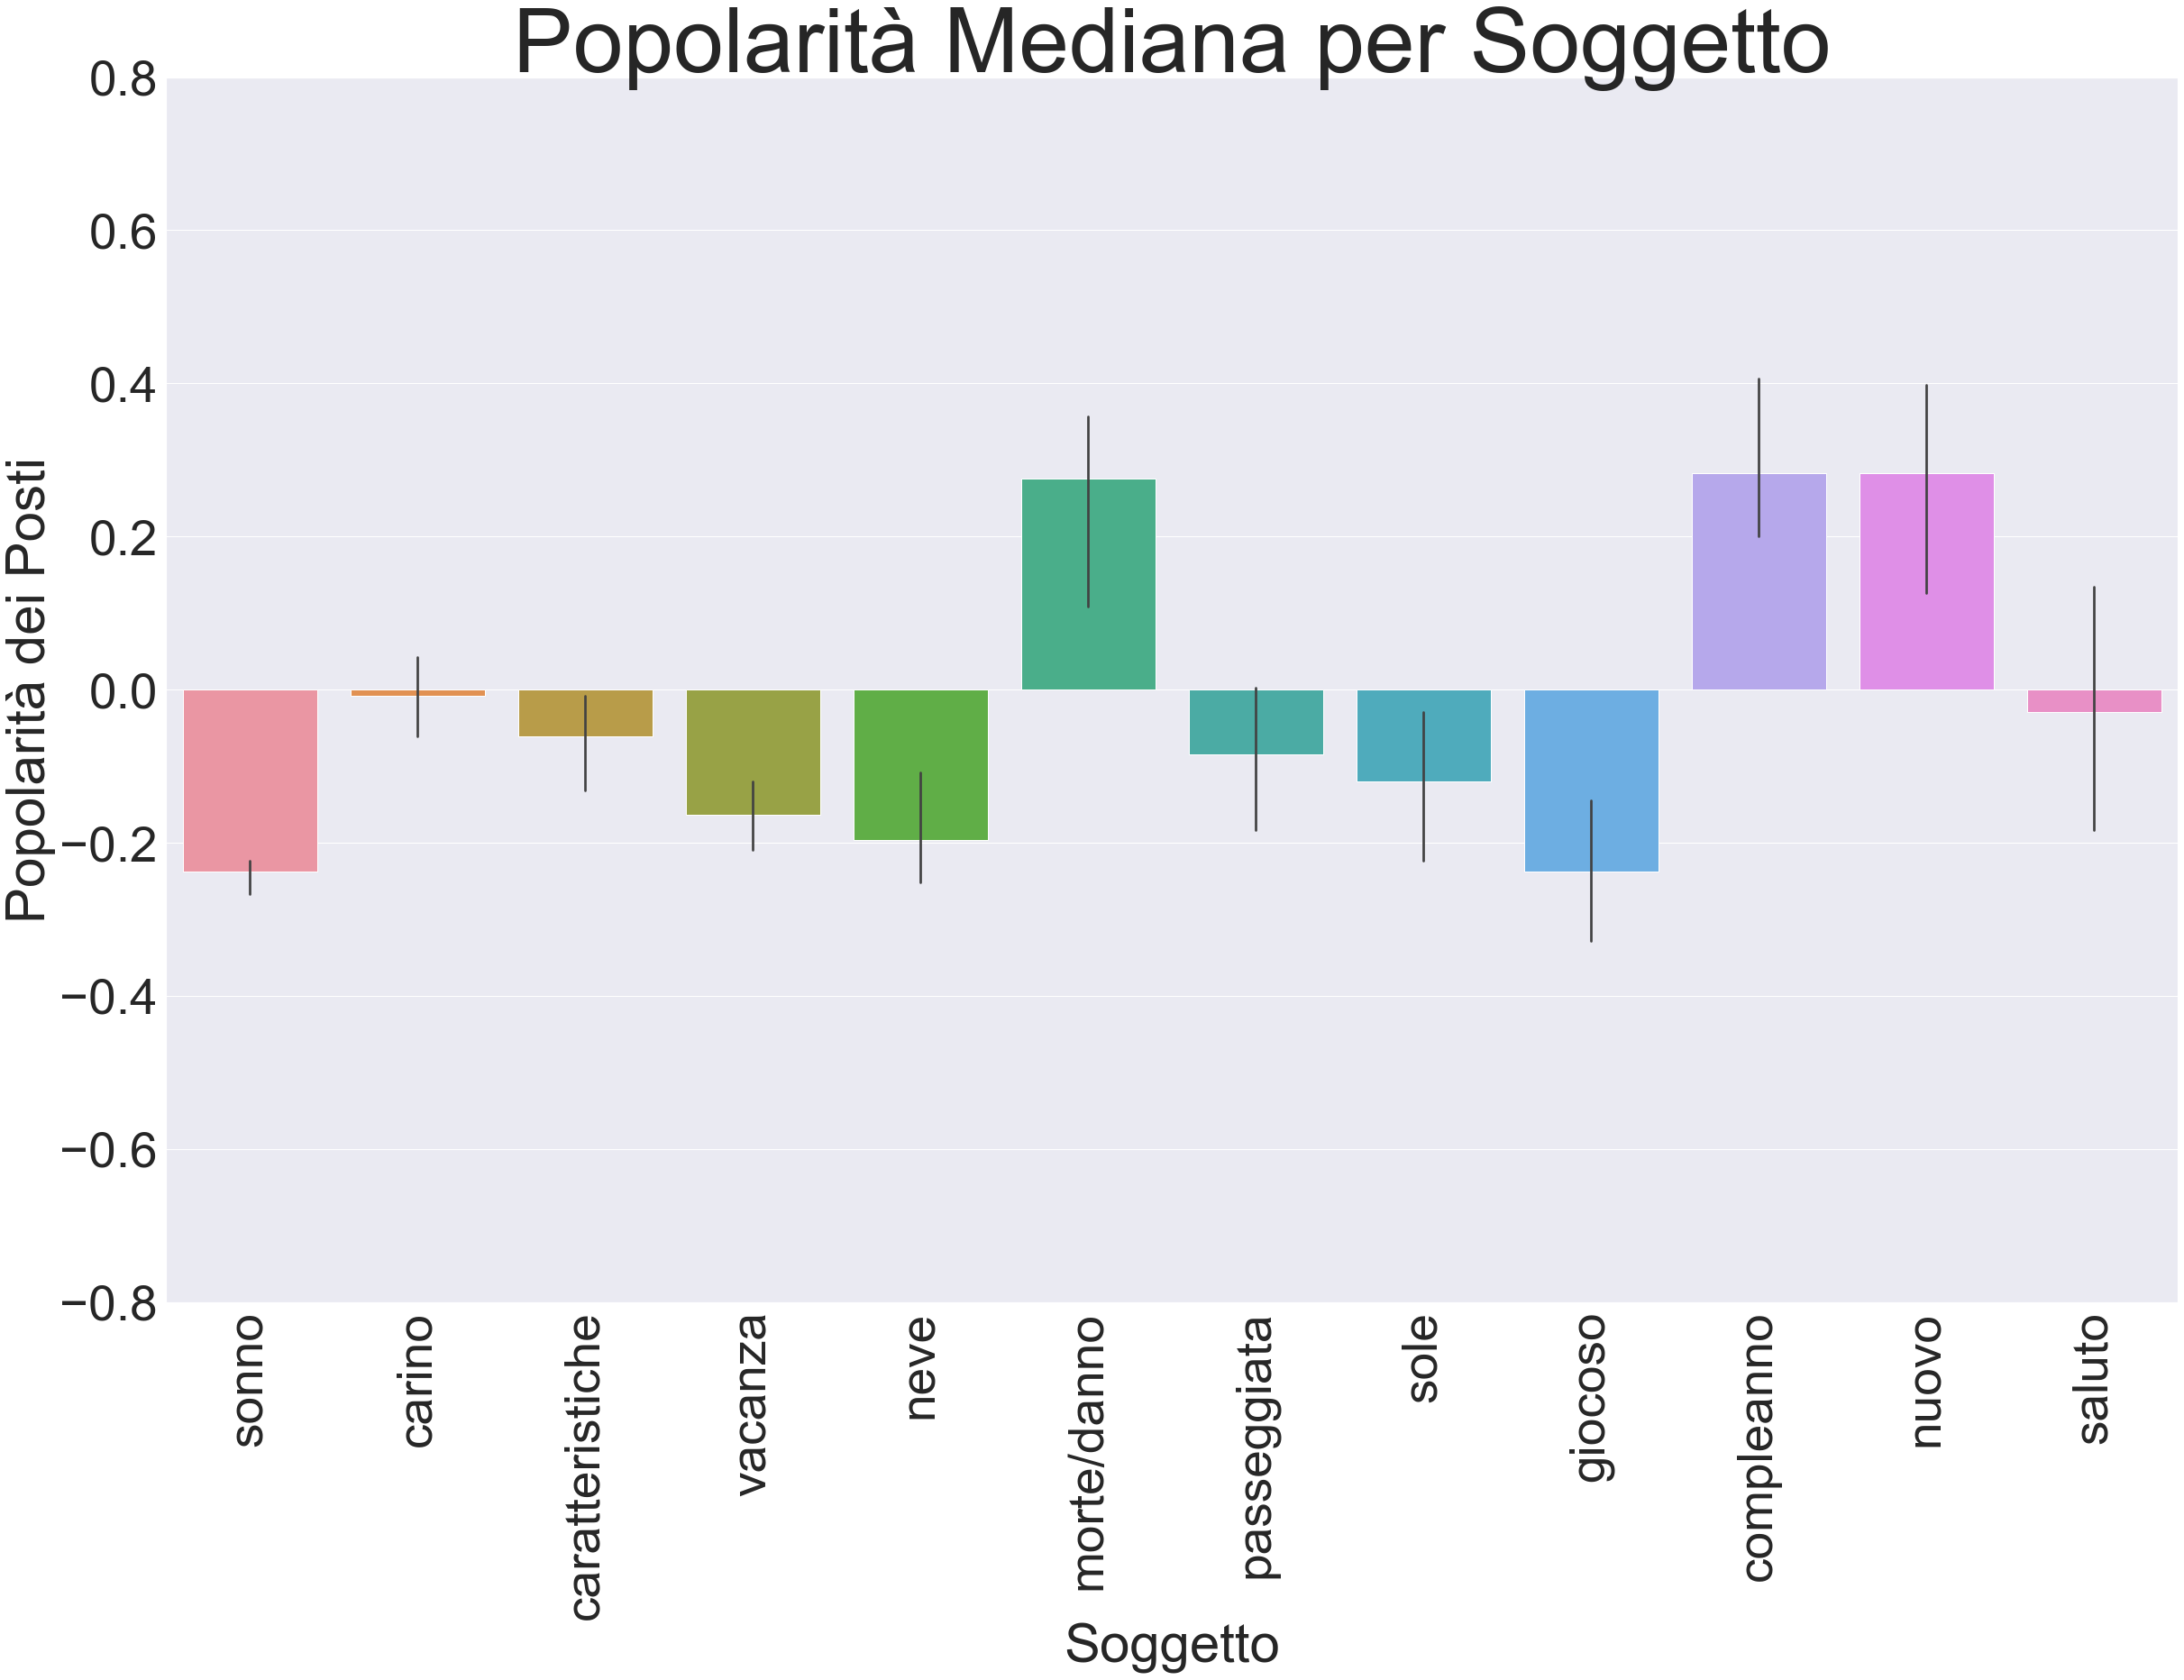

In [34]:
for l in languages:
    for f in ["all","cats","dogs"]:
    
        sns.set(font_scale=5)

        fig,ax = plt.subplots(figsize=(40,25))
        
        if l=="English":
            if f=="all":
                sns.barplot(data=df,ax=ax,x="subject",y="target",estimator=np.median,order=sub_order)
            else:
                sns.barplot(data=df[df.category==f],ax=ax,x="subject",y="target",estimator=np.median,order=sub_order)
        else:
            if f=="all":
                sns.barplot(data=df,ax=ax,x="soggetto",y="target",estimator=np.median,order=sub_order_it)
            else:
                sns.barplot(data=df[df.category==f],ax=ax,x="soggetto",y="target",estimator=np.median,order=sub_order_it)

        if l=="English":
            plt.title("Median Popularity by Subject",fontsize=100)
            plt.xlabel("Subject")
            plt.ylabel("Popularity of Posts")
        else:
            plt.title("Popolarità Mediana per Soggetto",fontsize=100)
            plt.xlabel("Soggetto")
            plt.ylabel("Popolarità dei Posti")
        plt.ylim([-0.8,0.8])
        plt.xticks(rotation = 90)
            
            
        
        plt.savefig(f'appdata/captionsubject_target_{l.lower()}_{f}.png',bbox_inches='tight')

In [11]:
df.subject.unique()

array(['other', 'greeting', 'sun', 'sleep', 'snow', 'death/injury',
       'attributes', 'cute', 'playful', 'holiday', 'new', 'birthday',
       'walk'], dtype=object)

In [14]:
dict(zip(df.sort_values("subject").subject.unique(),df.sort_values("subject").soggetto.unique()))

{'attributes': 'caratteristiche',
 'birthday': 'compleanno',
 'cute': 'carino',
 'death/injury': 'morte/danno',
 'greeting': 'saluto',
 'holiday': 'vacanza',
 'new': 'nuovo',
 'other': 'altro',
 'playful': 'giocoso',
 'sleep': 'sonno',
 'snow': 'neve',
 'sun': 'sole',
 'walk': 'passeggiata'}

### Subject Wordclouds

In [15]:
import nltk
nltk.download('stopwords')


import json
import glob


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy
# from nltk import stopwords
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import pyLDAvis
import pyLDAvis.gensim

import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
    
    nlp = spacy.load("en_core_web_sm",disable=["parser","ner"])
    
    texts_out = []
    
    for text in texts:
        
        doc = nlp(text)
        new_text = []
        
        for token in doc:
            
            if token.pos_ in allowed_postags:
                
                new_text.append(token.lemma_)
                
        final = " ".join(new_text)
        
        texts_out.append(final)

    return texts_out

In [21]:
data = df.title.tolist()

In [22]:
new_data = lemmatization(data)

In [23]:
def gen_word(texts):
    
    final = []
    
    for text in texts:
        
        new = gensim.utils.simple_preprocess(text,deacc=True)
        final.append(new)
        
    return (final)

In [24]:
data_words = gen_word(new_data)

In [25]:
bigram_phrases = gensim.models.Phrases(data_words,min_count=5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)


def make_bigrams(texts):

    return [bigram[doc] for doc in texts]


def make_trigram(texts):

    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigram(data_bigrams)


print(data_bigrams_trigrams[0][0:10])

['caturday', 'morning', 'tv']


In [26]:
df["trigrams"] = data_bigrams_trigrams

In [27]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [32]:
for sub in df.subject.unique():
    
    for cat in ["all","cats","dogs"]:
        
        if cat=="all":
            
            text = " ".join([sentence for sentence in df[df.subject==sub].trigrams.apply(lambda x: " ".join(x))])
       
        else:
            
            text = " ".join([sentence for sentence in df[(df.subject==sub)&(df.category==cat)].trigrams.apply(lambda x: " ".join(x))])

        wordcloud = WordCloud(max_words=50,width=400, height=500).generate(text)
        wordcloud.to_file(f'appdata/wordcloud_{cat}_{sub.replace("/","-")}.png')
            
            
            
            
        